In [1]:
!nvidia-smi

Fri Aug 21 14:48:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import torch 
import torch.nn as nn
import torchvision
import numpy as np 
import random
import os
import glob
import copy
from tqdm import tqdm as tqdm
from torchsummary import summary

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)

best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# train class samples 
print('Normal Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/NORMAL | wc -l
print('Pneumonia Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/PNEUMONIA | wc -l

Normal Samples in Training Data
1342
Pneumonia Samples in Training Data
3876


In [5]:
# Validation samples
print('Normal Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/NORMAL | wc -l
print('Pneumonia Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/PNEUMONIA | wc -l

Normal Samples in Validation Data
9
Pneumonia Samples in Validation Data
9


In [6]:
# Testing samples
print('Normal Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/NORMAL | wc -l
print('Pneumonia Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/PNEUMONIA | wc -l

Normal Samples in Testing Data
235
Pneumonia Samples in Testing Data
391


In [7]:
# Copying to Non DP data(train, val and test) to local to process/run faster during training & inference

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/train ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/val ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/test ./

In [8]:
!ls -lrt

total 20
drwxr-xr-x 1 root root 4096 Jul 30 16:30 sample_data
drwx------ 4 root root 4096 Aug 21 14:49 drive
drwx------ 4 root root 4096 Aug 21 14:56 train
drwx------ 4 root root 4096 Aug 21 15:14 val
drwx------ 4 root root 4096 Aug 21 15:15 test


In [9]:
!ls -l ./train/NORMAL | wc -l

!ls -l ./train/PNEUMONIA | wc -l

1342
3876


In [10]:
!ls -l ./val/NORMAL | wc -l

!ls -l ./val/PNEUMONIA | wc -l

9
9


In [11]:
!ls -l ./test/NORMAL | wc -l

!ls -l ./test/PNEUMONIA | wc -l

235
391


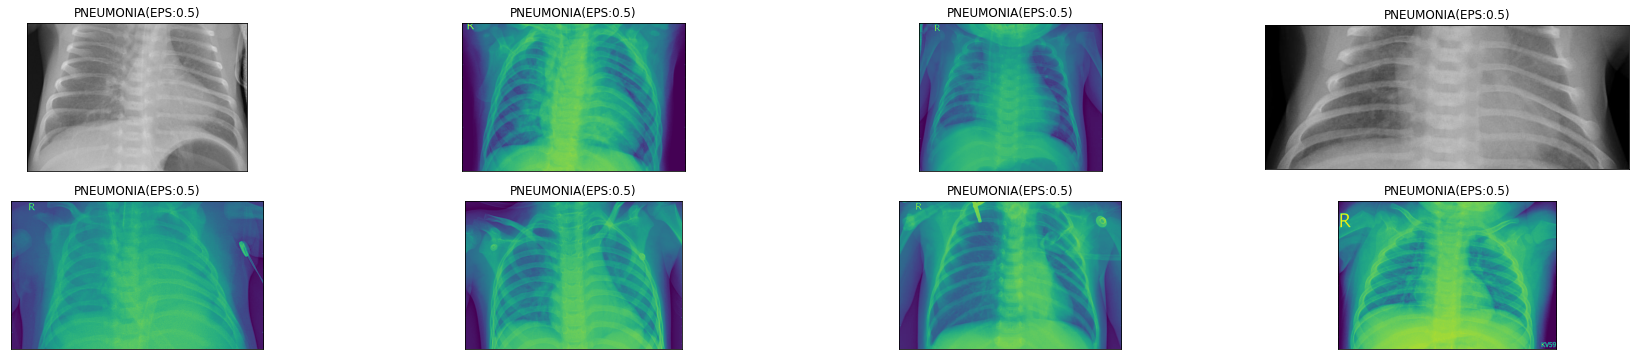

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 PNEUMONIA images(train) for Epsilon :0.5
train_imgs = os.listdir(base_dir+"/PNEUMONIA")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/PNEUMONIA/" + img)
    plt.imshow(im)
    ax.set_title('PNEUMONIA(EPS:0.5)')

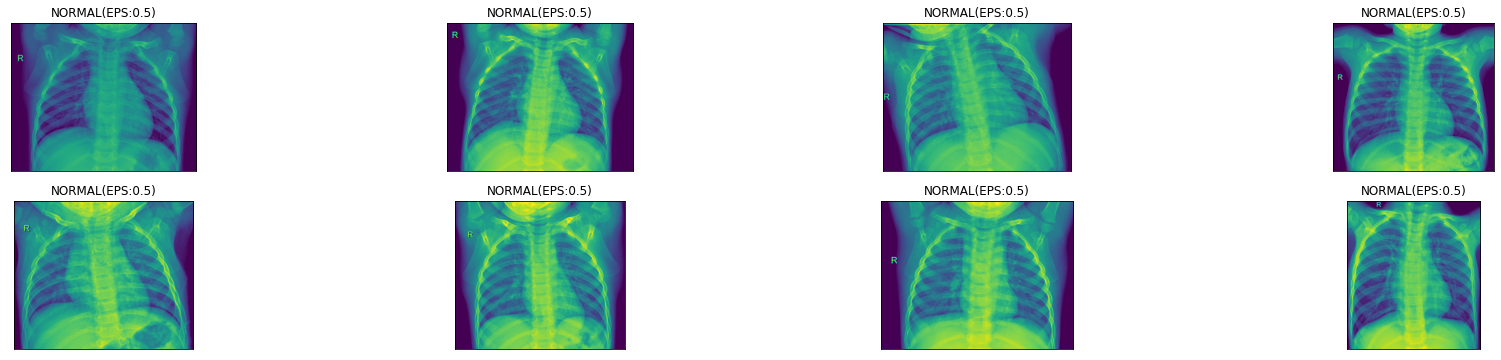

In [13]:
fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 NORMAL images(train) for Epsilon :0.5
train_imgs = os.listdir(base_dir+"/NORMAL")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/NORMAL/" + img)
    plt.imshow(im)
    ax.set_title('NORMAL(EPS:0.5)')

In [14]:
class ChestXRay(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        path, _ = self.samples[index]
        
        target = 0
        if 'PNEUMONIA' in path:
            target = 1
        
        return sample, target
       

In [15]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = ChestXRay('./train/', transform=train_transforms)
val_dataset = ChestXRay('./val/', transform=train_transforms)
test_dataset = ChestXRay('./test/', transform=transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [16]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=2)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
summary(model.cuda(), [(3,224,224,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        #m.affine = False
        #m.track_running_stats = False
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()

In [19]:
def clip_grad(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

In [20]:
def train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    model.apply(deactivate_batchnorm)
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    num_microbatches = 32
    #S = 1
    S = 0.3
    z = 9.7 #DP-SGD with sampling rate = 2.45% and noise_multiplier = 9.7 iterated over 2039 steps satisfies differential privacy with eps = 0.5 and delta = 0.0001.
            #The optimal RDP order is 38.0.
    sigma = z * S
    for batch_idx, data in tqdm(enumerate(trainloader, 0), leave=True):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        #print(loss.shape)
        running_loss += torch.mean(loss).item()

        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())

        losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)

        for j in losses:
            j.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()

        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, sigma)
                #noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        optimizer.step()

        #print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {loss}', end='', flush=True)
        print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)

        '''if i > 0 and i % 20 == 0:
            #             logger.info('[%d, %5d] loss: %.3f' %
            #                   (epoch + 1, i + 1, running_loss / 2000))
            plot(epoch * len(trainloader) + i, running_loss, 'Train Loss')
            running_loss = 0.0'''
    #print("RETURNING........")
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()      

In [21]:
def test(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()
    model.apply(deactivate_batchnorm)
    #correct = 0
    #total = 0

    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, data in  enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            true_labels.append(labels.detach().cpu())
            pred_labels.append(preds.detach().cpu())

            # print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {loss}', end='', flush=True)
            print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
            epoch_loss += torch.mean(loss.detach().cpu()).item()
            epoch_acc += torch.sum(preds == labels.data)
            batch_num += 1
            samples_num += len(labels)

            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
        #print("TESTING.....")
        return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [22]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
optimizer = torch.optim.SGD([{'params': [param for name, param in model.named_parameters() if 'fc' not in name]}, {'params': model.fc.parameters(), 'lr': 1e-3}], lr=5e-4, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [23]:
train_losses = []
val_losses = []
test_losses = []

for epoch in range(50):
    print('='*15, f'Epoch: {epoch}')
    
#train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train')
#test(model, testloader, criterion, optimizer, lr_scheduler, phase='test')

    train_loss, train_acc, _, _ = train_dp(model, train_dataloader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = test(model, val_dataloader, criterion, optimizer, lr_scheduler, phase='val')
    test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
    print()
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-{seed}.pt')
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_test_loss = test_loss
        best_test_acc = test_acc 
        best_pred_labels = pred_labels
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-best-{seed}.pt')

0it [00:00, ?it/s]

=============== Epoch: 0
train batch [0/41]: loss 0.6756365895271301

1it [00:08,  8.61s/it]

train batch [1/41]: loss 0.6670445799827576

2it [00:17,  8.55s/it]

train batch [2/41]: loss 0.675865888595581

3it [00:25,  8.55s/it]

train batch [3/41]: loss 0.6797657012939453

4it [00:34,  8.60s/it]

train batch [4/41]: loss 0.6753180027008057

5it [00:42,  8.56s/it]

train batch [5/41]: loss 0.6657456159591675

6it [00:50,  8.47s/it]

train batch [6/41]: loss 0.6744284629821777

7it [00:59,  8.49s/it]

train batch [7/41]: loss 0.6646482944488525

8it [01:08,  8.48s/it]

train batch [8/41]: loss 0.669073224067688

9it [01:16,  8.50s/it]

train batch [9/41]: loss 0.6697994470596313

10it [01:24,  8.46s/it]

train batch [10/41]: loss 0.6648311614990234

11it [01:33,  8.44s/it]

train batch [11/41]: loss 0.6618547439575195

12it [01:41,  8.44s/it]

train batch [12/41]: loss 0.6754390597343445

13it [01:50,  8.50s/it]

train batch [13/41]: loss 0.6656819581985474

14it [01:58,  8.52s/it]

train batch [14/41]: loss 0.6701346635818481

15it [02:07,  8.53s/it]

train batch [15/41]: loss 0.6734492778778076

16it [02:16,  8.57s/it]

train batch [16/41]: loss 0.6590815782546997

17it [02:24,  8.54s/it]

train batch [17/41]: loss 0.6750978827476501

18it [02:33,  8.58s/it]

train batch [18/41]: loss 0.6543362140655518

19it [02:41,  8.52s/it]

train batch [19/41]: loss 0.6596316695213318

20it [02:50,  8.53s/it]

train batch [20/41]: loss 0.656611442565918

21it [02:58,  8.51s/it]

train batch [21/41]: loss 0.655519962310791

22it [03:07,  8.47s/it]

train batch [22/41]: loss 0.66895592212677

23it [03:15,  8.47s/it]

train batch [23/41]: loss 0.6597248315811157

24it [03:24,  8.49s/it]

train batch [24/41]: loss 0.6666610240936279

25it [03:32,  8.52s/it]

train batch [25/41]: loss 0.6649907827377319

26it [03:41,  8.55s/it]

train batch [26/41]: loss 0.6523862481117249

27it [03:49,  8.52s/it]

train batch [27/41]: loss 0.6689310669898987

28it [03:58,  8.53s/it]

train batch [28/41]: loss 0.6542848944664001

29it [04:06,  8.45s/it]

train batch [29/41]: loss 0.6597651243209839

30it [04:15,  8.45s/it]

train batch [30/41]: loss 0.6548359990119934

31it [04:23,  8.48s/it]

train batch [31/41]: loss 0.6636178493499756

32it [04:32,  8.50s/it]

train batch [32/41]: loss 0.6679085493087769

33it [04:40,  8.53s/it]

train batch [33/41]: loss 0.6571671962738037

34it [04:49,  8.51s/it]

train batch [34/41]: loss 0.6572238206863403

35it [04:57,  8.48s/it]

train batch [35/41]: loss 0.6489057540893555

36it [05:05,  8.44s/it]

train batch [36/41]: loss 0.6549597978591919

37it [05:14,  8.53s/it]

train batch [37/41]: loss 0.6481276750564575

38it [05:23,  8.51s/it]

train batch [38/41]: loss 0.6575509309768677

39it [05:31,  8.53s/it]

train batch [39/41]: loss 0.6579216718673706

40it [05:40,  8.53s/it]

train batch [40/41]: loss 0.6716716289520264

41it [05:46,  8.46s/it]

val batch [1/4]: loss 0.8078410625457764

test batch [4/5]: loss 0.6135439276695251
Train loss: 0.664014301648954, Train accuracy: 0.7429064512252808
Val loss: 0.7087883651256561, Val accuracy: 0.5
Test loss: 0.6799267768859864, Test accuracy: 0.625

=============== Epoch: 1


0it [00:00, ?it/s]

train batch [0/41]: loss 0.6624939441680908

1it [00:08,  8.62s/it]

train batch [1/41]: loss 0.648862361907959

2it [00:16,  8.52s/it]

train batch [2/41]: loss 0.6612598896026611

3it [00:25,  8.52s/it]

train batch [3/41]: loss 0.6602541208267212

4it [00:34,  8.55s/it]

train batch [4/41]: loss 0.6639962196350098

5it [00:42,  8.57s/it]

train batch [5/41]: loss 0.6526346206665039

6it [00:51,  8.57s/it]

train batch [6/41]: loss 0.6639682054519653

7it [00:59,  8.61s/it]

train batch [7/41]: loss 0.6437883377075195

8it [01:08,  8.56s/it]

train batch [8/41]: loss 0.657479465007782

9it [01:16,  8.55s/it]

train batch [9/41]: loss 0.6516053080558777

10it [01:25,  8.54s/it]

train batch [10/41]: loss 0.6361204385757446

11it [01:33,  8.46s/it]

train batch [11/41]: loss 0.6572108864784241

12it [01:42,  8.48s/it]

train batch [12/41]: loss 0.6393575072288513

13it [01:50,  8.46s/it]

train batch [13/41]: loss 0.6653637290000916

14it [01:59,  8.54s/it]

train batch [14/41]: loss 0.6717718839645386

15it [02:08,  8.64s/it]

train batch [15/41]: loss 0.6592456102371216

16it [02:16,  8.61s/it]

train batch [16/41]: loss 0.6630401015281677

17it [02:25,  8.69s/it]

train batch [17/41]: loss 0.6487972736358643

18it [02:34,  8.61s/it]

train batch [18/41]: loss 0.6368396878242493

19it [02:42,  8.55s/it]

train batch [19/41]: loss 0.6548940539360046

20it [02:50,  8.52s/it]

train batch [20/41]: loss 0.6459215879440308

21it [02:59,  8.50s/it]

train batch [21/41]: loss 0.6490446329116821

22it [03:07,  8.46s/it]

train batch [22/41]: loss 0.6458381414413452

23it [03:16,  8.40s/it]

train batch [23/41]: loss 0.6460041403770447

24it [03:24,  8.39s/it]

train batch [24/41]: loss 0.6532690525054932

25it [03:32,  8.40s/it]

train batch [25/41]: loss 0.6545162200927734

26it [03:41,  8.48s/it]

train batch [26/41]: loss 0.654977023601532

27it [03:49,  8.48s/it]

train batch [27/41]: loss 0.6447348594665527

28it [03:58,  8.44s/it]

train batch [28/41]: loss 0.6629205346107483

29it [04:06,  8.50s/it]

train batch [29/41]: loss 0.6532168388366699

30it [04:15,  8.48s/it]

train batch [30/41]: loss 0.6477792859077454

31it [04:24,  8.52s/it]

train batch [31/41]: loss 0.6512132287025452

32it [04:32,  8.53s/it]

train batch [32/41]: loss 0.6519260406494141

33it [04:40,  8.49s/it]

train batch [33/41]: loss 0.6695096492767334

34it [04:49,  8.52s/it]

train batch [34/41]: loss 0.6434722542762756

35it [04:58,  8.54s/it]

train batch [35/41]: loss 0.6626850962638855

36it [05:07,  8.65s/it]

train batch [36/41]: loss 0.6429927349090576

37it [05:15,  8.56s/it]

train batch [37/41]: loss 0.6304299235343933

38it [05:23,  8.50s/it]

train batch [38/41]: loss 0.6594999432563782

39it [05:32,  8.54s/it]

train batch [39/41]: loss 0.6334061622619629

40it [05:40,  8.48s/it]

train batch [40/41]: loss 0.6588581800460815

41it [05:47,  8.47s/it]

val batch [1/4]: loss 0.852325439453125

test batch [4/5]: loss 0.5836012959480286

0it [00:00, ?it/s]


Train loss: 0.6527121823008467, Train accuracy: 0.7429064512252808
Val loss: 0.7167128473520279, Val accuracy: 0.5
Test loss: 0.675874900817871, Test accuracy: 0.625

=============== Epoch: 2
train batch [0/41]: loss 0.6328411102294922

1it [00:08,  8.59s/it]

train batch [1/41]: loss 0.6282426118850708

2it [00:16,  8.53s/it]

train batch [2/41]: loss 0.6490992903709412

3it [00:25,  8.53s/it]

train batch [3/41]: loss 0.6477941274642944

4it [00:34,  8.54s/it]

train batch [4/41]: loss 0.6522533297538757

5it [00:42,  8.54s/it]

train batch [5/41]: loss 0.6585549712181091

6it [00:51,  8.53s/it]

train batch [6/41]: loss 0.6444776654243469

7it [00:59,  8.58s/it]

train batch [7/41]: loss 0.6659014225006104

8it [01:08,  8.63s/it]

train batch [8/41]: loss 0.6498566269874573

9it [01:17,  8.60s/it]

train batch [9/41]: loss 0.6446695923805237

10it [01:25,  8.59s/it]

train batch [10/41]: loss 0.6361533403396606

11it [01:34,  8.55s/it]

train batch [11/41]: loss 0.6518747806549072

12it [01:42,  8.54s/it]

train batch [12/41]: loss 0.6474419832229614

13it [01:51,  8.53s/it]

train batch [13/41]: loss 0.6508575081825256

14it [01:59,  8.56s/it]

train batch [14/41]: loss 0.6502376198768616

15it [02:08,  8.57s/it]

train batch [15/41]: loss 0.6425240635871887

16it [02:16,  8.59s/it]

train batch [16/41]: loss 0.6630808711051941

17it [02:25,  8.58s/it]

train batch [17/41]: loss 0.6322790384292603

18it [02:34,  8.56s/it]

train batch [18/41]: loss 0.6245667338371277

19it [02:42,  8.50s/it]

train batch [19/41]: loss 0.6483411192893982

20it [02:50,  8.49s/it]

train batch [20/41]: loss 0.6330971717834473

21it [02:59,  8.45s/it]

train batch [21/41]: loss 0.6391727924346924

22it [03:07,  8.46s/it]

train batch [22/41]: loss 0.6388756036758423

23it [03:16,  8.51s/it]

train batch [23/41]: loss 0.6433932781219482

24it [03:24,  8.50s/it]

train batch [24/41]: loss 0.6173121929168701

25it [03:33,  8.44s/it]

train batch [25/41]: loss 0.614073634147644

26it [03:41,  8.43s/it]

train batch [26/41]: loss 0.6690065860748291

27it [03:50,  8.47s/it]

train batch [27/41]: loss 0.6349432468414307

28it [03:58,  8.49s/it]

train batch [28/41]: loss 0.6509564518928528

29it [04:07,  8.50s/it]

train batch [29/41]: loss 0.636081337928772

30it [04:15,  8.50s/it]

train batch [30/41]: loss 0.6376937627792358

31it [04:24,  8.49s/it]

train batch [31/41]: loss 0.6483864188194275

32it [04:32,  8.52s/it]

train batch [32/41]: loss 0.6468898057937622

33it [04:41,  8.54s/it]

train batch [33/41]: loss 0.6388726234436035

34it [04:49,  8.55s/it]

train batch [34/41]: loss 0.6271957159042358

35it [04:58,  8.49s/it]

train batch [35/41]: loss 0.6265608072280884

36it [05:06,  8.47s/it]

train batch [36/41]: loss 0.6342918872833252

37it [05:14,  8.43s/it]

train batch [37/41]: loss 0.6231094598770142

38it [05:23,  8.46s/it]

train batch [38/41]: loss 0.632432222366333

39it [05:32,  8.47s/it]

train batch [39/41]: loss 0.6151634454727173

40it [05:40,  8.44s/it]

train batch [40/41]: loss 0.6311267614364624

41it [05:46,  8.46s/it]

val batch [1/4]: loss 0.8729791045188904

test batch [4/5]: loss 0.5573049783706665

0it [00:00, ?it/s]


Train loss: 0.6404800691255709, Train accuracy: 0.7429064512252808
Val loss: 0.7177293598651886, Val accuracy: 0.5
Test loss: 0.6721968412399292, Test accuracy: 0.625

=============== Epoch: 3
train batch [0/41]: loss 0.6206328868865967

1it [00:08,  8.32s/it]

train batch [1/41]: loss 0.6427363157272339

2it [00:16,  8.41s/it]

train batch [2/41]: loss 0.6224985122680664

3it [00:25,  8.42s/it]

train batch [3/41]: loss 0.6534398198127747

4it [00:34,  8.51s/it]

train batch [4/41]: loss 0.6370143890380859

5it [00:42,  8.52s/it]

train batch [5/41]: loss 0.6363328695297241

6it [00:51,  8.53s/it]

train batch [6/41]: loss 0.616326093673706

7it [00:59,  8.46s/it]

train batch [7/41]: loss 0.6436877250671387

8it [01:08,  8.51s/it]

train batch [8/41]: loss 0.615612268447876

9it [01:16,  8.47s/it]

train batch [9/41]: loss 0.6151096820831299

10it [01:24,  8.42s/it]

train batch [10/41]: loss 0.6387121677398682

11it [01:33,  8.49s/it]

train batch [11/41]: loss 0.6235198974609375

12it [01:41,  8.51s/it]

train batch [12/41]: loss 0.6352487206459045

13it [01:50,  8.51s/it]

train batch [13/41]: loss 0.6181787252426147

14it [01:58,  8.49s/it]

train batch [14/41]: loss 0.607617974281311

15it [02:07,  8.47s/it]

train batch [15/41]: loss 0.6333169937133789

16it [02:15,  8.50s/it]

train batch [16/41]: loss 0.6233752965927124

17it [02:24,  8.49s/it]

train batch [17/41]: loss 0.6192473769187927

18it [02:32,  8.47s/it]

train batch [18/41]: loss 0.6232852935791016

19it [02:41,  8.48s/it]

train batch [19/41]: loss 0.6187527775764465

20it [02:49,  8.46s/it]

train batch [20/41]: loss 0.6102786064147949

21it [02:58,  8.42s/it]

train batch [21/41]: loss 0.6351195573806763

22it [03:06,  8.48s/it]

train batch [22/41]: loss 0.6331674456596375

23it [03:15,  8.47s/it]

train batch [23/41]: loss 0.6393921375274658

24it [03:23,  8.52s/it]

train batch [24/41]: loss 0.6198146343231201

25it [03:32,  8.48s/it]

train batch [25/41]: loss 0.6342968940734863

26it [03:40,  8.49s/it]

train batch [26/41]: loss 0.6355432271957397

27it [03:49,  8.45s/it]

train batch [27/41]: loss 0.6259287595748901

28it [03:57,  8.44s/it]

train batch [28/41]: loss 0.652786910533905

29it [04:06,  8.47s/it]

train batch [29/41]: loss 0.6516330242156982

30it [04:14,  8.56s/it]

train batch [30/41]: loss 0.6546590328216553

31it [04:23,  8.57s/it]

train batch [31/41]: loss 0.6232538223266602

32it [04:31,  8.51s/it]

train batch [32/41]: loss 0.6505442261695862

33it [04:40,  8.51s/it]

train batch [33/41]: loss 0.6605693101882935

34it [04:48,  8.56s/it]

train batch [34/41]: loss 0.6359642744064331

35it [04:57,  8.56s/it]

train batch [35/41]: loss 0.6111976504325867

36it [05:05,  8.47s/it]

train batch [36/41]: loss 0.6135650277137756

37it [05:14,  8.43s/it]

train batch [37/41]: loss 0.6019184589385986

38it [05:22,  8.39s/it]

train batch [38/41]: loss 0.6527500152587891

39it [05:31,  8.46s/it]

train batch [39/41]: loss 0.6218498945236206

40it [05:39,  8.48s/it]

train batch [40/41]: loss 0.6290033459663391

41it [05:46,  8.44s/it]

val batch [1/4]: loss 0.9120975732803345

test batch [4/5]: loss 0.5334290862083435

0it [00:00, ?it/s]


Train loss: 0.63019224492515, Train accuracy: 0.7429064512252808
Val loss: 0.724454253911972, Val accuracy: 0.5
Test loss: 0.6702386975288391, Test accuracy: 0.625

=============== Epoch: 4
train batch [0/41]: loss 0.6336681246757507

1it [00:08,  8.35s/it]

train batch [1/41]: loss 0.6147621870040894

2it [00:16,  8.43s/it]

train batch [2/41]: loss 0.6407579183578491

3it [00:25,  8.43s/it]

train batch [3/41]: loss 0.5910130739212036

4it [00:33,  8.41s/it]

train batch [4/41]: loss 0.631193220615387

5it [00:42,  8.48s/it]

train batch [5/41]: loss 0.610572099685669

6it [00:50,  8.44s/it]

train batch [6/41]: loss 0.6187142133712769

7it [00:59,  8.45s/it]

train batch [7/41]: loss 0.6014065146446228

8it [01:07,  8.46s/it]

train batch [8/41]: loss 0.6005675196647644

9it [01:16,  8.44s/it]

train batch [9/41]: loss 0.6516499519348145

10it [01:24,  8.47s/it]

train batch [10/41]: loss 0.6105892658233643

11it [01:33,  8.44s/it]

train batch [11/41]: loss 0.6219334602355957

12it [01:41,  8.44s/it]

train batch [12/41]: loss 0.6281324625015259

13it [01:49,  8.46s/it]

train batch [13/41]: loss 0.6203697323799133

14it [01:58,  8.47s/it]

train batch [14/41]: loss 0.6149387359619141

15it [02:06,  8.46s/it]

train batch [15/41]: loss 0.6148933172225952

16it [02:15,  8.43s/it]

train batch [16/41]: loss 0.6420224905014038

17it [02:23,  8.43s/it]

train batch [17/41]: loss 0.6452345848083496

18it [02:32,  8.45s/it]

train batch [18/41]: loss 0.5922836065292358

19it [02:40,  8.41s/it]

train batch [19/41]: loss 0.6072906255722046

20it [02:48,  8.39s/it]

train batch [20/41]: loss 0.6377346515655518

21it [02:57,  8.40s/it]

train batch [21/41]: loss 0.5871466994285583

22it [03:05,  8.36s/it]

train batch [22/41]: loss 0.6298927068710327

23it [03:14,  8.43s/it]

train batch [23/41]: loss 0.6058143973350525

24it [03:22,  8.39s/it]

train batch [24/41]: loss 0.6427522301673889

25it [03:31,  8.47s/it]

train batch [25/41]: loss 0.6477547883987427

26it [03:39,  8.52s/it]

train batch [26/41]: loss 0.579014778137207

27it [03:47,  8.43s/it]

train batch [27/41]: loss 0.6266512870788574

28it [03:56,  8.46s/it]

train batch [28/41]: loss 0.6282658576965332

29it [04:05,  8.50s/it]

train batch [29/41]: loss 0.6235880255699158

30it [04:13,  8.49s/it]

train batch [30/41]: loss 0.6371532678604126

31it [04:22,  8.49s/it]

train batch [31/41]: loss 0.6427537202835083

32it [04:30,  8.50s/it]

train batch [32/41]: loss 0.6076855659484863

33it [04:38,  8.47s/it]

train batch [33/41]: loss 0.6079031825065613

34it [04:47,  8.45s/it]

train batch [34/41]: loss 0.6059913635253906

35it [04:55,  8.45s/it]

train batch [35/41]: loss 0.6378626227378845

36it [05:04,  8.48s/it]

train batch [36/41]: loss 0.6287435293197632

37it [05:12,  8.46s/it]

train batch [37/41]: loss 0.6125518083572388

38it [05:21,  8.51s/it]

train batch [38/41]: loss 0.625603199005127

39it [05:29,  8.51s/it]

train batch [39/41]: loss 0.6310582160949707

40it [05:38,  8.58s/it]

train batch [40/41]: loss 0.6689141988754272

41it [05:45,  8.42s/it]

val batch [1/4]: loss 0.948178231716156

test batch [4/5]: loss 0.509718656539917

0it [00:00, ?it/s]


Train loss: 0.6221177796038185, Train accuracy: 0.7429064512252808
Val loss: 0.7350274324417114, Val accuracy: 0.5
Test loss: 0.668571662902832, Test accuracy: 0.625

=============== Epoch: 5
train batch [0/41]: loss 0.6230496168136597

1it [00:08,  8.57s/it]

train batch [1/41]: loss 0.6076368689537048

2it [00:17,  8.54s/it]

train batch [2/41]: loss 0.6276748776435852

3it [00:25,  8.56s/it]

train batch [3/41]: loss 0.620806097984314

4it [00:34,  8.52s/it]

train batch [4/41]: loss 0.6188746094703674

5it [00:42,  8.47s/it]

train batch [5/41]: loss 0.6303805112838745

6it [00:50,  8.46s/it]

train batch [6/41]: loss 0.5659722685813904

7it [00:58,  8.35s/it]

train batch [7/41]: loss 0.6094746589660645

8it [01:07,  8.41s/it]

train batch [8/41]: loss 0.6253149509429932

9it [01:16,  8.47s/it]

train batch [9/41]: loss 0.6216360330581665

10it [01:24,  8.49s/it]

train batch [10/41]: loss 0.6238232851028442

11it [01:33,  8.49s/it]

train batch [11/41]: loss 0.5764544010162354

12it [01:41,  8.43s/it]

train batch [12/41]: loss 0.6062137484550476

13it [01:49,  8.41s/it]

train batch [13/41]: loss 0.6154361367225647

14it [01:58,  8.47s/it]

train batch [14/41]: loss 0.6174085140228271

15it [02:06,  8.47s/it]

train batch [15/41]: loss 0.6324563026428223

16it [02:15,  8.49s/it]

train batch [16/41]: loss 0.6604610681533813

17it [02:24,  8.54s/it]

train batch [17/41]: loss 0.6088687181472778

18it [02:32,  8.51s/it]

train batch [18/41]: loss 0.6280025243759155

19it [02:41,  8.54s/it]

train batch [19/41]: loss 0.5788588523864746

20it [02:49,  8.45s/it]

train batch [20/41]: loss 0.5944789052009583

21it [02:57,  8.47s/it]

train batch [21/41]: loss 0.6104041337966919

22it [03:06,  8.48s/it]

train batch [22/41]: loss 0.5970991253852844

23it [03:14,  8.45s/it]

train batch [23/41]: loss 0.5930136442184448

24it [03:23,  8.43s/it]

train batch [24/41]: loss 0.6099591255187988

25it [03:31,  8.39s/it]

train batch [25/41]: loss 0.6524866223335266

26it [03:40,  8.46s/it]

train batch [26/41]: loss 0.5978118181228638

27it [03:48,  8.48s/it]

train batch [27/41]: loss 0.6060798168182373

28it [03:56,  8.46s/it]

train batch [28/41]: loss 0.6273456811904907

29it [04:05,  8.49s/it]

train batch [29/41]: loss 0.607782244682312

30it [04:13,  8.46s/it]

train batch [30/41]: loss 0.6336052417755127

31it [04:22,  8.49s/it]

train batch [31/41]: loss 0.6262888312339783

32it [04:30,  8.49s/it]

train batch [32/41]: loss 0.6587133407592773

33it [04:39,  8.54s/it]

train batch [33/41]: loss 0.6262876987457275

34it [04:48,  8.55s/it]

train batch [34/41]: loss 0.6050618290901184

35it [04:56,  8.48s/it]

train batch [35/41]: loss 0.5830106139183044

36it [05:04,  8.45s/it]

train batch [36/41]: loss 0.6012890338897705

37it [05:13,  8.45s/it]

train batch [37/41]: loss 0.5994153618812561

38it [05:21,  8.46s/it]

train batch [38/41]: loss 0.6402328014373779

39it [05:30,  8.47s/it]

train batch [39/41]: loss 0.583797037601471

40it [05:38,  8.40s/it]

train batch [40/41]: loss 0.5932232141494751

41it [05:45,  8.41s/it]

val batch [1/4]: loss 0.9839012622833252

test batch [4/5]: loss 0.48680949211120605

0it [00:00, ?it/s]


Train loss: 0.6133217128311715, Train accuracy: 0.7429064512252808
Val loss: 0.7401938661932945, Val accuracy: 0.5
Test loss: 0.6674647629261017, Test accuracy: 0.625

=============== Epoch: 6
train batch [0/41]: loss 0.6152759790420532

1it [00:08,  8.55s/it]

train batch [1/41]: loss 0.6297572255134583

2it [00:17,  8.54s/it]

train batch [2/41]: loss 0.6147023439407349

3it [00:25,  8.54s/it]

train batch [3/41]: loss 0.5881132483482361

4it [00:34,  8.54s/it]

train batch [4/41]: loss 0.6175827980041504

5it [00:42,  8.52s/it]

train batch [5/41]: loss 0.6324276328086853

6it [00:51,  8.55s/it]

train batch [6/41]: loss 0.5731791257858276

7it [00:59,  8.45s/it]

train batch [7/41]: loss 0.5880838632583618

8it [01:07,  8.39s/it]

train batch [8/41]: loss 0.6414258480072021

9it [01:16,  8.42s/it]

train batch [9/41]: loss 0.6029421091079712

10it [01:24,  8.41s/it]

train batch [10/41]: loss 0.6402467489242554

11it [01:33,  8.47s/it]

train batch [11/41]: loss 0.5995447039604187

12it [01:41,  8.44s/it]

train batch [12/41]: loss 0.5905659198760986

13it [01:49,  8.43s/it]

train batch [13/41]: loss 0.6181983351707458

14it [01:58,  8.48s/it]

train batch [14/41]: loss 0.5960829854011536

15it [02:06,  8.44s/it]

train batch [15/41]: loss 0.6064387559890747

16it [02:15,  8.48s/it]

train batch [16/41]: loss 0.6197998523712158

17it [02:23,  8.48s/it]

train batch [17/41]: loss 0.5941866636276245

18it [02:32,  8.45s/it]

train batch [18/41]: loss 0.6017600297927856

19it [02:40,  8.46s/it]

train batch [19/41]: loss 0.6234855651855469

20it [02:49,  8.51s/it]

train batch [20/41]: loss 0.6351211071014404

21it [02:57,  8.50s/it]

train batch [21/41]: loss 0.6259342432022095

22it [03:06,  8.52s/it]

train batch [22/41]: loss 0.5884319543838501

23it [03:15,  8.53s/it]

train batch [23/41]: loss 0.5907794237136841

24it [03:23,  8.48s/it]

train batch [24/41]: loss 0.6037596464157104

25it [03:31,  8.44s/it]

train batch [25/41]: loss 0.6073194742202759

26it [03:40,  8.45s/it]

train batch [26/41]: loss 0.619019627571106

27it [03:48,  8.46s/it]

train batch [27/41]: loss 0.5878720283508301

28it [03:57,  8.44s/it]

train batch [28/41]: loss 0.5799468755722046

29it [04:05,  8.43s/it]

train batch [29/41]: loss 0.6050348281860352

30it [04:14,  8.44s/it]

train batch [30/41]: loss 0.6194311380386353

31it [04:22,  8.44s/it]

train batch [31/41]: loss 0.6039514541625977

32it [04:30,  8.44s/it]

train batch [32/41]: loss 0.5843614339828491

33it [04:39,  8.41s/it]

train batch [33/41]: loss 0.5867104530334473

34it [04:47,  8.40s/it]

train batch [34/41]: loss 0.6319457292556763

35it [04:56,  8.50s/it]

train batch [35/41]: loss 0.6103185415267944

36it [05:04,  8.50s/it]

train batch [36/41]: loss 0.6197444200515747

37it [05:13,  8.49s/it]

train batch [37/41]: loss 0.570226788520813

38it [05:21,  8.44s/it]

train batch [38/41]: loss 0.5708746910095215

39it [05:29,  8.38s/it]

train batch [39/41]: loss 0.5649641752243042

40it [05:38,  8.39s/it]

train batch [40/41]: loss 0.648149311542511

41it [05:44,  8.41s/it]

val batch [1/4]: loss 1.020500659942627

test batch [4/5]: loss 0.4687626361846924

0it [00:00, ?it/s]


Train loss: 0.60604139799025, Train accuracy: 0.7429064512252808
Val loss: 0.7537309601902962, Val accuracy: 0.5
Test loss: 0.666960334777832, Test accuracy: 0.625

=============== Epoch: 7
train batch [0/41]: loss 0.5847527980804443

1it [00:08,  8.31s/it]

train batch [1/41]: loss 0.56977379322052

2it [00:16,  8.28s/it]

train batch [2/41]: loss 0.6200083494186401

3it [00:25,  8.35s/it]

train batch [3/41]: loss 0.6064574718475342

4it [00:33,  8.39s/it]

train batch [4/41]: loss 0.6405583620071411

5it [00:42,  8.44s/it]

train batch [5/41]: loss 0.5809715986251831

6it [00:50,  8.45s/it]

train batch [6/41]: loss 0.5530104637145996

7it [00:58,  8.43s/it]

train batch [7/41]: loss 0.5901490449905396

8it [01:07,  8.42s/it]

train batch [8/41]: loss 0.58843994140625

9it [01:15,  8.37s/it]

train batch [9/41]: loss 0.622064471244812

10it [01:24,  8.40s/it]

train batch [10/41]: loss 0.5808960199356079

11it [01:32,  8.39s/it]

train batch [11/41]: loss 0.6173669695854187

12it [01:40,  8.44s/it]

train batch [12/41]: loss 0.6181714534759521

13it [01:49,  8.50s/it]

train batch [13/41]: loss 0.5773271322250366

14it [01:58,  8.48s/it]

train batch [14/41]: loss 0.6188524961471558

15it [02:06,  8.51s/it]

train batch [15/41]: loss 0.6051498651504517

16it [02:15,  8.49s/it]

train batch [16/41]: loss 0.6326820850372314

17it [02:23,  8.49s/it]

train batch [17/41]: loss 0.6353472471237183

18it [02:32,  8.51s/it]

train batch [18/41]: loss 0.5966970920562744

19it [02:40,  8.50s/it]

train batch [19/41]: loss 0.5861114263534546

20it [02:48,  8.47s/it]

train batch [20/41]: loss 0.5895902514457703

21it [02:57,  8.46s/it]

train batch [21/41]: loss 0.6408851146697998

22it [03:06,  8.52s/it]

train batch [22/41]: loss 0.6349810361862183

23it [03:14,  8.53s/it]

train batch [23/41]: loss 0.6120040416717529

24it [03:23,  8.51s/it]

train batch [24/41]: loss 0.6165522336959839

25it [03:31,  8.54s/it]

train batch [25/41]: loss 0.5854610800743103

26it [03:40,  8.52s/it]

train batch [26/41]: loss 0.5955721735954285

27it [03:48,  8.46s/it]

train batch [27/41]: loss 0.5689114928245544

28it [03:56,  8.42s/it]

train batch [28/41]: loss 0.6023050546646118

29it [04:05,  8.39s/it]

train batch [29/41]: loss 0.6218358874320984

30it [04:13,  8.49s/it]

train batch [30/41]: loss 0.5862056612968445

31it [04:22,  8.47s/it]

train batch [31/41]: loss 0.6000522375106812

32it [04:30,  8.45s/it]

train batch [32/41]: loss 0.5968419313430786

33it [04:39,  8.44s/it]

train batch [33/41]: loss 0.6038679480552673

34it [04:47,  8.46s/it]

train batch [34/41]: loss 0.5574159622192383

35it [04:55,  8.41s/it]

train batch [35/41]: loss 0.5938588380813599

36it [05:04,  8.42s/it]

train batch [36/41]: loss 0.5999395847320557

37it [05:12,  8.46s/it]

train batch [37/41]: loss 0.5975251197814941

38it [05:21,  8.44s/it]

train batch [38/41]: loss 0.5900212526321411

39it [05:29,  8.44s/it]

train batch [39/41]: loss 0.5789469480514526

40it [05:38,  8.43s/it]

train batch [40/41]: loss 0.5999637842178345

41it [05:44,  8.40s/it]

val batch [1/4]: loss 1.0382858514785767

test batch [4/5]: loss 0.45492488145828247

0it [00:00, ?it/s]


Train loss: 0.5999396486980159, Train accuracy: 0.7429064512252808
Val loss: 0.752985805273056, Val accuracy: 0.5
Test loss: 0.6664789855480194, Test accuracy: 0.625

=============== Epoch: 8
train batch [0/41]: loss 0.5963854789733887

1it [00:08,  8.44s/it]

train batch [1/41]: loss 0.5945351123809814

2it [00:16,  8.43s/it]

train batch [2/41]: loss 0.605833888053894

3it [00:25,  8.47s/it]

train batch [3/41]: loss 0.5561463832855225

4it [00:33,  8.45s/it]

train batch [4/41]: loss 0.6220720410346985

5it [00:42,  8.49s/it]

train batch [5/41]: loss 0.5773278474807739

6it [00:50,  8.46s/it]

train batch [6/41]: loss 0.5851945281028748

7it [00:59,  8.43s/it]

train batch [7/41]: loss 0.6019654273986816

8it [01:07,  8.47s/it]

train batch [8/41]: loss 0.568056583404541

9it [01:16,  8.45s/it]

train batch [9/41]: loss 0.580402135848999

10it [01:24,  8.44s/it]

train batch [10/41]: loss 0.6111892461776733

11it [01:33,  8.49s/it]

train batch [11/41]: loss 0.6265578269958496

12it [01:41,  8.50s/it]

train batch [12/41]: loss 0.5904151201248169

13it [01:50,  8.47s/it]

train batch [13/41]: loss 0.6381165981292725

14it [01:58,  8.53s/it]

train batch [14/41]: loss 0.5882633924484253

15it [02:07,  8.52s/it]

train batch [15/41]: loss 0.601641058921814

16it [02:15,  8.50s/it]

train batch [16/41]: loss 0.5940061807632446

17it [02:24,  8.47s/it]

train batch [17/41]: loss 0.6157336235046387

18it [02:32,  8.49s/it]

train batch [18/41]: loss 0.5776272416114807

19it [02:40,  8.43s/it]

train batch [19/41]: loss 0.5444431304931641

20it [02:49,  8.39s/it]

train batch [20/41]: loss 0.5576332807540894

21it [02:57,  8.39s/it]

train batch [21/41]: loss 0.5661660432815552

22it [03:05,  8.37s/it]

train batch [22/41]: loss 0.6106330156326294

23it [03:14,  8.40s/it]

train batch [23/41]: loss 0.6310489177703857

24it [03:22,  8.44s/it]

train batch [24/41]: loss 0.5936044454574585

25it [03:31,  8.41s/it]

train batch [25/41]: loss 0.5744671821594238

26it [03:39,  8.40s/it]

train batch [26/41]: loss 0.6127846240997314

27it [03:48,  8.42s/it]

train batch [27/41]: loss 0.5778741836547852

28it [03:56,  8.40s/it]

train batch [28/41]: loss 0.5927134156227112

29it [04:04,  8.42s/it]

train batch [29/41]: loss 0.6260066628456116

30it [04:13,  8.42s/it]

train batch [30/41]: loss 0.6021524667739868

31it [04:21,  8.45s/it]

train batch [31/41]: loss 0.5792928338050842

32it [04:30,  8.41s/it]

train batch [32/41]: loss 0.585712194442749

33it [04:38,  8.44s/it]

train batch [33/41]: loss 0.6113243103027344

34it [04:47,  8.47s/it]

train batch [34/41]: loss 0.5788638591766357

35it [04:55,  8.47s/it]

train batch [35/41]: loss 0.6208361387252808

36it [05:04,  8.49s/it]

train batch [36/41]: loss 0.6252213716506958

37it [05:12,  8.50s/it]

train batch [37/41]: loss 0.590678870677948

38it [05:21,  8.45s/it]

train batch [38/41]: loss 0.5963819026947021

39it [05:29,  8.46s/it]

train batch [39/41]: loss 0.5861265063285828

40it [05:37,  8.44s/it]

train batch [40/41]: loss 0.5737599730491638

41it [05:44,  8.40s/it]

val batch [1/4]: loss 1.051637053489685

test batch [4/5]: loss 0.4414025843143463

0it [00:00, ?it/s]


Train loss: 0.5943706239142069, Train accuracy: 0.7429064512252808
Val loss: 0.7542848959565163, Val accuracy: 0.5
Test loss: 0.6655418276786804, Test accuracy: 0.625

=============== Epoch: 9
train batch [0/41]: loss 0.5353372693061829

1it [00:08,  8.30s/it]

train batch [1/41]: loss 0.600522518157959

2it [00:16,  8.34s/it]

train batch [2/41]: loss 0.6298954486846924

3it [00:25,  8.38s/it]

train batch [3/41]: loss 0.607400119304657

4it [00:33,  8.45s/it]

train batch [4/41]: loss 0.6033369302749634

5it [00:42,  8.43s/it]

train batch [5/41]: loss 0.5662828683853149

6it [00:50,  8.43s/it]

train batch [6/41]: loss 0.5878515243530273

7it [00:59,  8.43s/it]

train batch [7/41]: loss 0.5580407381057739

8it [01:07,  8.47s/it]

train batch [8/41]: loss 0.6328577399253845

9it [01:16,  8.51s/it]

train batch [9/41]: loss 0.5905251502990723

10it [01:24,  8.47s/it]

train batch [10/41]: loss 0.5578229427337646

11it [01:32,  8.41s/it]

train batch [11/41]: loss 0.6000481843948364

12it [01:41,  8.42s/it]

train batch [12/41]: loss 0.606891393661499

13it [01:49,  8.45s/it]

train batch [13/41]: loss 0.5429717302322388

14it [01:58,  8.42s/it]

train batch [14/41]: loss 0.6012519598007202

15it [02:06,  8.47s/it]

train batch [15/41]: loss 0.6119719743728638

16it [02:15,  8.46s/it]

train batch [16/41]: loss 0.5874598026275635

17it [02:23,  8.48s/it]

train batch [17/41]: loss 0.5371034741401672

18it [02:32,  8.46s/it]

train batch [18/41]: loss 0.6136562824249268

19it [02:40,  8.45s/it]

train batch [19/41]: loss 0.57515549659729

20it [02:48,  8.41s/it]

train batch [20/41]: loss 0.599866509437561

21it [02:57,  8.43s/it]

train batch [21/41]: loss 0.5609453916549683

22it [03:05,  8.48s/it]

train batch [22/41]: loss 0.6352018713951111

23it [03:14,  8.48s/it]

train batch [23/41]: loss 0.56299889087677

24it [03:22,  8.43s/it]

train batch [24/41]: loss 0.6384244561195374

25it [03:31,  8.50s/it]

train batch [25/41]: loss 0.5931370258331299

26it [03:39,  8.50s/it]

train batch [26/41]: loss 0.5801970958709717

27it [03:48,  8.44s/it]

train batch [27/41]: loss 0.5491607189178467

28it [03:56,  8.41s/it]

train batch [28/41]: loss 0.5809293985366821

29it [04:04,  8.38s/it]

train batch [29/41]: loss 0.5879376530647278

30it [04:13,  8.43s/it]

train batch [30/41]: loss 0.5742522478103638

31it [04:21,  8.45s/it]

train batch [31/41]: loss 0.5821946859359741

32it [04:30,  8.39s/it]

train batch [32/41]: loss 0.6297024488449097

33it [04:38,  8.49s/it]

train batch [33/41]: loss 0.5817251205444336

34it [04:47,  8.45s/it]

train batch [34/41]: loss 0.5659859776496887

35it [04:55,  8.45s/it]

train batch [35/41]: loss 0.5505326986312866

36it [05:04,  8.41s/it]

train batch [36/41]: loss 0.5748976469039917

37it [05:12,  8.38s/it]

train batch [37/41]: loss 0.6034793853759766

38it [05:20,  8.42s/it]

train batch [38/41]: loss 0.6059593558311462

39it [05:29,  8.44s/it]

train batch [39/41]: loss 0.5695346593856812

40it [05:37,  8.39s/it]

train batch [40/41]: loss 0.6442645788192749

41it [05:44,  8.40s/it]

val batch [1/4]: loss 1.0890008211135864

test batch [4/5]: loss 0.420681357383728

0it [00:00, ?it/s]


Train loss: 0.5882368640201848, Train accuracy: 0.7429064512252808
Val loss: 0.7675454393029213, Val accuracy: 0.5
Test loss: 0.6651174664497376, Test accuracy: 0.625

=============== Epoch: 10
train batch [0/41]: loss 0.5618553161621094

1it [00:08,  8.33s/it]

train batch [1/41]: loss 0.5917133092880249

2it [00:16,  8.35s/it]

train batch [2/41]: loss 0.5853626728057861

3it [00:25,  8.38s/it]

train batch [3/41]: loss 0.5968014597892761

4it [00:33,  8.37s/it]

train batch [4/41]: loss 0.601401150226593

5it [00:42,  8.44s/it]

train batch [5/41]: loss 0.5795861482620239

6it [00:50,  8.44s/it]

train batch [6/41]: loss 0.5474125742912292

7it [00:58,  8.42s/it]

train batch [7/41]: loss 0.5645549297332764

8it [01:07,  8.42s/it]

train batch [8/41]: loss 0.5766578912734985

9it [01:16,  8.52s/it]

train batch [9/41]: loss 0.6001010537147522

10it [01:24,  8.50s/it]

train batch [10/41]: loss 0.5662766098976135

11it [01:33,  8.50s/it]

train batch [11/41]: loss 0.582239031791687

12it [01:41,  8.48s/it]

train batch [12/41]: loss 0.5894383788108826

13it [01:49,  8.48s/it]

train batch [13/41]: loss 0.5510363578796387

14it [01:58,  8.48s/it]

train batch [14/41]: loss 0.5568234324455261

15it [02:06,  8.43s/it]

train batch [15/41]: loss 0.5785621404647827

16it [02:15,  8.48s/it]

train batch [16/41]: loss 0.5580421090126038

17it [02:23,  8.47s/it]

train batch [17/41]: loss 0.6309258937835693

18it [02:32,  8.51s/it]

train batch [18/41]: loss 0.5902854800224304

19it [02:41,  8.54s/it]

train batch [19/41]: loss 0.5750713348388672

20it [02:49,  8.47s/it]

train batch [20/41]: loss 0.5805708765983582

21it [02:57,  8.44s/it]

train batch [21/41]: loss 0.6012790203094482

22it [03:06,  8.44s/it]

train batch [22/41]: loss 0.5764533281326294

23it [03:14,  8.45s/it]

train batch [23/41]: loss 0.5965405106544495

24it [03:23,  8.43s/it]

train batch [24/41]: loss 0.5721098780632019

25it [03:31,  8.43s/it]

train batch [25/41]: loss 0.595587432384491

26it [03:40,  8.47s/it]

train batch [26/41]: loss 0.6227407455444336

27it [03:48,  8.44s/it]

train batch [27/41]: loss 0.5537337064743042

28it [03:56,  8.40s/it]

train batch [28/41]: loss 0.5378751754760742

29it [04:04,  8.36s/it]

train batch [29/41]: loss 0.5618367791175842

30it [04:13,  8.41s/it]

train batch [30/41]: loss 0.6164819598197937

31it [04:21,  8.45s/it]

train batch [31/41]: loss 0.5944375991821289

32it [04:30,  8.47s/it]

train batch [32/41]: loss 0.6044895648956299

33it [04:38,  8.45s/it]

train batch [33/41]: loss 0.5680275559425354

34it [04:47,  8.44s/it]

train batch [34/41]: loss 0.5470531582832336

35it [04:55,  8.42s/it]

train batch [35/41]: loss 0.6061474680900574

36it [05:04,  8.38s/it]

train batch [36/41]: loss 0.6235507726669312

37it [05:12,  8.45s/it]

train batch [37/41]: loss 0.5472903847694397

38it [05:20,  8.41s/it]

train batch [38/41]: loss 0.580681562423706

39it [05:29,  8.46s/it]

train batch [39/41]: loss 0.5714084506034851

40it [05:37,  8.44s/it]

train batch [40/41]: loss 0.555047869682312

41it [05:44,  8.40s/it]

val batch [1/4]: loss 1.1344060897827148

test batch [4/5]: loss 0.40624919533729553

0it [00:00, ?it/s]


Train loss: 0.5804266115514244, Train accuracy: 0.7429064512252808
Val loss: 0.7849611192941666, Val accuracy: 0.5
Test loss: 0.6623927056789398, Test accuracy: 0.625

=============== Epoch: 11
train batch [0/41]: loss 0.6167306303977966

1it [00:08,  8.61s/it]

train batch [1/41]: loss 0.5422265529632568

2it [00:17,  8.55s/it]

train batch [2/41]: loss 0.5312582850456238

3it [00:25,  8.49s/it]

train batch [3/41]: loss 0.5994176864624023

4it [00:33,  8.52s/it]

train batch [4/41]: loss 0.5832477807998657

5it [00:42,  8.52s/it]

train batch [5/41]: loss 0.59949791431427

6it [00:51,  8.57s/it]

train batch [6/41]: loss 0.588283896446228

7it [00:59,  8.54s/it]

train batch [7/41]: loss 0.5741406083106995

8it [01:08,  8.52s/it]

train batch [8/41]: loss 0.6210309267044067

9it [01:16,  8.56s/it]

train batch [9/41]: loss 0.5579867362976074

10it [01:25,  8.54s/it]

train batch [10/41]: loss 0.5959137678146362

11it [01:33,  8.53s/it]

train batch [11/41]: loss 0.5793340802192688

12it [01:42,  8.49s/it]

train batch [12/41]: loss 0.5157227516174316

13it [01:50,  8.47s/it]

train batch [13/41]: loss 0.5641696453094482

14it [01:58,  8.44s/it]

train batch [14/41]: loss 0.60004723072052

15it [02:07,  8.44s/it]

train batch [15/41]: loss 0.5417946577072144

16it [02:15,  8.40s/it]

train batch [16/41]: loss 0.5257445573806763

17it [02:23,  8.33s/it]

train batch [17/41]: loss 0.5887904763221741

18it [02:32,  8.37s/it]

train batch [18/41]: loss 0.5798182487487793

19it [02:40,  8.43s/it]

train batch [19/41]: loss 0.5459364652633667

20it [02:49,  8.40s/it]

train batch [20/41]: loss 0.5528302192687988

21it [02:57,  8.39s/it]

train batch [21/41]: loss 0.5303112268447876

22it [03:05,  8.37s/it]

train batch [22/41]: loss 0.556505560874939

23it [03:14,  8.33s/it]

train batch [23/41]: loss 0.5998104214668274

24it [03:22,  8.34s/it]

train batch [24/41]: loss 0.636859118938446

25it [03:31,  8.41s/it]

train batch [25/41]: loss 0.5773336887359619

26it [03:39,  8.46s/it]

train batch [26/41]: loss 0.5760508179664612

27it [03:48,  8.44s/it]

train batch [27/41]: loss 0.5443029999732971

28it [03:56,  8.44s/it]

train batch [28/41]: loss 0.5550357103347778

29it [04:05,  8.49s/it]

train batch [29/41]: loss 0.5901868343353271

30it [04:13,  8.48s/it]

train batch [30/41]: loss 0.5187457799911499

31it [04:21,  8.46s/it]

train batch [31/41]: loss 0.5353959798812866

32it [04:30,  8.41s/it]

train batch [32/41]: loss 0.5698338747024536

33it [04:38,  8.40s/it]

train batch [33/41]: loss 0.5551718473434448

34it [04:46,  8.35s/it]

train batch [34/41]: loss 0.6002007722854614

35it [04:55,  8.41s/it]

train batch [35/41]: loss 0.5970368385314941

36it [05:03,  8.41s/it]

train batch [36/41]: loss 0.605221688747406

37it [05:12,  8.47s/it]

train batch [37/41]: loss 0.5469799041748047

38it [05:20,  8.42s/it]

train batch [38/41]: loss 0.5509693622589111

39it [05:29,  8.43s/it]

train batch [39/41]: loss 0.5343634486198425

40it [05:37,  8.40s/it]

train batch [40/41]: loss 0.6121973991394043

41it [05:44,  8.39s/it]

val batch [1/4]: loss 1.1741267442703247

test batch [4/5]: loss 0.38464635610580444

0it [00:00, ?it/s]


Train loss: 0.5706447799031328, Train accuracy: 0.7429064512252808
Val loss: 0.7868570610880852, Val accuracy: 0.5
Test loss: 0.659573769569397, Test accuracy: 0.625

=============== Epoch: 12
train batch [0/41]: loss 0.544837474822998

1it [00:08,  8.32s/it]

train batch [1/41]: loss 0.5566520690917969

2it [00:16,  8.40s/it]

train batch [2/41]: loss 0.5786580443382263

3it [00:25,  8.37s/it]

train batch [3/41]: loss 0.5523698329925537

4it [00:33,  8.40s/it]

train batch [4/41]: loss 0.48570898175239563

5it [00:41,  8.34s/it]

train batch [5/41]: loss 0.5300271511077881

6it [00:50,  8.36s/it]

train batch [6/41]: loss 0.5382079482078552

7it [00:58,  8.36s/it]

train batch [7/41]: loss 0.5677357316017151

8it [01:07,  8.43s/it]

train batch [8/41]: loss 0.569648265838623

9it [01:15,  8.42s/it]

train batch [9/41]: loss 0.5276002883911133

10it [01:24,  8.42s/it]

train batch [10/41]: loss 0.5824412107467651

11it [01:32,  8.45s/it]

train batch [11/41]: loss 0.5451616644859314

12it [01:41,  8.45s/it]

train batch [12/41]: loss 0.5279871821403503

13it [01:49,  8.43s/it]

train batch [13/41]: loss 0.520910382270813

14it [01:57,  8.37s/it]

train batch [14/41]: loss 0.5516470670700073

15it [02:06,  8.39s/it]

train batch [15/41]: loss 0.5679798126220703

16it [02:14,  8.43s/it]

train batch [16/41]: loss 0.5666157603263855

17it [02:23,  8.44s/it]

train batch [17/41]: loss 0.5368775129318237

18it [02:31,  8.41s/it]

train batch [18/41]: loss 0.5707070231437683

19it [02:39,  8.42s/it]

train batch [19/41]: loss 0.5280066728591919

20it [02:48,  8.38s/it]

train batch [20/41]: loss 0.49554377794265747

21it [02:56,  8.35s/it]

train batch [21/41]: loss 0.556719183921814

22it [03:04,  8.39s/it]

train batch [22/41]: loss 0.5740156173706055

23it [03:13,  8.41s/it]

train batch [23/41]: loss 0.591935932636261

24it [03:22,  8.48s/it]

train batch [24/41]: loss 0.5967488288879395

25it [03:30,  8.50s/it]

train batch [25/41]: loss 0.5249115824699402

26it [03:38,  8.42s/it]

train batch [26/41]: loss 0.5700883269309998

27it [03:47,  8.42s/it]

train batch [27/41]: loss 0.5929897427558899

28it [03:55,  8.52s/it]

train batch [28/41]: loss 0.5818068385124207

29it [04:04,  8.53s/it]

train batch [29/41]: loss 0.5496342182159424

30it [04:12,  8.50s/it]

train batch [30/41]: loss 0.547428548336029

31it [04:21,  8.52s/it]

train batch [31/41]: loss 0.561542272567749

32it [04:29,  8.46s/it]

train batch [32/41]: loss 0.5909281373023987

33it [04:38,  8.47s/it]

train batch [33/41]: loss 0.5371647477149963

34it [04:46,  8.46s/it]

train batch [34/41]: loss 0.5933454036712646

35it [04:55,  8.44s/it]

train batch [35/41]: loss 0.5561438798904419

36it [05:03,  8.43s/it]

train batch [36/41]: loss 0.6119903326034546

37it [05:12,  8.45s/it]

train batch [37/41]: loss 0.613392174243927

38it [05:20,  8.48s/it]

train batch [38/41]: loss 0.625059962272644

39it [05:29,  8.50s/it]

train batch [39/41]: loss 0.5194065570831299

40it [05:37,  8.45s/it]

train batch [40/41]: loss 0.5614309310913086

41it [05:43,  8.39s/it]

val batch [1/4]: loss 1.1787388324737549

test batch [4/5]: loss 0.36037352681159973

0it [00:00, ?it/s]


Train loss: 0.5585855383698534, Train accuracy: 0.7429064512252808
Val loss: 0.7818815261125565, Val accuracy: 0.5
Test loss: 0.6562806129455566, Test accuracy: 0.625

=============== Epoch: 13
train batch [0/41]: loss 0.5666729211807251

1it [00:08,  8.53s/it]

train batch [1/41]: loss 0.554966390132904

2it [00:17,  8.53s/it]

train batch [2/41]: loss 0.5449186563491821

3it [00:25,  8.50s/it]

train batch [3/41]: loss 0.5863491296768188

4it [00:33,  8.49s/it]

train batch [4/41]: loss 0.6338324546813965

5it [00:42,  8.52s/it]

train batch [5/41]: loss 0.5501638650894165

6it [00:50,  8.47s/it]

train batch [6/41]: loss 0.5835157632827759

7it [00:59,  8.47s/it]

train batch [7/41]: loss 0.5021475553512573

8it [01:07,  8.40s/it]

train batch [8/41]: loss 0.6078113317489624

9it [01:16,  8.45s/it]

train batch [9/41]: loss 0.517898440361023

10it [01:24,  8.41s/it]

train batch [10/41]: loss 0.5308427214622498

11it [01:32,  8.41s/it]

train batch [11/41]: loss 0.5577406883239746

12it [01:41,  8.44s/it]

train batch [12/41]: loss 0.5466791391372681

13it [01:49,  8.49s/it]

train batch [13/41]: loss 0.5329270362854004

14it [01:58,  8.45s/it]

train batch [14/41]: loss 0.5556670427322388

15it [02:06,  8.48s/it]

train batch [15/41]: loss 0.506328821182251

16it [02:15,  8.44s/it]

train batch [16/41]: loss 0.5736267566680908

17it [02:23,  8.42s/it]

train batch [17/41]: loss 0.5454840660095215

18it [02:32,  8.45s/it]

train batch [18/41]: loss 0.5550318956375122

19it [02:40,  8.40s/it]

train batch [19/41]: loss 0.5475641489028931

20it [02:48,  8.40s/it]

train batch [20/41]: loss 0.5423188209533691

21it [02:57,  8.40s/it]

train batch [21/41]: loss 0.6329694986343384

22it [03:05,  8.46s/it]

train batch [22/41]: loss 0.4970736503601074

23it [03:14,  8.42s/it]

train batch [23/41]: loss 0.49579358100891113

24it [03:22,  8.40s/it]

train batch [24/41]: loss 0.4997735917568207

25it [03:30,  8.38s/it]

train batch [25/41]: loss 0.5447214841842651

26it [03:39,  8.46s/it]

train batch [26/41]: loss 0.530742883682251

27it [03:47,  8.45s/it]

train batch [27/41]: loss 0.5594030618667603

28it [03:56,  8.47s/it]

train batch [28/41]: loss 0.5651920437812805

29it [04:05,  8.50s/it]

train batch [29/41]: loss 0.6267339587211609

30it [04:13,  8.56s/it]

train batch [30/41]: loss 0.5586283206939697

31it [04:22,  8.55s/it]

train batch [31/41]: loss 0.48387882113456726

32it [04:30,  8.46s/it]

train batch [32/41]: loss 0.5604143142700195

33it [04:39,  8.49s/it]

train batch [33/41]: loss 0.4428635537624359

34it [04:47,  8.40s/it]

train batch [34/41]: loss 0.5195250511169434

35it [04:55,  8.37s/it]

train batch [35/41]: loss 0.5659437775611877

36it [05:03,  8.40s/it]

train batch [36/41]: loss 0.5308855772018433

37it [05:12,  8.41s/it]

train batch [37/41]: loss 0.570580244064331

38it [05:20,  8.42s/it]

train batch [38/41]: loss 0.46995922923088074

39it [05:29,  8.36s/it]

train batch [39/41]: loss 0.5427716970443726

40it [05:37,  8.40s/it]

train batch [40/41]: loss 0.6295832395553589

41it [05:44,  8.39s/it]

val batch [1/4]: loss 1.2196048498153687

test batch [4/5]: loss 0.3464207053184509

0it [00:00, ?it/s]


Train loss: 0.5480469552482047, Train accuracy: 0.7429064512252808
Val loss: 0.8044239729642868, Val accuracy: 0.5
Test loss: 0.6513801753520966, Test accuracy: 0.625

=============== Epoch: 14
train batch [0/41]: loss 0.5252701640129089

1it [00:08,  8.32s/it]

train batch [1/41]: loss 0.561368465423584

2it [00:16,  8.38s/it]

train batch [2/41]: loss 0.5250117778778076

3it [00:25,  8.41s/it]

train batch [3/41]: loss 0.5491880774497986

4it [00:33,  8.44s/it]

train batch [4/41]: loss 0.562233030796051

5it [00:42,  8.44s/it]

train batch [5/41]: loss 0.5821420550346375

6it [00:50,  8.50s/it]

train batch [6/41]: loss 0.5378663539886475

7it [00:59,  8.46s/it]

train batch [7/41]: loss 0.5714092254638672

8it [01:07,  8.48s/it]

train batch [8/41]: loss 0.5186201333999634

9it [01:16,  8.47s/it]

train batch [9/41]: loss 0.5674864053726196

10it [01:24,  8.45s/it]

train batch [10/41]: loss 0.47489869594573975

11it [01:33,  8.44s/it]

train batch [11/41]: loss 0.529953122138977

12it [01:41,  8.41s/it]

train batch [12/41]: loss 0.48750680685043335

13it [01:49,  8.40s/it]

train batch [13/41]: loss 0.5430157780647278

14it [01:58,  8.42s/it]

train batch [14/41]: loss 0.6226446628570557

15it [02:06,  8.49s/it]

train batch [15/41]: loss 0.5159449577331543

16it [02:15,  8.39s/it]

train batch [16/41]: loss 0.5819423198699951

17it [02:23,  8.45s/it]

train batch [17/41]: loss 0.5465378761291504

18it [02:32,  8.42s/it]

train batch [18/41]: loss 0.5150283575057983

19it [02:40,  8.40s/it]

train batch [19/41]: loss 0.5895533561706543

20it [02:48,  8.44s/it]

train batch [20/41]: loss 0.5191581845283508

21it [02:57,  8.42s/it]

train batch [21/41]: loss 0.5330857038497925

22it [03:05,  8.40s/it]

train batch [22/41]: loss 0.47464221715927124

23it [03:13,  8.38s/it]

train batch [23/41]: loss 0.4915618896484375

24it [03:22,  8.36s/it]

train batch [24/41]: loss 0.4834064245223999

25it [03:30,  8.40s/it]

train batch [25/41]: loss 0.5078631639480591

26it [03:39,  8.41s/it]

train batch [26/41]: loss 0.6062506437301636

27it [03:47,  8.49s/it]

train batch [27/41]: loss 0.5452888011932373

28it [03:56,  8.50s/it]

train batch [28/41]: loss 0.5664281845092773

29it [04:04,  8.49s/it]

train batch [29/41]: loss 0.47310057282447815

30it [04:13,  8.48s/it]

train batch [30/41]: loss 0.5100806951522827

31it [04:21,  8.41s/it]

train batch [31/41]: loss 0.5374636650085449

32it [04:29,  8.41s/it]

train batch [32/41]: loss 0.501820981502533

33it [04:38,  8.39s/it]

train batch [33/41]: loss 0.5784071683883667

34it [04:46,  8.47s/it]

train batch [34/41]: loss 0.482177734375

35it [04:55,  8.42s/it]

train batch [35/41]: loss 0.5361663699150085

36it [05:03,  8.42s/it]

train batch [36/41]: loss 0.5669426918029785

37it [05:12,  8.44s/it]

train batch [37/41]: loss 0.5106363296508789

38it [05:20,  8.43s/it]

train batch [38/41]: loss 0.5383431911468506

39it [05:29,  8.45s/it]

train batch [39/41]: loss 0.5500013828277588

40it [05:37,  8.46s/it]

train batch [40/41]: loss 0.6070093512535095

41it [05:44,  8.40s/it]

val batch [1/4]: loss 1.255427598953247

test batch [4/5]: loss 0.3236452043056488

0it [00:00, ?it/s]


Train loss: 0.5372550429367438, Train accuracy: 0.7429064512252808
Val loss: 0.8305427581071854, Val accuracy: 0.5
Test loss: 0.6509708762168884, Test accuracy: 0.625

=============== Epoch: 15
train batch [0/41]: loss 0.5920720100402832

1it [00:08,  8.71s/it]

train batch [1/41]: loss 0.5477945804595947

2it [00:17,  8.66s/it]

train batch [2/41]: loss 0.48607075214385986

3it [00:25,  8.59s/it]

train batch [3/41]: loss 0.5869795083999634

4it [00:34,  8.59s/it]

train batch [4/41]: loss 0.560808002948761

5it [00:42,  8.56s/it]

train batch [5/41]: loss 0.5492485761642456

6it [00:51,  8.51s/it]

train batch [6/41]: loss 0.5269201993942261

7it [00:59,  8.49s/it]

train batch [7/41]: loss 0.5406902432441711

8it [01:08,  8.49s/it]

train batch [8/41]: loss 0.4936014413833618

9it [01:16,  8.44s/it]

train batch [9/41]: loss 0.560692548751831

10it [01:24,  8.46s/it]

train batch [10/41]: loss 0.4655590057373047

11it [01:33,  8.44s/it]

train batch [11/41]: loss 0.513357400894165

12it [01:41,  8.46s/it]

train batch [12/41]: loss 0.5152799487113953

13it [01:50,  8.45s/it]

train batch [13/41]: loss 0.5546941161155701

14it [01:58,  8.47s/it]

train batch [14/41]: loss 0.5071299076080322

15it [02:07,  8.41s/it]

train batch [15/41]: loss 0.5648825764656067

16it [02:15,  8.44s/it]

train batch [16/41]: loss 0.49698108434677124

17it [02:23,  8.39s/it]

train batch [17/41]: loss 0.5395851135253906

18it [02:32,  8.45s/it]

train batch [18/41]: loss 0.5412219166755676

19it [02:40,  8.46s/it]

train batch [19/41]: loss 0.504775881767273

20it [02:49,  8.42s/it]

train batch [20/41]: loss 0.560183584690094

21it [02:57,  8.48s/it]

train batch [21/41]: loss 0.5533708333969116

22it [03:06,  8.47s/it]

train batch [22/41]: loss 0.48939400911331177

23it [03:14,  8.37s/it]

train batch [23/41]: loss 0.5612127780914307

24it [03:22,  8.42s/it]

train batch [24/41]: loss 0.5225406289100647

25it [03:31,  8.43s/it]

train batch [25/41]: loss 0.5881612300872803

26it [03:39,  8.46s/it]

train batch [26/41]: loss 0.5318716764450073

27it [03:48,  8.45s/it]

train batch [27/41]: loss 0.5369205474853516

28it [03:56,  8.46s/it]

train batch [28/41]: loss 0.5154639482498169

29it [04:05,  8.49s/it]

train batch [29/41]: loss 0.5403278470039368

30it [04:13,  8.49s/it]

train batch [30/41]: loss 0.5391637086868286

31it [04:22,  8.49s/it]

train batch [31/41]: loss 0.4949720799922943

32it [04:30,  8.51s/it]

train batch [32/41]: loss 0.5150957703590393

33it [04:39,  8.45s/it]

train batch [33/41]: loss 0.5189417004585266

34it [04:47,  8.45s/it]

train batch [34/41]: loss 0.5223032236099243

35it [04:56,  8.46s/it]

train batch [35/41]: loss 0.5230799913406372

36it [05:04,  8.50s/it]

train batch [36/41]: loss 0.5310519337654114

37it [05:13,  8.49s/it]

train batch [37/41]: loss 0.5051367878913879

38it [05:21,  8.44s/it]

train batch [38/41]: loss 0.46473559737205505

39it [05:29,  8.42s/it]

train batch [39/41]: loss 0.5364350080490112

40it [05:38,  8.41s/it]

train batch [40/41]: loss 0.5335547924041748

41it [05:44,  8.41s/it]

val batch [1/4]: loss 1.297386884689331

test batch [4/5]: loss 0.30845534801483154

0it [00:00, ?it/s]


Train loss: 0.5300551849167522, Train accuracy: 0.7429064512252808
Val loss: 0.8351280800998211, Val accuracy: 0.5
Test loss: 0.6492274641990662, Test accuracy: 0.625

=============== Epoch: 16
train batch [0/41]: loss 0.5322443842887878

1it [00:08,  8.38s/it]

train batch [1/41]: loss 0.48499420285224915

2it [00:16,  8.36s/it]

train batch [2/41]: loss 0.48744997382164

3it [00:25,  8.38s/it]

train batch [3/41]: loss 0.511669397354126

4it [00:33,  8.39s/it]

train batch [4/41]: loss 0.4870424270629883

5it [00:41,  8.39s/it]

train batch [5/41]: loss 0.5814998149871826

6it [00:50,  8.44s/it]

train batch [6/41]: loss 0.5048481822013855

7it [00:58,  8.46s/it]

train batch [7/41]: loss 0.4458104968070984

8it [01:07,  8.43s/it]

train batch [8/41]: loss 0.543246865272522

9it [01:15,  8.42s/it]

train batch [9/41]: loss 0.5411294102668762

10it [01:24,  8.42s/it]

train batch [10/41]: loss 0.5598856210708618

11it [01:32,  8.43s/it]

train batch [11/41]: loss 0.5319080352783203

12it [01:41,  8.45s/it]

train batch [12/41]: loss 0.5226889848709106

13it [01:49,  8.40s/it]

train batch [13/41]: loss 0.5489596128463745

14it [01:57,  8.44s/it]

train batch [14/41]: loss 0.5318820476531982

15it [02:06,  8.44s/it]

train batch [15/41]: loss 0.5441818833351135

16it [02:14,  8.44s/it]

train batch [16/41]: loss 0.5727230310440063

17it [02:23,  8.45s/it]

train batch [17/41]: loss 0.501620352268219

18it [02:31,  8.49s/it]

train batch [18/41]: loss 0.5451788902282715

19it [02:40,  8.48s/it]

train batch [19/41]: loss 0.5516422986984253

20it [02:48,  8.50s/it]

train batch [20/41]: loss 0.5050899982452393

21it [02:57,  8.55s/it]

train batch [21/41]: loss 0.5038020014762878

22it [03:05,  8.48s/it]

train batch [22/41]: loss 0.5195128917694092

23it [03:14,  8.46s/it]

train batch [23/41]: loss 0.5116617679595947

24it [03:22,  8.43s/it]

train batch [24/41]: loss 0.4975421726703644

25it [03:31,  8.42s/it]

train batch [25/41]: loss 0.5174458622932434

26it [03:39,  8.45s/it]

train batch [26/41]: loss 0.5483599901199341

27it [03:48,  8.46s/it]

train batch [27/41]: loss 0.59900963306427

28it [03:56,  8.52s/it]

train batch [28/41]: loss 0.44732630252838135

29it [04:04,  8.45s/it]

train batch [29/41]: loss 0.4758424758911133

30it [04:13,  8.45s/it]

train batch [30/41]: loss 0.5056214332580566

31it [04:21,  8.45s/it]

train batch [31/41]: loss 0.5629210472106934

32it [04:30,  8.54s/it]

train batch [32/41]: loss 0.522696852684021

33it [04:39,  8.50s/it]

train batch [33/41]: loss 0.5550384521484375

34it [04:47,  8.50s/it]

train batch [34/41]: loss 0.5569740533828735

35it [04:56,  8.52s/it]

train batch [35/41]: loss 0.5058733224868774

36it [05:04,  8.51s/it]

train batch [36/41]: loss 0.5013490915298462

37it [05:12,  8.47s/it]

train batch [37/41]: loss 0.4442381262779236

38it [05:21,  8.40s/it]

train batch [38/41]: loss 0.5043736696243286

39it [05:29,  8.43s/it]

train batch [39/41]: loss 0.5206793546676636

40it [05:38,  8.44s/it]

train batch [40/41]: loss 0.5793459415435791

41it [05:44,  8.41s/it]

val batch [1/4]: loss 1.3311352729797363

test batch [4/5]: loss 0.2978062331676483

0it [00:00, ?it/s]


Train loss: 0.5223246463915197, Train accuracy: 0.7429064512252808
Val loss: 0.8538101613521576, Val accuracy: 0.5
Test loss: 0.6474954664707184, Test accuracy: 0.625

=============== Epoch: 17
train batch [0/41]: loss 0.564716100692749

1it [00:08,  8.64s/it]

train batch [1/41]: loss 0.5354940891265869

2it [00:17,  8.59s/it]

train batch [2/41]: loss 0.5402094125747681

3it [00:25,  8.57s/it]

train batch [3/41]: loss 0.5075514912605286

4it [00:34,  8.55s/it]

train batch [4/41]: loss 0.533944308757782

5it [00:42,  8.50s/it]

train batch [5/41]: loss 0.48540210723876953

6it [00:50,  8.41s/it]

train batch [6/41]: loss 0.48654302954673767

7it [00:59,  8.42s/it]

train batch [7/41]: loss 0.47671499848365784

8it [01:07,  8.43s/it]

train batch [8/41]: loss 0.553019642829895

9it [01:16,  8.46s/it]

train batch [9/41]: loss 0.5974289774894714

10it [01:24,  8.53s/it]

train batch [10/41]: loss 0.47837918996810913

11it [01:33,  8.47s/it]

train batch [11/41]: loss 0.5214249491691589

12it [01:41,  8.50s/it]

train batch [12/41]: loss 0.48830685019493103

13it [01:50,  8.45s/it]

train batch [13/41]: loss 0.48519402742385864

14it [01:58,  8.41s/it]

train batch [14/41]: loss 0.518826961517334

15it [02:06,  8.44s/it]

train batch [15/41]: loss 0.4907970726490021

16it [02:15,  8.44s/it]

train batch [16/41]: loss 0.5171117782592773

17it [02:23,  8.44s/it]

train batch [17/41]: loss 0.49765917658805847

18it [02:32,  8.42s/it]

train batch [18/41]: loss 0.5142651200294495

19it [02:40,  8.39s/it]

train batch [19/41]: loss 0.47302761673927307

20it [02:48,  8.37s/it]

train batch [20/41]: loss 0.5125933289527893

21it [02:57,  8.37s/it]

train batch [21/41]: loss 0.488015353679657

22it [03:05,  8.39s/it]

train batch [22/41]: loss 0.5208696126937866

23it [03:13,  8.38s/it]

train batch [23/41]: loss 0.44679465889930725

24it [03:22,  8.38s/it]

train batch [24/41]: loss 0.578163206577301

25it [03:30,  8.46s/it]

train batch [25/41]: loss 0.5455825328826904

26it [03:39,  8.51s/it]

train batch [26/41]: loss 0.5161231756210327

27it [03:47,  8.46s/it]

train batch [27/41]: loss 0.5191237926483154

28it [03:56,  8.47s/it]

train batch [28/41]: loss 0.5160690546035767

29it [04:04,  8.49s/it]

train batch [29/41]: loss 0.4801633358001709

30it [04:13,  8.41s/it]

train batch [30/41]: loss 0.5711216926574707

31it [04:21,  8.48s/it]

train batch [31/41]: loss 0.6040062308311462

32it [04:30,  8.53s/it]

train batch [32/41]: loss 0.49854418635368347

33it [04:39,  8.54s/it]

train batch [33/41]: loss 0.4791548550128937

34it [04:47,  8.49s/it]

train batch [34/41]: loss 0.5406671762466431

35it [04:56,  8.52s/it]

train batch [35/41]: loss 0.47345781326293945

36it [05:04,  8.49s/it]

train batch [36/41]: loss 0.5034041404724121

37it [05:12,  8.43s/it]

train batch [37/41]: loss 0.5625821352005005

38it [05:21,  8.45s/it]

train batch [38/41]: loss 0.47465795278549194

39it [05:29,  8.47s/it]

train batch [39/41]: loss 0.5255492925643921

40it [05:38,  8.49s/it]

train batch [40/41]: loss 0.5457766652107239

41it [05:44,  8.41s/it]

val batch [1/4]: loss 1.3120328187942505

test batch [4/5]: loss 0.2873404026031494

0it [00:00, ?it/s]


Train loss: 0.5163033466513564, Train accuracy: 0.7429064512252808
Val loss: 0.8412877768278122, Val accuracy: 0.5
Test loss: 0.6454161405563354, Test accuracy: 0.625

=============== Epoch: 18
train batch [0/41]: loss 0.5252722501754761

1it [00:08,  8.35s/it]

train batch [1/41]: loss 0.48305225372314453

2it [00:16,  8.35s/it]

train batch [2/41]: loss 0.5497550368309021

3it [00:25,  8.41s/it]

train batch [3/41]: loss 0.5296563506126404

4it [00:33,  8.46s/it]

train batch [4/41]: loss 0.5079736709594727

5it [00:42,  8.48s/it]

train batch [5/41]: loss 0.5201170444488525

6it [00:50,  8.44s/it]

train batch [6/41]: loss 0.546075701713562

7it [00:59,  8.47s/it]

train batch [7/41]: loss 0.4313817322254181

8it [01:07,  8.43s/it]

train batch [8/41]: loss 0.5615066885948181

9it [01:15,  8.42s/it]

train batch [9/41]: loss 0.5157158374786377

10it [01:24,  8.46s/it]

train batch [10/41]: loss 0.5627459287643433

11it [01:33,  8.49s/it]

train batch [11/41]: loss 0.5418245792388916

12it [01:41,  8.53s/it]

train batch [12/41]: loss 0.48015880584716797

13it [01:50,  8.49s/it]

train batch [13/41]: loss 0.5287076830863953

14it [01:58,  8.46s/it]

train batch [14/41]: loss 0.4769931435585022

15it [02:06,  8.42s/it]

train batch [15/41]: loss 0.5221253037452698

16it [02:15,  8.48s/it]

train batch [16/41]: loss 0.5055753588676453

17it [02:24,  8.53s/it]

train batch [17/41]: loss 0.4772355556488037

18it [02:32,  8.44s/it]

train batch [18/41]: loss 0.4661354720592499

19it [02:40,  8.37s/it]

train batch [19/41]: loss 0.5102037787437439

20it [02:48,  8.37s/it]

train batch [20/41]: loss 0.5400230288505554

21it [02:57,  8.46s/it]

train batch [21/41]: loss 0.41746604442596436

22it [03:05,  8.42s/it]

train batch [22/41]: loss 0.497271865606308

23it [03:14,  8.45s/it]

train batch [23/41]: loss 0.5598809123039246

24it [03:23,  8.50s/it]

train batch [24/41]: loss 0.49739378690719604

25it [03:31,  8.52s/it]

train batch [25/41]: loss 0.5932499170303345

26it [03:40,  8.60s/it]

train batch [26/41]: loss 0.5388364195823669

27it [03:48,  8.59s/it]

train batch [27/41]: loss 0.5298510193824768

28it [03:57,  8.60s/it]

train batch [28/41]: loss 0.5544913411140442

29it [04:06,  8.63s/it]

train batch [29/41]: loss 0.4810791313648224

30it [04:14,  8.54s/it]

train batch [30/41]: loss 0.49101197719573975

31it [04:22,  8.48s/it]

train batch [31/41]: loss 0.516228199005127

32it [04:31,  8.48s/it]

train batch [32/41]: loss 0.47970661520957947

33it [04:39,  8.48s/it]

train batch [33/41]: loss 0.4544224143028259

34it [04:48,  8.46s/it]

train batch [34/41]: loss 0.4467676877975464

35it [04:56,  8.41s/it]

train batch [35/41]: loss 0.5225292444229126

36it [05:05,  8.43s/it]

train batch [36/41]: loss 0.5478395223617554

37it [05:13,  8.47s/it]

train batch [37/41]: loss 0.45151108503341675

38it [05:22,  8.45s/it]

train batch [38/41]: loss 0.5062493085861206

39it [05:30,  8.41s/it]

train batch [39/41]: loss 0.4481586813926697

40it [05:38,  8.40s/it]

train batch [40/41]: loss 0.6009855270385742

41it [05:45,  8.43s/it]

val batch [0/4]: loss 1.649179458618164

test batch [4/5]: loss 0.27974221110343933

0it [00:00, ?it/s]


Train loss: 0.5101747716345438, Train accuracy: 0.7429064512252808
Val loss: 0.8647624887526035, Val accuracy: 0.5
Test loss: 0.64295192360878, Test accuracy: 0.625

=============== Epoch: 19
train batch [0/41]: loss 0.6157268285751343

1it [00:08,  8.64s/it]

train batch [1/41]: loss 0.49792537093162537

2it [00:17,  8.59s/it]

train batch [2/41]: loss 0.4765658974647522

3it [00:25,  8.57s/it]

train batch [3/41]: loss 0.5419003367424011

4it [00:34,  8.61s/it]

train batch [4/41]: loss 0.4964628219604492

5it [00:42,  8.58s/it]

train batch [5/41]: loss 0.4951626658439636

6it [00:51,  8.55s/it]

train batch [6/41]: loss 0.5814045071601868

7it [00:59,  8.55s/it]

train batch [7/41]: loss 0.5394835472106934

8it [01:08,  8.53s/it]

train batch [8/41]: loss 0.48973149061203003

9it [01:16,  8.45s/it]

train batch [9/41]: loss 0.5216048955917358

10it [01:25,  8.50s/it]

train batch [10/41]: loss 0.46875467896461487

11it [01:33,  8.47s/it]

train batch [11/41]: loss 0.5421501398086548

12it [01:42,  8.49s/it]

train batch [12/41]: loss 0.4300966262817383

13it [01:50,  8.42s/it]

train batch [13/41]: loss 0.5499635934829712

14it [01:58,  8.47s/it]

train batch [14/41]: loss 0.5614632368087769

15it [02:07,  8.59s/it]

train batch [15/41]: loss 0.4949086606502533

16it [02:16,  8.59s/it]

train batch [16/41]: loss 0.5189608335494995

17it [02:25,  8.58s/it]

train batch [17/41]: loss 0.5582418441772461

18it [02:33,  8.56s/it]

train batch [18/41]: loss 0.5050841569900513

19it [02:42,  8.54s/it]

train batch [19/41]: loss 0.4902029037475586

20it [02:50,  8.50s/it]

train batch [20/41]: loss 0.4710967540740967

21it [02:58,  8.48s/it]

train batch [21/41]: loss 0.5386906862258911

22it [03:07,  8.57s/it]

train batch [22/41]: loss 0.4833947718143463

23it [03:16,  8.56s/it]

train batch [23/41]: loss 0.5126736164093018

24it [03:24,  8.49s/it]

train batch [24/41]: loss 0.5325329303741455

25it [03:33,  8.51s/it]

train batch [25/41]: loss 0.5127026438713074

26it [03:41,  8.47s/it]

train batch [26/41]: loss 0.5135378837585449

27it [03:49,  8.44s/it]

train batch [27/41]: loss 0.4788462519645691

28it [03:58,  8.46s/it]

train batch [28/41]: loss 0.5230681300163269

29it [04:06,  8.45s/it]

train batch [29/41]: loss 0.48447901010513306

30it [04:15,  8.41s/it]

train batch [30/41]: loss 0.44697481393814087

31it [04:23,  8.40s/it]

train batch [31/41]: loss 0.49954837560653687

32it [04:31,  8.41s/it]

train batch [32/41]: loss 0.47283321619033813

33it [04:40,  8.39s/it]

train batch [33/41]: loss 0.5408484935760498

34it [04:48,  8.42s/it]

train batch [34/41]: loss 0.49525755643844604

35it [04:57,  8.43s/it]

train batch [35/41]: loss 0.46530085802078247

36it [05:05,  8.40s/it]

train batch [36/41]: loss 0.5537614822387695

37it [05:13,  8.42s/it]

train batch [37/41]: loss 0.40068453550338745

38it [05:22,  8.37s/it]

train batch [38/41]: loss 0.42865753173828125

39it [05:30,  8.33s/it]

train batch [39/41]: loss 0.43088001012802124

40it [05:38,  8.34s/it]

train batch [40/41]: loss 0.5266953706741333

41it [05:45,  8.42s/it]

val batch [0/4]: loss 1.6395564079284668

test batch [4/5]: loss 0.27442672848701477

0it [00:00, ?it/s]


Train loss: 0.5045917077762324, Train accuracy: 0.7429064512252808
Val loss: 0.8652170188724995, Val accuracy: 0.5
Test loss: 0.6403343796730041, Test accuracy: 0.625

=============== Epoch: 20
train batch [0/41]: loss 0.5810990333557129

1it [00:08,  8.57s/it]

train batch [1/41]: loss 0.4507988393306732

2it [00:16,  8.50s/it]

train batch [2/41]: loss 0.46541112661361694

3it [00:25,  8.46s/it]

train batch [3/41]: loss 0.49470314383506775

4it [00:33,  8.42s/it]

train batch [4/41]: loss 0.5215493440628052

5it [00:42,  8.44s/it]

train batch [5/41]: loss 0.4617161750793457

6it [00:50,  8.41s/it]

train batch [6/41]: loss 0.5525076389312744

7it [00:59,  8.48s/it]

train batch [7/41]: loss 0.4488346576690674

8it [01:07,  8.45s/it]

train batch [8/41]: loss 0.5238927006721497

9it [01:15,  8.48s/it]

train batch [9/41]: loss 0.48046380281448364

10it [01:24,  8.44s/it]

train batch [10/41]: loss 0.5398778319358826

11it [01:32,  8.46s/it]

train batch [11/41]: loss 0.4762064814567566

12it [01:41,  8.46s/it]

train batch [12/41]: loss 0.4254067540168762

13it [01:49,  8.38s/it]

train batch [13/41]: loss 0.489093542098999

14it [01:58,  8.44s/it]

train batch [14/41]: loss 0.580952525138855

15it [02:06,  8.48s/it]

train batch [15/41]: loss 0.5628173351287842

16it [02:15,  8.53s/it]

train batch [16/41]: loss 0.44212186336517334

17it [02:23,  8.49s/it]

train batch [17/41]: loss 0.49882134795188904

18it [02:32,  8.47s/it]

train batch [18/41]: loss 0.46810269355773926

19it [02:40,  8.44s/it]

train batch [19/41]: loss 0.45674413442611694

20it [02:48,  8.41s/it]

train batch [20/41]: loss 0.5233716368675232

21it [02:57,  8.46s/it]

train batch [21/41]: loss 0.44950878620147705

22it [03:05,  8.41s/it]

train batch [22/41]: loss 0.49521490931510925

23it [03:14,  8.47s/it]

train batch [23/41]: loss 0.4992912709712982

24it [03:22,  8.47s/it]

train batch [24/41]: loss 0.4816826283931732

25it [03:31,  8.46s/it]

train batch [25/41]: loss 0.4915061891078949

26it [03:39,  8.45s/it]

train batch [26/41]: loss 0.5418252348899841

27it [03:48,  8.49s/it]

train batch [27/41]: loss 0.4752134382724762

28it [03:56,  8.47s/it]

train batch [28/41]: loss 0.4804076552391052

29it [04:04,  8.43s/it]

train batch [29/41]: loss 0.46909308433532715

30it [04:13,  8.43s/it]

train batch [30/41]: loss 0.5476640462875366

31it [04:22,  8.50s/it]

train batch [31/41]: loss 0.5174668431282043

32it [04:30,  8.49s/it]

train batch [32/41]: loss 0.5212618708610535

33it [04:38,  8.45s/it]

train batch [33/41]: loss 0.5162523984909058

34it [04:47,  8.48s/it]

train batch [34/41]: loss 0.5371381044387817

35it [04:56,  8.53s/it]

train batch [35/41]: loss 0.5304158329963684

36it [05:04,  8.57s/it]

train batch [36/41]: loss 0.49564164876937866

37it [05:13,  8.56s/it]

train batch [37/41]: loss 0.5246359705924988

38it [05:21,  8.55s/it]

train batch [38/41]: loss 0.48469477891921997

39it [05:30,  8.52s/it]

train batch [39/41]: loss 0.4843112528324127

40it [05:38,  8.50s/it]

train batch [40/41]: loss 0.4816848635673523

41it [05:45,  8.42s/it]

val batch [1/4]: loss 1.4177451133728027

test batch [4/5]: loss 0.27321404218673706

0it [00:00, ?it/s]


Train loss: 0.4992537360365798, Train accuracy: 0.7429064512252808
Val loss: 0.8876964412629604, Val accuracy: 0.5
Test loss: 0.6363077640533448, Test accuracy: 0.625

=============== Epoch: 21
train batch [0/41]: loss 0.5063197016716003

1it [00:08,  8.40s/it]

train batch [1/41]: loss 0.45541590452194214

2it [00:16,  8.37s/it]

train batch [2/41]: loss 0.4572899341583252

3it [00:25,  8.36s/it]

train batch [3/41]: loss 0.5487731695175171

4it [00:33,  8.40s/it]

train batch [4/41]: loss 0.44735801219940186

5it [00:42,  8.43s/it]

train batch [5/41]: loss 0.5458444356918335

6it [00:50,  8.47s/it]

train batch [6/41]: loss 0.42640420794487

7it [00:58,  8.40s/it]

train batch [7/41]: loss 0.5081479549407959

8it [01:07,  8.39s/it]

train batch [8/41]: loss 0.5262801647186279

9it [01:15,  8.41s/it]

train batch [9/41]: loss 0.4886273145675659

10it [01:24,  8.44s/it]

train batch [10/41]: loss 0.5155808925628662

11it [01:32,  8.43s/it]

train batch [11/41]: loss 0.5887706279754639

12it [01:41,  8.53s/it]

train batch [12/41]: loss 0.5065405368804932

13it [01:49,  8.52s/it]

train batch [13/41]: loss 0.4817512035369873

14it [01:58,  8.49s/it]

train batch [14/41]: loss 0.5263320207595825

15it [02:06,  8.49s/it]

train batch [15/41]: loss 0.4322977662086487

16it [02:15,  8.43s/it]

train batch [16/41]: loss 0.46413570642471313

17it [02:23,  8.44s/it]

train batch [17/41]: loss 0.4802038073539734

18it [02:31,  8.41s/it]

train batch [18/41]: loss 0.46954113245010376

19it [02:40,  8.38s/it]

train batch [19/41]: loss 0.5003037452697754

20it [02:48,  8.40s/it]

train batch [20/41]: loss 0.44348445534706116

21it [02:57,  8.40s/it]

train batch [21/41]: loss 0.49435722827911377

22it [03:05,  8.47s/it]

train batch [22/41]: loss 0.5873239040374756

23it [03:14,  8.54s/it]

train batch [23/41]: loss 0.4537925720214844

24it [03:22,  8.49s/it]

train batch [24/41]: loss 0.42927926778793335

25it [03:31,  8.45s/it]

train batch [25/41]: loss 0.49426841735839844

26it [03:39,  8.47s/it]

train batch [26/41]: loss 0.5358682870864868

27it [03:48,  8.50s/it]

train batch [27/41]: loss 0.48245611786842346

28it [03:56,  8.49s/it]

train batch [28/41]: loss 0.49370908737182617

29it [04:05,  8.48s/it]

train batch [29/41]: loss 0.5188086628913879

30it [04:13,  8.53s/it]

train batch [30/41]: loss 0.46996191143989563

31it [04:22,  8.51s/it]

train batch [31/41]: loss 0.4748685956001282

32it [04:30,  8.47s/it]

train batch [32/41]: loss 0.5106338858604431

33it [04:39,  8.48s/it]

train batch [33/41]: loss 0.5480369329452515

34it [04:47,  8.51s/it]

train batch [34/41]: loss 0.48393574357032776

35it [04:56,  8.48s/it]

train batch [35/41]: loss 0.493264764547348

36it [05:04,  8.47s/it]

train batch [36/41]: loss 0.5248621106147766

37it [05:13,  8.50s/it]

train batch [37/41]: loss 0.5320097804069519

38it [05:21,  8.53s/it]

train batch [38/41]: loss 0.45436984300613403

39it [05:30,  8.49s/it]

train batch [39/41]: loss 0.48659107089042664

40it [05:38,  8.49s/it]

train batch [40/41]: loss 0.5137864351272583

41it [05:45,  8.42s/it]

val batch [1/4]: loss 1.3980441093444824

test batch [4/5]: loss 0.27240869402885437

0it [00:00, ?it/s]


Train loss: 0.4951606719959073, Train accuracy: 0.7429064512252808
Val loss: 0.9051373228430748, Val accuracy: 0.5
Test loss: 0.633199828863144, Test accuracy: 0.625

=============== Epoch: 22
train batch [0/41]: loss 0.4454071521759033

1it [00:08,  8.28s/it]

train batch [1/41]: loss 0.5296431183815002

2it [00:16,  8.33s/it]

train batch [2/41]: loss 0.5132988691329956

3it [00:25,  8.41s/it]

train batch [3/41]: loss 0.514877200126648

4it [00:33,  8.45s/it]

train batch [4/41]: loss 0.4973624646663666

5it [00:42,  8.46s/it]

train batch [5/41]: loss 0.467019259929657

6it [00:50,  8.46s/it]

train batch [6/41]: loss 0.48135751485824585

7it [00:59,  8.42s/it]

train batch [7/41]: loss 0.4661294221878052

8it [01:07,  8.42s/it]

train batch [8/41]: loss 0.5163834095001221

9it [01:16,  8.46s/it]

train batch [9/41]: loss 0.4993119239807129

10it [01:24,  8.47s/it]

train batch [10/41]: loss 0.4928603172302246

11it [01:33,  8.46s/it]

train batch [11/41]: loss 0.5059053897857666

12it [01:41,  8.50s/it]

train batch [12/41]: loss 0.46937525272369385

13it [01:50,  8.49s/it]

train batch [13/41]: loss 0.39025023579597473

14it [01:58,  8.43s/it]

train batch [14/41]: loss 0.45677751302719116

15it [02:06,  8.42s/it]

train batch [15/41]: loss 0.5220444202423096

16it [02:15,  8.50s/it]

train batch [16/41]: loss 0.41583943367004395

17it [02:23,  8.47s/it]

train batch [17/41]: loss 0.5493667125701904

18it [02:32,  8.56s/it]

train batch [18/41]: loss 0.526494026184082

19it [02:41,  8.56s/it]

train batch [19/41]: loss 0.4489399790763855

20it [02:49,  8.51s/it]

train batch [20/41]: loss 0.5044490694999695

21it [02:58,  8.50s/it]

train batch [21/41]: loss 0.5168203115463257

22it [03:06,  8.52s/it]

train batch [22/41]: loss 0.4797503650188446

23it [03:15,  8.49s/it]

train batch [23/41]: loss 0.5009605288505554

24it [03:23,  8.47s/it]

train batch [24/41]: loss 0.5155560970306396

25it [03:31,  8.48s/it]

train batch [25/41]: loss 0.5048274993896484

26it [03:40,  8.46s/it]

train batch [26/41]: loss 0.47816038131713867

27it [03:48,  8.42s/it]

train batch [27/41]: loss 0.43643224239349365

28it [03:57,  8.40s/it]

train batch [28/41]: loss 0.45025670528411865

29it [04:05,  8.36s/it]

train batch [29/41]: loss 0.47751307487487793

30it [04:13,  8.33s/it]

train batch [30/41]: loss 0.5303281545639038

31it [04:22,  8.38s/it]

train batch [31/41]: loss 0.5551658868789673

32it [04:30,  8.41s/it]

train batch [32/41]: loss 0.51315838098526

33it [04:39,  8.44s/it]

train batch [33/41]: loss 0.4885842204093933

34it [04:47,  8.44s/it]

train batch [34/41]: loss 0.4567590057849884

35it [04:55,  8.42s/it]

train batch [35/41]: loss 0.5049160122871399

36it [05:04,  8.41s/it]

train batch [36/41]: loss 0.4964531660079956

37it [05:12,  8.37s/it]

train batch [37/41]: loss 0.5104222297668457

38it [05:21,  8.43s/it]

train batch [38/41]: loss 0.5351689457893372

39it [05:29,  8.45s/it]

train batch [39/41]: loss 0.5362305641174316

40it [05:38,  8.49s/it]

train batch [40/41]: loss 0.3950350284576416

41it [05:44,  8.40s/it]

val batch [1/4]: loss 1.349308967590332

test batch [4/5]: loss 0.268634170293808

0it [00:00, ?it/s]


Train loss: 0.49013637696824425, Train accuracy: 0.7429064512252808
Val loss: 0.8689028508961201, Val accuracy: 0.5
Test loss: 0.6302628755569458, Test accuracy: 0.625

=============== Epoch: 23
train batch [0/41]: loss 0.4442204236984253

1it [00:08,  8.45s/it]

train batch [1/41]: loss 0.43690845370292664

2it [00:16,  8.39s/it]

train batch [2/41]: loss 0.5691423416137695

3it [00:25,  8.44s/it]

train batch [3/41]: loss 0.546404242515564

4it [00:33,  8.45s/it]

train batch [4/41]: loss 0.46755069494247437

5it [00:42,  8.43s/it]

train batch [5/41]: loss 0.5489176511764526

6it [00:50,  8.49s/it]

train batch [6/41]: loss 0.44520580768585205

7it [00:59,  8.45s/it]

train batch [7/41]: loss 0.46787112951278687

8it [01:07,  8.45s/it]

train batch [8/41]: loss 0.46865686774253845

9it [01:15,  8.42s/it]

train batch [9/41]: loss 0.5146765112876892

10it [01:24,  8.39s/it]

train batch [10/41]: loss 0.44744688272476196

11it [01:32,  8.45s/it]

train batch [11/41]: loss 0.553647518157959

12it [01:41,  8.45s/it]

train batch [12/41]: loss 0.4827054738998413

13it [01:49,  8.46s/it]

train batch [13/41]: loss 0.48298725485801697

14it [01:58,  8.44s/it]

train batch [14/41]: loss 0.46537625789642334

15it [02:06,  8.46s/it]

train batch [15/41]: loss 0.5709940195083618

16it [02:15,  8.49s/it]

train batch [16/41]: loss 0.5128621459007263

17it [02:23,  8.50s/it]

train batch [17/41]: loss 0.533527672290802

18it [02:32,  8.56s/it]

train batch [18/41]: loss 0.43974485993385315

19it [02:40,  8.48s/it]

train batch [19/41]: loss 0.5279920101165771

20it [02:49,  8.51s/it]

train batch [20/41]: loss 0.542228639125824

21it [02:57,  8.56s/it]

train batch [21/41]: loss 0.43228113651275635

22it [03:06,  8.47s/it]

train batch [22/41]: loss 0.47426551580429077

23it [03:14,  8.43s/it]

train batch [23/41]: loss 0.46600842475891113

24it [03:22,  8.40s/it]

train batch [24/41]: loss 0.4833102822303772

25it [03:31,  8.36s/it]

train batch [25/41]: loss 0.5462333559989929

26it [03:39,  8.41s/it]

train batch [26/41]: loss 0.4910167157649994

27it [03:48,  8.43s/it]

train batch [27/41]: loss 0.397754967212677

28it [03:56,  8.40s/it]

train batch [28/41]: loss 0.4582905173301697

29it [04:04,  8.37s/it]

train batch [29/41]: loss 0.46072983741760254

30it [04:13,  8.35s/it]

train batch [30/41]: loss 0.5119126439094543

31it [04:21,  8.39s/it]

train batch [31/41]: loss 0.4588939845561981

32it [04:30,  8.41s/it]

train batch [32/41]: loss 0.4403185248374939

33it [04:38,  8.38s/it]

train batch [33/41]: loss 0.583867609500885

34it [04:47,  8.47s/it]

train batch [34/41]: loss 0.4689323902130127

35it [04:55,  8.45s/it]

train batch [35/41]: loss 0.49804720282554626

36it [05:03,  8.45s/it]

train batch [36/41]: loss 0.459375262260437

37it [05:12,  8.44s/it]

train batch [37/41]: loss 0.5268800258636475

38it [05:21,  8.54s/it]

train batch [38/41]: loss 0.49504029750823975

39it [05:29,  8.51s/it]

train batch [39/41]: loss 0.42460817098617554

40it [05:37,  8.47s/it]

train batch [40/41]: loss 0.4337237775325775

41it [05:44,  8.40s/it]

val batch [1/4]: loss 1.341964840888977

test batch [4/5]: loss 0.2638951241970062

0it [00:00, ?it/s]


Train loss: 0.4873306743982362, Train accuracy: 0.7429064512252808
Val loss: 0.8835318796336651, Val accuracy: 0.5
Test loss: 0.6288919627666474, Test accuracy: 0.625

=============== Epoch: 24
train batch [0/41]: loss 0.41976696252822876

1it [00:08,  8.25s/it]

train batch [1/41]: loss 0.478566974401474

2it [00:16,  8.33s/it]

train batch [2/41]: loss 0.4935086965560913

3it [00:25,  8.34s/it]

train batch [3/41]: loss 0.4898056387901306

4it [00:33,  8.35s/it]

train batch [4/41]: loss 0.5378807783126831

5it [00:42,  8.48s/it]

train batch [5/41]: loss 0.4887455701828003

6it [00:50,  8.42s/it]

train batch [6/41]: loss 0.4790334701538086

7it [00:59,  8.44s/it]

train batch [7/41]: loss 0.5467264652252197

8it [01:07,  8.53s/it]

train batch [8/41]: loss 0.5788339972496033

9it [01:16,  8.61s/it]

train batch [9/41]: loss 0.46983063220977783

10it [01:25,  8.56s/it]

train batch [10/41]: loss 0.4741811752319336

11it [01:33,  8.52s/it]

train batch [11/41]: loss 0.4689653813838959

12it [01:41,  8.51s/it]

train batch [12/41]: loss 0.5415661931037903

13it [01:50,  8.53s/it]

train batch [13/41]: loss 0.44343316555023193

14it [01:58,  8.49s/it]

train batch [14/41]: loss 0.41917893290519714

15it [02:07,  8.48s/it]

train batch [15/41]: loss 0.4365096092224121

16it [02:15,  8.42s/it]

train batch [16/41]: loss 0.4391018748283386

17it [02:23,  8.38s/it]

train batch [17/41]: loss 0.470583438873291

18it [02:32,  8.37s/it]

train batch [18/41]: loss 0.561489462852478

19it [02:40,  8.40s/it]

train batch [19/41]: loss 0.4209117591381073

20it [02:49,  8.40s/it]

train batch [20/41]: loss 0.5103287100791931

21it [02:57,  8.41s/it]

train batch [21/41]: loss 0.4908972978591919

22it [03:06,  8.42s/it]

train batch [22/41]: loss 0.45595937967300415

23it [03:14,  8.45s/it]

train batch [23/41]: loss 0.5594077110290527

24it [03:23,  8.51s/it]

train batch [24/41]: loss 0.46774181723594666

25it [03:31,  8.49s/it]

train batch [25/41]: loss 0.47374609112739563

26it [03:40,  8.45s/it]

train batch [26/41]: loss 0.4765203893184662

27it [03:48,  8.47s/it]

train batch [27/41]: loss 0.42041322588920593

28it [03:56,  8.43s/it]

train batch [28/41]: loss 0.5141729116439819

29it [04:05,  8.45s/it]

train batch [29/41]: loss 0.5171157121658325

30it [04:13,  8.45s/it]

train batch [30/41]: loss 0.48541730642318726

31it [04:22,  8.49s/it]

train batch [31/41]: loss 0.4886467456817627

32it [04:30,  8.48s/it]

train batch [32/41]: loss 0.4627422094345093

33it [04:39,  8.51s/it]

train batch [33/41]: loss 0.4474210739135742

34it [04:47,  8.48s/it]

train batch [34/41]: loss 0.4753193259239197

35it [04:56,  8.47s/it]

train batch [35/41]: loss 0.4257793426513672

36it [05:04,  8.43s/it]

train batch [36/41]: loss 0.5119798183441162

37it [05:13,  8.41s/it]

train batch [37/41]: loss 0.503921389579773

38it [05:21,  8.46s/it]

train batch [38/41]: loss 0.48134732246398926

39it [05:30,  8.46s/it]

train batch [39/41]: loss 0.49533528089523315

40it [05:38,  8.42s/it]

train batch [40/41]: loss 0.5252695083618164

41it [05:44,  8.41s/it]

val batch [1/4]: loss 1.4326153993606567

test batch [4/5]: loss 0.2559654712677002

0it [00:00, ?it/s]


Train loss: 0.48410006339957073, Train accuracy: 0.7429064512252808
Val loss: 0.8957320377230644, Val accuracy: 0.5
Test loss: 0.629095995426178, Test accuracy: 0.625

=============== Epoch: 25
train batch [0/41]: loss 0.5086798667907715

1it [00:08,  8.41s/it]

train batch [1/41]: loss 0.4695102572441101

2it [00:16,  8.44s/it]

train batch [2/41]: loss 0.49606776237487793

3it [00:25,  8.45s/it]

train batch [3/41]: loss 0.4790470600128174

4it [00:33,  8.50s/it]

train batch [4/41]: loss 0.4592667818069458

5it [00:42,  8.46s/it]

train batch [5/41]: loss 0.5629304647445679

6it [00:50,  8.50s/it]

train batch [6/41]: loss 0.39247190952301025

7it [00:59,  8.40s/it]

train batch [7/41]: loss 0.562721848487854

8it [01:07,  8.49s/it]

train batch [8/41]: loss 0.47263002395629883

9it [01:16,  8.44s/it]

train batch [9/41]: loss 0.44417837262153625

10it [01:24,  8.43s/it]

train batch [10/41]: loss 0.48288166522979736

11it [01:32,  8.40s/it]

train batch [11/41]: loss 0.5169359445571899

12it [01:41,  8.50s/it]

train batch [12/41]: loss 0.47144126892089844

13it [01:50,  8.50s/it]

train batch [13/41]: loss 0.454473614692688

14it [01:58,  8.50s/it]

train batch [14/41]: loss 0.4594922959804535

15it [02:07,  8.48s/it]

train batch [15/41]: loss 0.393196702003479

16it [02:15,  8.43s/it]

train batch [16/41]: loss 0.4873749017715454

17it [02:23,  8.45s/it]

train batch [17/41]: loss 0.42954525351524353

18it [02:32,  8.43s/it]

train batch [18/41]: loss 0.4734029769897461

19it [02:40,  8.47s/it]

train batch [19/41]: loss 0.4659399688243866

20it [02:49,  8.44s/it]

train batch [20/41]: loss 0.5887995958328247

21it [02:57,  8.48s/it]

train batch [21/41]: loss 0.4572134017944336

22it [03:06,  8.45s/it]

train batch [22/41]: loss 0.4816339910030365

23it [03:14,  8.46s/it]

train batch [23/41]: loss 0.5257413387298584

24it [03:22,  8.44s/it]

train batch [24/41]: loss 0.4922141134738922

25it [03:31,  8.51s/it]

train batch [25/41]: loss 0.4836485683917999

26it [03:40,  8.48s/it]

train batch [26/41]: loss 0.40529802441596985

27it [03:48,  8.44s/it]

train batch [27/41]: loss 0.4748231768608093

28it [03:56,  8.45s/it]

train batch [28/41]: loss 0.5134099125862122

29it [04:05,  8.45s/it]

train batch [29/41]: loss 0.47666189074516296

30it [04:13,  8.47s/it]

train batch [30/41]: loss 0.5344331860542297

31it [04:22,  8.52s/it]

train batch [31/41]: loss 0.43540117144584656

32it [04:30,  8.49s/it]

train batch [32/41]: loss 0.459412157535553

33it [04:39,  8.49s/it]

train batch [33/41]: loss 0.4943107068538666

34it [04:47,  8.51s/it]

train batch [34/41]: loss 0.45516669750213623

35it [04:56,  8.50s/it]

train batch [35/41]: loss 0.5752947330474854

36it [05:05,  8.53s/it]

train batch [36/41]: loss 0.514146089553833

37it [05:13,  8.56s/it]

train batch [37/41]: loss 0.43223387002944946

38it [05:22,  8.55s/it]

train batch [38/41]: loss 0.43157845735549927

39it [05:30,  8.51s/it]

train batch [39/41]: loss 0.4067438840866089

40it [05:39,  8.50s/it]

train batch [40/41]: loss 0.5219814777374268

41it [05:45,  8.43s/it]

val batch [1/4]: loss 1.3686376810073853

test batch [4/5]: loss 0.2531143128871918

0it [00:00, ?it/s]


Train loss: 0.47908135812457014, Train accuracy: 0.7429064512252808
Val loss: 0.8787599876523018, Val accuracy: 0.5
Test loss: 0.6266738533973694, Test accuracy: 0.625

=============== Epoch: 26
train batch [0/41]: loss 0.4281863570213318

1it [00:08,  8.38s/it]

train batch [1/41]: loss 0.49848708510398865

2it [00:16,  8.44s/it]

train batch [2/41]: loss 0.5369028449058533

3it [00:25,  8.49s/it]

train batch [3/41]: loss 0.45480719208717346

4it [00:33,  8.45s/it]

train batch [4/41]: loss 0.45196396112442017

5it [00:42,  8.45s/it]

train batch [5/41]: loss 0.5564289689064026

6it [00:51,  8.51s/it]

train batch [6/41]: loss 0.5045022964477539

7it [00:59,  8.52s/it]

train batch [7/41]: loss 0.45126229524612427

8it [01:07,  8.49s/it]

train batch [8/41]: loss 0.5064253211021423

9it [01:16,  8.55s/it]

train batch [9/41]: loss 0.45688220858573914

10it [01:25,  8.57s/it]

train batch [10/41]: loss 0.4906432032585144

11it [01:33,  8.58s/it]

train batch [11/41]: loss 0.48394548892974854

12it [01:42,  8.53s/it]

train batch [12/41]: loss 0.5162807106971741

13it [01:50,  8.50s/it]

train batch [13/41]: loss 0.4425535202026367

14it [01:59,  8.51s/it]

train batch [14/41]: loss 0.43373268842697144

15it [02:07,  8.48s/it]

train batch [15/41]: loss 0.47918224334716797

16it [02:16,  8.54s/it]

train batch [16/41]: loss 0.46262162923812866

17it [02:24,  8.49s/it]

train batch [17/41]: loss 0.5008783936500549

18it [02:33,  8.49s/it]

train batch [18/41]: loss 0.46205854415893555

19it [02:41,  8.47s/it]

train batch [19/41]: loss 0.4247572422027588

20it [02:50,  8.45s/it]

train batch [20/41]: loss 0.4505855441093445

21it [02:58,  8.45s/it]

train batch [21/41]: loss 0.4552101492881775

22it [03:06,  8.45s/it]

train batch [22/41]: loss 0.5102435350418091

23it [03:15,  8.46s/it]

train batch [23/41]: loss 0.4296850562095642

24it [03:23,  8.46s/it]

train batch [24/41]: loss 0.502507209777832

25it [03:32,  8.44s/it]

train batch [25/41]: loss 0.5049587488174438

26it [03:40,  8.45s/it]

train batch [26/41]: loss 0.47461211681365967

27it [03:49,  8.46s/it]

train batch [27/41]: loss 0.5293264389038086

28it [03:57,  8.52s/it]

train batch [28/41]: loss 0.4631617069244385

29it [04:06,  8.50s/it]

train batch [29/41]: loss 0.49802693724632263

30it [04:14,  8.53s/it]

train batch [30/41]: loss 0.5117452144622803

31it [04:23,  8.56s/it]

train batch [31/41]: loss 0.5118529796600342

32it [04:32,  8.61s/it]

train batch [32/41]: loss 0.40512409806251526

33it [04:40,  8.55s/it]

train batch [33/41]: loss 0.49638107419013977

34it [04:49,  8.57s/it]

train batch [34/41]: loss 0.43600529432296753

35it [04:57,  8.51s/it]

train batch [35/41]: loss 0.4690167307853699

36it [05:06,  8.47s/it]

train batch [36/41]: loss 0.5071648955345154

37it [05:14,  8.51s/it]

train batch [37/41]: loss 0.47563251852989197

38it [05:23,  8.56s/it]

train batch [38/41]: loss 0.38747653365135193

39it [05:31,  8.53s/it]

train batch [39/41]: loss 0.4984841048717499

40it [05:40,  8.57s/it]

train batch [40/41]: loss 0.4307664632797241

41it [05:46,  8.46s/it]

val batch [1/4]: loss 1.4001574516296387

test batch [4/5]: loss 0.24819017946720123

0it [00:00, ?it/s]


Train loss: 0.47537730961311153, Train accuracy: 0.7429064512252808
Val loss: 0.9150275848805904, Val accuracy: 0.5
Test loss: 0.6246248006820678, Test accuracy: 0.625

=============== Epoch: 27
train batch [0/41]: loss 0.4947625398635864

1it [00:08,  8.66s/it]

train batch [1/41]: loss 0.49663183093070984

2it [00:17,  8.65s/it]

train batch [2/41]: loss 0.43883031606674194

3it [00:25,  8.61s/it]

train batch [3/41]: loss 0.5193996429443359

4it [00:34,  8.58s/it]

train batch [4/41]: loss 0.42826777696609497

5it [00:42,  8.54s/it]

train batch [5/41]: loss 0.4944857358932495

6it [00:51,  8.56s/it]

train batch [6/41]: loss 0.39531129598617554

7it [00:59,  8.47s/it]

train batch [7/41]: loss 0.5241116285324097

8it [01:08,  8.54s/it]

train batch [8/41]: loss 0.5086264610290527

9it [01:16,  8.58s/it]

train batch [9/41]: loss 0.5358948707580566

10it [01:25,  8.59s/it]

train batch [10/41]: loss 0.511118471622467

11it [01:34,  8.62s/it]

train batch [11/41]: loss 0.5174881219863892

12it [01:42,  8.64s/it]

train batch [12/41]: loss 0.4973793029785156

13it [01:51,  8.61s/it]

train batch [13/41]: loss 0.44983771443367004

14it [01:59,  8.53s/it]

train batch [14/41]: loss 0.42437881231307983

15it [02:08,  8.49s/it]

train batch [15/41]: loss 0.4470287263393402

16it [02:16,  8.50s/it]

train batch [16/41]: loss 0.5084124803543091

17it [02:25,  8.53s/it]

train batch [17/41]: loss 0.47177278995513916

18it [02:33,  8.53s/it]

train batch [18/41]: loss 0.46201443672180176

19it [02:42,  8.57s/it]

train batch [19/41]: loss 0.4929896295070648

20it [02:51,  8.57s/it]

train batch [20/41]: loss 0.4574047327041626

21it [02:59,  8.57s/it]

train batch [21/41]: loss 0.46761614084243774

22it [03:08,  8.53s/it]

train batch [22/41]: loss 0.4637066721916199

23it [03:16,  8.54s/it]

train batch [23/41]: loss 0.4568406939506531

24it [03:25,  8.50s/it]

train batch [24/41]: loss 0.4706554710865021

25it [03:33,  8.52s/it]

train batch [25/41]: loss 0.4215227961540222

26it [03:42,  8.48s/it]

train batch [26/41]: loss 0.49687907099723816

27it [03:50,  8.50s/it]

train batch [27/41]: loss 0.4436468482017517

28it [03:59,  8.50s/it]

train batch [28/41]: loss 0.35848313570022583

29it [04:07,  8.45s/it]

train batch [29/41]: loss 0.45099717378616333

30it [04:16,  8.48s/it]

train batch [30/41]: loss 0.5233502984046936

31it [04:24,  8.53s/it]

train batch [31/41]: loss 0.44854435324668884

32it [04:33,  8.52s/it]

train batch [32/41]: loss 0.43549779057502747

33it [04:41,  8.54s/it]

train batch [33/41]: loss 0.4903556704521179

34it [04:50,  8.48s/it]

train batch [34/41]: loss 0.4931327700614929

35it [04:58,  8.53s/it]

train batch [35/41]: loss 0.48918426036834717

36it [05:07,  8.52s/it]

train batch [36/41]: loss 0.4140447676181793

37it [05:15,  8.48s/it]

train batch [37/41]: loss 0.5148108005523682

38it [05:24,  8.48s/it]

train batch [38/41]: loss 0.48591724038124084

39it [05:32,  8.48s/it]

train batch [39/41]: loss 0.4321253001689911

40it [05:40,  8.42s/it]

train batch [40/41]: loss 0.45052218437194824

41it [05:47,  8.47s/it]

val batch [1/4]: loss 1.421526551246643

test batch [4/5]: loss 0.24837353825569153

0it [00:00, ?it/s]


Train loss: 0.4703409969806671, Train accuracy: 0.7429064512252808
Val loss: 0.898831844329834, Val accuracy: 0.5
Test loss: 0.6214528173208237, Test accuracy: 0.625

=============== Epoch: 28
train batch [0/41]: loss 0.39302152395248413

1it [00:08,  8.32s/it]

train batch [1/41]: loss 0.531821072101593

2it [00:16,  8.39s/it]

train batch [2/41]: loss 0.4671890139579773

3it [00:25,  8.45s/it]

train batch [3/41]: loss 0.49252912402153015

4it [00:33,  8.45s/it]

train batch [4/41]: loss 0.5026189684867859

5it [00:42,  8.47s/it]

train batch [5/41]: loss 0.49805617332458496

6it [00:51,  8.51s/it]

train batch [6/41]: loss 0.4706295132637024

7it [00:59,  8.50s/it]

train batch [7/41]: loss 0.504676103591919

8it [01:08,  8.55s/it]

train batch [8/41]: loss 0.4511381983757019

9it [01:16,  8.48s/it]

train batch [9/41]: loss 0.40411829948425293

10it [01:24,  8.41s/it]

train batch [10/41]: loss 0.4593302309513092

11it [01:33,  8.44s/it]

train batch [11/41]: loss 0.4615659713745117

12it [01:41,  8.49s/it]

train batch [12/41]: loss 0.46026313304901123

13it [01:50,  8.49s/it]

train batch [13/41]: loss 0.41326868534088135

14it [01:58,  8.48s/it]

train batch [14/41]: loss 0.43541818857192993

15it [02:07,  8.49s/it]

train batch [15/41]: loss 0.5064041018486023

16it [02:16,  8.56s/it]

train batch [16/41]: loss 0.522700309753418

17it [02:24,  8.61s/it]

train batch [17/41]: loss 0.5297399163246155

18it [02:33,  8.66s/it]

train batch [18/41]: loss 0.4634299576282501

19it [02:42,  8.61s/it]

train batch [19/41]: loss 0.548000693321228

20it [02:50,  8.67s/it]

train batch [20/41]: loss 0.40859729051589966

21it [02:59,  8.57s/it]

train batch [21/41]: loss 0.3923320174217224

22it [03:07,  8.44s/it]

train batch [22/41]: loss 0.47927412390708923

23it [03:15,  8.49s/it]

train batch [23/41]: loss 0.40008848905563354

24it [03:24,  8.46s/it]

train batch [24/41]: loss 0.46288153529167175

25it [03:32,  8.45s/it]

train batch [25/41]: loss 0.4690265953540802

26it [03:41,  8.47s/it]

train batch [26/41]: loss 0.4829182028770447

27it [03:49,  8.42s/it]

train batch [27/41]: loss 0.4356042444705963

28it [03:58,  8.43s/it]

train batch [28/41]: loss 0.4914640188217163

29it [04:06,  8.50s/it]

train batch [29/41]: loss 0.4054222106933594

30it [04:14,  8.43s/it]

train batch [30/41]: loss 0.5148007869720459

31it [04:23,  8.50s/it]

train batch [31/41]: loss 0.5018082857131958

32it [04:32,  8.57s/it]

train batch [32/41]: loss 0.46147435903549194

33it [04:40,  8.57s/it]

train batch [33/41]: loss 0.4829510450363159

34it [04:49,  8.53s/it]

train batch [34/41]: loss 0.5125114321708679

35it [04:57,  8.55s/it]

train batch [35/41]: loss 0.4502534866333008

36it [05:06,  8.51s/it]

train batch [36/41]: loss 0.4429999589920044

37it [05:14,  8.49s/it]

train batch [37/41]: loss 0.48722028732299805

38it [05:23,  8.51s/it]

train batch [38/41]: loss 0.4665488600730896

39it [05:31,  8.49s/it]

train batch [39/41]: loss 0.5143848657608032

40it [05:40,  8.53s/it]

train batch [40/41]: loss 0.424236536026001

41it [05:46,  8.46s/it]

val batch [1/4]: loss 1.3445485830307007

test batch [4/5]: loss 0.24545958638191223

0it [00:00, ?it/s]


Train loss: 0.4683589673623806, Train accuracy: 0.7429064512252808
Val loss: 0.9326172582805157, Val accuracy: 0.5
Test loss: 0.618802797794342, Test accuracy: 0.625

=============== Epoch: 29
train batch [0/41]: loss 0.4442142844200134

1it [00:08,  8.41s/it]

train batch [1/41]: loss 0.4242931604385376

2it [00:16,  8.42s/it]

train batch [2/41]: loss 0.4263300895690918

3it [00:25,  8.45s/it]

train batch [3/41]: loss 0.41648417711257935

4it [00:33,  8.42s/it]

train batch [4/41]: loss 0.4298166334629059

5it [00:42,  8.42s/it]

train batch [5/41]: loss 0.4023538827896118

6it [00:50,  8.43s/it]

train batch [6/41]: loss 0.3959295153617859

7it [00:59,  8.43s/it]

train batch [7/41]: loss 0.5058009624481201

8it [01:07,  8.49s/it]

train batch [8/41]: loss 0.5253182649612427

9it [01:16,  8.58s/it]

train batch [9/41]: loss 0.4481995105743408

10it [01:24,  8.51s/it]

train batch [10/41]: loss 0.42528653144836426

11it [01:33,  8.51s/it]

train batch [11/41]: loss 0.45057567954063416

12it [01:41,  8.47s/it]

train batch [12/41]: loss 0.43457770347595215

13it [01:50,  8.47s/it]

train batch [13/41]: loss 0.46425357460975647

14it [01:58,  8.46s/it]

train batch [14/41]: loss 0.5788648128509521

15it [02:07,  8.56s/it]

train batch [15/41]: loss 0.39722126722335815

16it [02:15,  8.50s/it]

train batch [16/41]: loss 0.4357314109802246

17it [02:24,  8.57s/it]

train batch [17/41]: loss 0.43147122859954834

18it [02:32,  8.55s/it]

train batch [18/41]: loss 0.48876237869262695

19it [02:41,  8.59s/it]

train batch [19/41]: loss 0.571879506111145

20it [02:50,  8.60s/it]

train batch [20/41]: loss 0.5216935276985168

21it [02:58,  8.59s/it]

train batch [21/41]: loss 0.4768473505973816

22it [03:07,  8.55s/it]

train batch [22/41]: loss 0.48299440741539

23it [03:15,  8.57s/it]

train batch [23/41]: loss 0.47399938106536865

24it [03:24,  8.65s/it]

train batch [24/41]: loss 0.4075102210044861

25it [03:33,  8.55s/it]

train batch [25/41]: loss 0.5174242258071899

26it [03:41,  8.53s/it]

train batch [26/41]: loss 0.5311532020568848

27it [03:50,  8.58s/it]

train batch [27/41]: loss 0.43846946954727173

28it [03:58,  8.56s/it]

train batch [28/41]: loss 0.4527255892753601

29it [04:07,  8.53s/it]

train batch [29/41]: loss 0.5249671339988708

30it [04:15,  8.58s/it]

train batch [30/41]: loss 0.485110342502594

31it [04:24,  8.58s/it]

train batch [31/41]: loss 0.4753977060317993

32it [04:33,  8.57s/it]

train batch [32/41]: loss 0.4191127419471741

33it [04:41,  8.55s/it]

train batch [33/41]: loss 0.4479600191116333

34it [04:50,  8.55s/it]

train batch [34/41]: loss 0.45097261667251587

35it [04:58,  8.52s/it]

train batch [35/41]: loss 0.4861552119255066

36it [05:07,  8.54s/it]

train batch [36/41]: loss 0.44384676218032837

37it [05:15,  8.51s/it]

train batch [37/41]: loss 0.4603153467178345

38it [05:24,  8.52s/it]

train batch [38/41]: loss 0.41981786489486694

39it [05:32,  8.48s/it]

train batch [39/41]: loss 0.47412392497062683

40it [05:40,  8.45s/it]

train batch [40/41]: loss 0.45174717903137207

41it [05:47,  8.47s/it]

val batch [1/4]: loss 1.4746556282043457

test batch [4/5]: loss 0.2459566295146942

0it [00:00, ?it/s]


Train loss: 0.4619441134173696, Train accuracy: 0.7429064512252808
Val loss: 0.9263131879270077, Val accuracy: 0.5
Test loss: 0.6150967597961425, Test accuracy: 0.625

=============== Epoch: 30
train batch [0/41]: loss 0.49094125628471375

1it [00:08,  8.47s/it]

train batch [1/41]: loss 0.45420020818710327

2it [00:17,  8.51s/it]

train batch [2/41]: loss 0.4802769720554352

3it [00:25,  8.46s/it]

train batch [3/41]: loss 0.43426331877708435

4it [00:33,  8.49s/it]

train batch [4/41]: loss 0.45642557740211487

5it [00:42,  8.52s/it]

train batch [5/41]: loss 0.35088056325912476

6it [00:50,  8.41s/it]

train batch [6/41]: loss 0.4895734488964081

7it [00:59,  8.46s/it]

train batch [7/41]: loss 0.49793577194213867

8it [01:07,  8.47s/it]

train batch [8/41]: loss 0.41127312183380127

9it [01:16,  8.45s/it]

train batch [9/41]: loss 0.5624518990516663

10it [01:24,  8.53s/it]

train batch [10/41]: loss 0.42376765608787537

11it [01:33,  8.49s/it]

train batch [11/41]: loss 0.48319849371910095

12it [01:41,  8.52s/it]

train batch [12/41]: loss 0.462484210729599

13it [01:50,  8.49s/it]

train batch [13/41]: loss 0.4192948341369629

14it [01:58,  8.41s/it]

train batch [14/41]: loss 0.4728384017944336

15it [02:06,  8.40s/it]

train batch [15/41]: loss 0.48567095398902893

16it [02:15,  8.45s/it]

train batch [16/41]: loss 0.44854164123535156

17it [02:23,  8.45s/it]

train batch [17/41]: loss 0.4684699773788452

18it [02:32,  8.45s/it]

train batch [18/41]: loss 0.4936460852622986

19it [02:40,  8.48s/it]

train batch [19/41]: loss 0.4121204614639282

20it [02:49,  8.48s/it]

train batch [20/41]: loss 0.4654344916343689

21it [02:57,  8.42s/it]

train batch [21/41]: loss 0.4277237355709076

22it [03:06,  8.43s/it]

train batch [22/41]: loss 0.495305597782135

23it [03:14,  8.45s/it]

train batch [23/41]: loss 0.4481048882007599

24it [03:23,  8.44s/it]

train batch [24/41]: loss 0.4253113269805908

25it [03:31,  8.47s/it]

train batch [25/41]: loss 0.48207610845565796

26it [03:40,  8.52s/it]

train batch [26/41]: loss 0.5036367177963257

27it [03:48,  8.56s/it]

train batch [27/41]: loss 0.47865110635757446

28it [03:57,  8.50s/it]

train batch [28/41]: loss 0.4441950023174286

29it [04:05,  8.51s/it]

train batch [29/41]: loss 0.5503541827201843

30it [04:14,  8.57s/it]

train batch [30/41]: loss 0.3988409638404846

31it [04:22,  8.50s/it]

train batch [31/41]: loss 0.4516637623310089

32it [04:31,  8.50s/it]

train batch [32/41]: loss 0.3924229145050049

33it [04:39,  8.47s/it]

train batch [33/41]: loss 0.4117361009120941

34it [04:48,  8.45s/it]

train batch [34/41]: loss 0.40374085307121277

35it [04:56,  8.48s/it]

train batch [35/41]: loss 0.46459776163101196

36it [05:05,  8.45s/it]

train batch [36/41]: loss 0.4762091636657715

37it [05:13,  8.46s/it]

train batch [37/41]: loss 0.47185081243515015

38it [05:22,  8.47s/it]

train batch [38/41]: loss 0.43808817863464355

39it [05:30,  8.52s/it]

train batch [39/41]: loss 0.45090579986572266

40it [05:39,  8.51s/it]

train batch [40/41]: loss 0.4493436813354492

41it [05:45,  8.43s/it]

val batch [1/4]: loss 1.4685914516448975

test batch [4/5]: loss 0.24458421766757965

0it [00:00, ?it/s]


Train loss: 0.4567914190815716, Train accuracy: 0.7429064512252808
Val loss: 0.9355248622596264, Val accuracy: 0.5
Test loss: 0.6118913292884827, Test accuracy: 0.625

=============== Epoch: 31
train batch [0/41]: loss 0.48202478885650635

1it [00:08,  8.47s/it]

train batch [1/41]: loss 0.5370998382568359

2it [00:17,  8.57s/it]

train batch [2/41]: loss 0.4483773112297058

3it [00:25,  8.55s/it]

train batch [3/41]: loss 0.48502349853515625

4it [00:34,  8.54s/it]

train batch [4/41]: loss 0.4456622004508972

5it [00:42,  8.51s/it]

train batch [5/41]: loss 0.4988700747489929

6it [00:51,  8.53s/it]

train batch [6/41]: loss 0.480567067861557

7it [01:00,  8.60s/it]

train batch [7/41]: loss 0.44080081582069397

8it [01:08,  8.57s/it]

train batch [8/41]: loss 0.45920872688293457

9it [01:17,  8.55s/it]

train batch [9/41]: loss 0.47022250294685364

10it [01:25,  8.59s/it]

train batch [10/41]: loss 0.44831299781799316

11it [01:34,  8.56s/it]

train batch [11/41]: loss 0.4647640287876129

12it [01:42,  8.56s/it]

train batch [12/41]: loss 0.4932505488395691

13it [01:51,  8.62s/it]

train batch [13/41]: loss 0.5194685459136963

14it [02:00,  8.60s/it]

train batch [14/41]: loss 0.5021915435791016

15it [02:08,  8.59s/it]

train batch [15/41]: loss 0.49695900082588196

16it [02:17,  8.54s/it]

train batch [16/41]: loss 0.4177636504173279

17it [02:25,  8.48s/it]

train batch [17/41]: loss 0.40741389989852905

18it [02:33,  8.49s/it]

train batch [18/41]: loss 0.42308375239372253

19it [02:42,  8.49s/it]

train batch [19/41]: loss 0.39199501276016235

20it [02:50,  8.44s/it]

train batch [20/41]: loss 0.46317243576049805

21it [02:59,  8.47s/it]

train batch [21/41]: loss 0.43099185824394226

22it [03:07,  8.41s/it]

train batch [22/41]: loss 0.4339238405227661

23it [03:16,  8.42s/it]

train batch [23/41]: loss 0.45279306173324585

24it [03:24,  8.43s/it]

train batch [24/41]: loss 0.4130978584289551

25it [03:32,  8.43s/it]

train batch [25/41]: loss 0.4630759060382843

26it [03:41,  8.48s/it]

train batch [26/41]: loss 0.4105231761932373

27it [03:50,  8.49s/it]

train batch [27/41]: loss 0.48212671279907227

28it [03:58,  8.47s/it]

train batch [28/41]: loss 0.5416935682296753

29it [04:07,  8.53s/it]

train batch [29/41]: loss 0.4944302439689636

30it [04:15,  8.50s/it]

train batch [30/41]: loss 0.4794340133666992

31it [04:24,  8.55s/it]

train batch [31/41]: loss 0.44787222146987915

32it [04:32,  8.52s/it]

train batch [32/41]: loss 0.3929513692855835

33it [04:41,  8.49s/it]

train batch [33/41]: loss 0.427512526512146

34it [04:49,  8.47s/it]

train batch [34/41]: loss 0.3791934847831726

35it [04:57,  8.43s/it]

train batch [35/41]: loss 0.38414186239242554

36it [05:06,  8.42s/it]

train batch [36/41]: loss 0.4556463658809662

37it [05:14,  8.49s/it]

train batch [37/41]: loss 0.420473575592041

38it [05:23,  8.44s/it]

train batch [38/41]: loss 0.46743854880332947

39it [05:31,  8.42s/it]

train batch [39/41]: loss 0.4647255539894104

40it [05:40,  8.44s/it]

train batch [40/41]: loss 0.38505810499191284

41it [05:46,  8.45s/it]

val batch [1/4]: loss 1.3793139457702637

test batch [4/5]: loss 0.24559053778648376

0it [00:00, ?it/s]


Train loss: 0.45373991059093943, Train accuracy: 0.7429064512252808
Val loss: 0.9107439294457436, Val accuracy: 0.5
Test loss: 0.6068455427885056, Test accuracy: 0.625

=============== Epoch: 32
train batch [0/41]: loss 0.4801863729953766

1it [00:08,  8.41s/it]

train batch [1/41]: loss 0.44273239374160767

2it [00:16,  8.45s/it]

train batch [2/41]: loss 0.43011802434921265

3it [00:25,  8.44s/it]

train batch [3/41]: loss 0.5039126873016357

4it [00:33,  8.49s/it]

train batch [4/41]: loss 0.4637816250324249

5it [00:42,  8.55s/it]

train batch [5/41]: loss 0.49315041303634644

6it [00:51,  8.58s/it]

train batch [6/41]: loss 0.47988951206207275

7it [00:59,  8.59s/it]

train batch [7/41]: loss 0.4208916425704956

8it [01:08,  8.54s/it]

train batch [8/41]: loss 0.4595039486885071

9it [01:16,  8.51s/it]

train batch [9/41]: loss 0.4753909707069397

10it [01:25,  8.55s/it]

train batch [10/41]: loss 0.419589638710022

11it [01:33,  8.50s/it]

train batch [11/41]: loss 0.4682922959327698

12it [01:42,  8.51s/it]

train batch [12/41]: loss 0.44264957308769226

13it [01:50,  8.49s/it]

train batch [13/41]: loss 0.46154725551605225

14it [01:59,  8.48s/it]

train batch [14/41]: loss 0.41539186239242554

15it [02:07,  8.47s/it]

train batch [15/41]: loss 0.5098395943641663

16it [02:16,  8.48s/it]

train batch [16/41]: loss 0.4525243639945984

17it [02:24,  8.45s/it]

train batch [17/41]: loss 0.4803207516670227

18it [02:33,  8.54s/it]

train batch [18/41]: loss 0.43969830870628357

19it [02:41,  8.52s/it]

train batch [19/41]: loss 0.4068031311035156

20it [02:50,  8.59s/it]

train batch [20/41]: loss 0.43127086758613586

21it [02:59,  8.79s/it]

train batch [21/41]: loss 0.39612555503845215

22it [03:08,  8.80s/it]

train batch [22/41]: loss 0.5095663666725159

23it [03:17,  8.77s/it]

train batch [23/41]: loss 0.45466428995132446

24it [03:25,  8.72s/it]

train batch [24/41]: loss 0.4656195342540741

25it [03:34,  8.75s/it]

train batch [25/41]: loss 0.3471059203147888

26it [03:43,  8.73s/it]

train batch [26/41]: loss 0.42845070362091064

27it [03:52,  8.71s/it]

train batch [27/41]: loss 0.4280747175216675

28it [04:00,  8.63s/it]

train batch [28/41]: loss 0.42353540658950806

29it [04:09,  8.67s/it]

train batch [29/41]: loss 0.44524866342544556

30it [04:18,  8.68s/it]

train batch [30/41]: loss 0.4648449122905731

31it [04:27,  8.83s/it]

train batch [31/41]: loss 0.44465190172195435

32it [04:35,  8.76s/it]

train batch [32/41]: loss 0.4671230912208557

33it [04:44,  8.78s/it]

train batch [33/41]: loss 0.41651636362075806

34it [04:53,  8.74s/it]

train batch [34/41]: loss 0.4379769265651703

35it [05:02,  8.77s/it]

train batch [35/41]: loss 0.4622286558151245

36it [05:10,  8.77s/it]

train batch [36/41]: loss 0.4389548897743225

37it [05:19,  8.81s/it]

train batch [37/41]: loss 0.42014628648757935

38it [05:28,  8.85s/it]

train batch [38/41]: loss 0.44019970297813416

39it [05:37,  8.89s/it]

train batch [39/41]: loss 0.48946571350097656

40it [05:46,  8.86s/it]

train batch [40/41]: loss 0.43626806139945984

41it [05:53,  8.62s/it]

val batch [0/4]: loss 1.781119465827942

test batch [4/5]: loss 0.2454664707183838

0it [00:00, ?it/s]


Train loss: 0.4486403145441195, Train accuracy: 0.7429064512252808
Val loss: 0.8992554973810911, Val accuracy: 0.5
Test loss: 0.6028362601995468, Test accuracy: 0.625

=============== Epoch: 33
train batch [0/41]: loss 0.4439539313316345

1it [00:08,  8.68s/it]

train batch [1/41]: loss 0.48986417055130005

2it [00:17,  8.75s/it]

train batch [2/41]: loss 0.4543086290359497

3it [00:26,  8.70s/it]

train batch [3/41]: loss 0.49328431487083435

4it [00:34,  8.67s/it]

train batch [4/41]: loss 0.5078539252281189

5it [00:43,  8.68s/it]

train batch [5/41]: loss 0.4186873733997345

6it [00:51,  8.62s/it]

train batch [6/41]: loss 0.43466025590896606

7it [01:00,  8.58s/it]

train batch [7/41]: loss 0.3834993541240692

8it [01:09,  8.58s/it]

train batch [8/41]: loss 0.3951196074485779

9it [01:17,  8.53s/it]

train batch [9/41]: loss 0.4644421339035034

10it [01:25,  8.50s/it]

train batch [10/41]: loss 0.3879949450492859

11it [01:34,  8.46s/it]

train batch [11/41]: loss 0.419242262840271

12it [01:42,  8.49s/it]

train batch [12/41]: loss 0.4553293287754059

13it [01:51,  8.57s/it]

train batch [13/41]: loss 0.38876989483833313

14it [01:59,  8.53s/it]

train batch [14/41]: loss 0.4723295569419861

15it [02:08,  8.56s/it]

train batch [15/41]: loss 0.4815349280834198

16it [02:17,  8.60s/it]

train batch [16/41]: loss 0.5205342769622803

17it [02:25,  8.62s/it]

train batch [17/41]: loss 0.4507337808609009

18it [02:34,  8.64s/it]

train batch [18/41]: loss 0.432914674282074

19it [02:43,  8.58s/it]

train batch [19/41]: loss 0.4751424789428711

20it [02:51,  8.59s/it]

train batch [20/41]: loss 0.420134961605072

21it [03:00,  8.58s/it]

train batch [21/41]: loss 0.40916913747787476

22it [03:08,  8.52s/it]

train batch [22/41]: loss 0.4494568705558777

23it [03:17,  8.54s/it]

train batch [23/41]: loss 0.5157850980758667

24it [03:26,  8.62s/it]

train batch [24/41]: loss 0.4950932264328003

25it [03:34,  8.62s/it]

train batch [25/41]: loss 0.4906962513923645

26it [03:43,  8.64s/it]

train batch [26/41]: loss 0.41631874442100525

27it [03:51,  8.60s/it]

train batch [27/41]: loss 0.4765836000442505

28it [04:00,  8.59s/it]

train batch [28/41]: loss 0.42621737718582153

29it [04:08,  8.52s/it]

train batch [29/41]: loss 0.45293983817100525

30it [04:17,  8.54s/it]

train batch [30/41]: loss 0.3744999170303345

31it [04:25,  8.52s/it]

train batch [31/41]: loss 0.4073130488395691

32it [04:34,  8.52s/it]

train batch [32/41]: loss 0.43246686458587646

33it [04:42,  8.49s/it]

train batch [33/41]: loss 0.38271814584732056

34it [04:51,  8.54s/it]

train batch [34/41]: loss 0.4531373381614685

35it [05:00,  8.59s/it]

train batch [35/41]: loss 0.4825870394706726

36it [05:08,  8.58s/it]

train batch [36/41]: loss 0.43509817123413086

37it [05:17,  8.64s/it]

train batch [37/41]: loss 0.4030107855796814

38it [05:25,  8.60s/it]

train batch [38/41]: loss 0.4481508731842041

39it [05:34,  8.60s/it]

train batch [39/41]: loss 0.4183645248413086

40it [05:43,  8.56s/it]

train batch [40/41]: loss 0.5043906569480896

41it [05:49,  8.53s/it]

val batch [0/4]: loss 1.976513385772705

test batch [4/5]: loss 0.24467547237873077

0it [00:00, ?it/s]


Train loss: 0.4454715179234016, Train accuracy: 0.7429064512252808
Val loss: 0.9611086994409561, Val accuracy: 0.5
Test loss: 0.5996703326702117, Test accuracy: 0.625

=============== Epoch: 34
train batch [0/41]: loss 0.4477899372577667

1it [00:08,  8.52s/it]

train batch [1/41]: loss 0.3935864567756653

2it [00:17,  8.51s/it]

train batch [2/41]: loss 0.43530160188674927

3it [00:25,  8.48s/it]

train batch [3/41]: loss 0.4182666540145874

4it [00:33,  8.46s/it]

train batch [4/41]: loss 0.43510690331459045

5it [00:42,  8.45s/it]

train batch [5/41]: loss 0.4733525216579437

6it [00:50,  8.50s/it]

train batch [6/41]: loss 0.460193395614624

7it [00:59,  8.53s/it]

train batch [7/41]: loss 0.4393165409564972

8it [01:08,  8.56s/it]

train batch [8/41]: loss 0.43493831157684326

9it [01:16,  8.52s/it]

train batch [9/41]: loss 0.38577139377593994

10it [01:25,  8.53s/it]

train batch [10/41]: loss 0.4697190523147583

11it [01:33,  8.54s/it]

train batch [11/41]: loss 0.4766186475753784

12it [01:42,  8.67s/it]

train batch [12/41]: loss 0.46000123023986816

13it [01:51,  8.64s/it]

train batch [13/41]: loss 0.4977721571922302

14it [01:59,  8.61s/it]

train batch [14/41]: loss 0.40453338623046875

15it [02:08,  8.53s/it]

train batch [15/41]: loss 0.4744874835014343

16it [02:16,  8.50s/it]

train batch [16/41]: loss 0.41494137048721313

17it [02:25,  8.55s/it]

train batch [17/41]: loss 0.42263251543045044

18it [02:33,  8.52s/it]

train batch [18/41]: loss 0.45333588123321533

19it [02:42,  8.55s/it]

train batch [19/41]: loss 0.4134485125541687

20it [02:50,  8.50s/it]

train batch [20/41]: loss 0.4636734127998352

21it [02:59,  8.51s/it]

train batch [21/41]: loss 0.46504783630371094

22it [03:07,  8.51s/it]

train batch [22/41]: loss 0.5075606107711792

23it [03:16,  8.54s/it]

train batch [23/41]: loss 0.4180552065372467

24it [03:24,  8.48s/it]

train batch [24/41]: loss 0.45048364996910095

25it [03:33,  8.49s/it]

train batch [25/41]: loss 0.4234752357006073

26it [03:41,  8.48s/it]

train batch [26/41]: loss 0.44844579696655273

27it [03:50,  8.48s/it]

train batch [27/41]: loss 0.43299728631973267

28it [03:58,  8.49s/it]

train batch [28/41]: loss 0.44883501529693604

29it [04:07,  8.50s/it]

train batch [29/41]: loss 0.4120669364929199

30it [04:15,  8.49s/it]

train batch [30/41]: loss 0.5060909986495972

31it [04:24,  8.52s/it]

train batch [31/41]: loss 0.4076048731803894

32it [04:32,  8.50s/it]

train batch [32/41]: loss 0.4460146427154541

33it [04:41,  8.56s/it]

train batch [33/41]: loss 0.38954707980155945

34it [04:49,  8.47s/it]

train batch [34/41]: loss 0.3912332057952881

35it [04:58,  8.47s/it]

train batch [35/41]: loss 0.5195547938346863

36it [05:06,  8.61s/it]

train batch [36/41]: loss 0.40366682410240173

37it [05:15,  8.55s/it]

train batch [37/41]: loss 0.4228972792625427

38it [05:23,  8.50s/it]

train batch [38/41]: loss 0.4520668089389801

39it [05:32,  8.54s/it]

train batch [39/41]: loss 0.411580353975296

40it [05:40,  8.52s/it]

train batch [40/41]: loss 0.44174355268478394

41it [05:47,  8.47s/it]

val batch [1/4]: loss 1.4202966690063477

test batch [4/5]: loss 0.2409689873456955

0it [00:00, ?it/s]


Train loss: 0.440823305670808, Train accuracy: 0.7434815764427185
Val loss: 0.9537875056266785, Val accuracy: 0.5
Test loss: 0.598815405368805, Test accuracy: 0.625

=============== Epoch: 35
train batch [0/41]: loss 0.48733556270599365

1it [00:08,  8.62s/it]

train batch [1/41]: loss 0.49947792291641235

2it [00:17,  8.65s/it]

train batch [2/41]: loss 0.41397613286972046

3it [00:25,  8.59s/it]

train batch [3/41]: loss 0.4085513949394226

4it [00:34,  8.63s/it]

train batch [4/41]: loss 0.4862500727176666

5it [00:43,  8.64s/it]

train batch [5/41]: loss 0.4819727838039398

6it [00:51,  8.62s/it]

train batch [6/41]: loss 0.42451411485671997

7it [01:00,  8.62s/it]

train batch [7/41]: loss 0.3994531035423279

8it [01:08,  8.52s/it]

train batch [8/41]: loss 0.4089207351207733

9it [01:17,  8.49s/it]

train batch [9/41]: loss 0.41371265053749084

10it [01:25,  8.48s/it]

train batch [10/41]: loss 0.4393026530742645

11it [01:34,  8.49s/it]

train batch [11/41]: loss 0.48885318636894226

12it [01:42,  8.54s/it]

train batch [12/41]: loss 0.47524353861808777

13it [01:51,  8.57s/it]

train batch [13/41]: loss 0.39126384258270264

14it [01:59,  8.55s/it]

train batch [14/41]: loss 0.41230571269989014

15it [02:08,  8.52s/it]

train batch [15/41]: loss 0.4387720227241516

16it [02:16,  8.52s/it]

train batch [16/41]: loss 0.44291552901268005

17it [02:25,  8.47s/it]

train batch [17/41]: loss 0.40186256170272827

18it [02:33,  8.50s/it]

train batch [18/41]: loss 0.4017246663570404

19it [02:42,  8.48s/it]

train batch [19/41]: loss 0.4840531349182129

20it [02:50,  8.56s/it]

train batch [20/41]: loss 0.41232722997665405

21it [02:59,  8.56s/it]

train batch [21/41]: loss 0.41817209124565125

22it [03:08,  8.56s/it]

train batch [22/41]: loss 0.43196016550064087

23it [03:16,  8.56s/it]

train batch [23/41]: loss 0.47711771726608276

24it [03:25,  8.57s/it]

train batch [24/41]: loss 0.48279088735580444

25it [03:33,  8.62s/it]

train batch [25/41]: loss 0.4623166620731354

26it [03:42,  8.61s/it]

train batch [26/41]: loss 0.42709285020828247

27it [03:50,  8.57s/it]

train batch [27/41]: loss 0.43159812688827515

28it [03:59,  8.53s/it]

train batch [28/41]: loss 0.5497348308563232

29it [04:08,  8.55s/it]

train batch [29/41]: loss 0.38870537281036377

30it [04:16,  8.51s/it]

train batch [30/41]: loss 0.4160274565219879

31it [04:24,  8.48s/it]

train batch [31/41]: loss 0.4287329316139221

32it [04:33,  8.51s/it]

train batch [32/41]: loss 0.44134819507598877

33it [04:41,  8.52s/it]

train batch [33/41]: loss 0.44383475184440613

34it [04:50,  8.53s/it]

train batch [34/41]: loss 0.44125497341156006

35it [04:59,  8.54s/it]

train batch [35/41]: loss 0.4134206175804138

36it [05:07,  8.47s/it]

train batch [36/41]: loss 0.4191775918006897

37it [05:15,  8.48s/it]

train batch [37/41]: loss 0.4183257222175598

38it [05:24,  8.52s/it]

train batch [38/41]: loss 0.42813754081726074

39it [05:33,  8.51s/it]

train batch [39/41]: loss 0.4542391300201416

40it [05:41,  8.55s/it]

train batch [40/41]: loss 0.4226977825164795

41it [05:48,  8.49s/it]

val batch [0/4]: loss 1.802162528038025

test batch [4/5]: loss 0.24220995604991913

0it [00:00, ?it/s]


Train loss: 0.43925545927954884, Train accuracy: 0.7438650131225586
Val loss: 0.8789050355553627, Val accuracy: 0.5
Test loss: 0.5948541015386581, Test accuracy: 0.6266025900840759

=============== Epoch: 36
train batch [0/41]: loss 0.4652819037437439

1it [00:08,  8.56s/it]

train batch [1/41]: loss 0.3804132640361786

2it [00:16,  8.47s/it]

train batch [2/41]: loss 0.4847881495952606

3it [00:25,  8.56s/it]

train batch [3/41]: loss 0.3679831326007843

4it [00:33,  8.51s/it]

train batch [4/41]: loss 0.4444413185119629

5it [00:42,  8.58s/it]

train batch [5/41]: loss 0.5044583082199097

6it [00:51,  8.57s/it]

train batch [6/41]: loss 0.524668276309967

7it [00:59,  8.57s/it]

train batch [7/41]: loss 0.4636913537979126

8it [01:08,  8.55s/it]

train batch [8/41]: loss 0.44973286986351013

9it [01:16,  8.53s/it]

train batch [9/41]: loss 0.39836543798446655

10it [01:25,  8.54s/it]

train batch [10/41]: loss 0.4284079372882843

11it [01:33,  8.53s/it]

train batch [11/41]: loss 0.3737735450267792

12it [01:42,  8.53s/it]

train batch [12/41]: loss 0.43236979842185974

13it [01:50,  8.52s/it]

train batch [13/41]: loss 0.3697105944156647

14it [01:59,  8.50s/it]

train batch [14/41]: loss 0.3996560871601105

15it [02:07,  8.52s/it]

train batch [15/41]: loss 0.4562225341796875

16it [02:16,  8.55s/it]

train batch [16/41]: loss 0.40995103120803833

17it [02:24,  8.50s/it]

train batch [17/41]: loss 0.3583008646965027

18it [02:33,  8.46s/it]

train batch [18/41]: loss 0.44809287786483765

19it [02:42,  8.54s/it]

train batch [19/41]: loss 0.4250372648239136

20it [02:50,  8.54s/it]

train batch [20/41]: loss 0.48944059014320374

21it [02:59,  8.54s/it]

train batch [21/41]: loss 0.44687163829803467

22it [03:07,  8.50s/it]

train batch [22/41]: loss 0.5013517141342163

23it [03:16,  8.58s/it]

train batch [23/41]: loss 0.41955065727233887

24it [03:24,  8.54s/it]

train batch [24/41]: loss 0.43642932176589966

25it [03:33,  8.53s/it]

train batch [25/41]: loss 0.49273696541786194

26it [03:41,  8.49s/it]

train batch [26/41]: loss 0.5008974671363831

27it [03:50,  8.50s/it]

train batch [27/41]: loss 0.44192788004875183

28it [03:58,  8.53s/it]

train batch [28/41]: loss 0.43177223205566406

29it [04:07,  8.53s/it]

train batch [29/41]: loss 0.41173797845840454

30it [04:15,  8.54s/it]

train batch [30/41]: loss 0.4120679199695587

31it [04:24,  8.52s/it]

train batch [31/41]: loss 0.40693944692611694

32it [04:32,  8.49s/it]

train batch [32/41]: loss 0.4171079993247986

33it [04:41,  8.48s/it]

train batch [33/41]: loss 0.42637312412261963

34it [04:49,  8.52s/it]

train batch [34/41]: loss 0.4531756639480591

35it [04:58,  8.53s/it]

train batch [35/41]: loss 0.3826448321342468

36it [05:06,  8.47s/it]

train batch [36/41]: loss 0.4063374102115631

37it [05:15,  8.52s/it]

train batch [37/41]: loss 0.48856574296951294

38it [05:23,  8.55s/it]

train batch [38/41]: loss 0.46472227573394775

39it [05:32,  8.58s/it]

train batch [39/41]: loss 0.456062376499176

40it [05:41,  8.62s/it]

train batch [40/41]: loss 0.4381868243217468

41it [05:47,  8.48s/it]

val batch [0/4]: loss 2.122464179992676

test batch [4/5]: loss 0.2392394244670868

0it [00:00, ?it/s]


Train loss: 0.43683527664440436, Train accuracy: 0.7455904483795166
Val loss: 0.9962340742349625, Val accuracy: 0.5
Test loss: 0.5941716283559799, Test accuracy: 0.625

=============== Epoch: 37
train batch [0/41]: loss 0.3739602565765381

1it [00:08,  8.47s/it]

train batch [1/41]: loss 0.4270716905593872

2it [00:17,  8.52s/it]

train batch [2/41]: loss 0.38599979877471924

3it [00:25,  8.52s/it]

train batch [3/41]: loss 0.4366590976715088

4it [00:34,  8.52s/it]

train batch [4/41]: loss 0.4180106818675995

5it [00:42,  8.50s/it]

train batch [5/41]: loss 0.3687167763710022

6it [00:50,  8.44s/it]

train batch [6/41]: loss 0.3472331762313843

7it [00:59,  8.45s/it]

train batch [7/41]: loss 0.39807504415512085

8it [01:07,  8.46s/it]

train batch [8/41]: loss 0.4205898642539978

9it [01:16,  8.46s/it]

train batch [9/41]: loss 0.36764150857925415

10it [01:24,  8.43s/it]

train batch [10/41]: loss 0.47477829456329346

11it [01:33,  8.51s/it]

train batch [11/41]: loss 0.4573678970336914

12it [01:41,  8.49s/it]

train batch [12/41]: loss 0.44968751072883606

13it [01:50,  8.50s/it]

train batch [13/41]: loss 0.4180326461791992

14it [01:58,  8.50s/it]

train batch [14/41]: loss 0.41705024242401123

15it [02:07,  8.51s/it]

train batch [15/41]: loss 0.4988517463207245

16it [02:16,  8.57s/it]

train batch [16/41]: loss 0.46378469467163086

17it [02:24,  8.55s/it]

train batch [17/41]: loss 0.4636482298374176

18it [02:33,  8.61s/it]

train batch [18/41]: loss 0.4620414972305298

19it [02:41,  8.56s/it]

train batch [19/41]: loss 0.48688584566116333

20it [02:50,  8.57s/it]

train batch [20/41]: loss 0.3973056674003601

21it [02:58,  8.55s/it]

train batch [21/41]: loss 0.4142723083496094

22it [03:07,  8.52s/it]

train batch [22/41]: loss 0.3883976638317108

23it [03:15,  8.47s/it]

train batch [23/41]: loss 0.4224964380264282

24it [03:24,  8.56s/it]

train batch [24/41]: loss 0.43915775418281555

25it [03:33,  8.57s/it]

train batch [25/41]: loss 0.4436882734298706

26it [03:41,  8.52s/it]

train batch [26/41]: loss 0.469115674495697

27it [03:50,  8.55s/it]

train batch [27/41]: loss 0.4570470154285431

28it [03:58,  8.59s/it]

train batch [28/41]: loss 0.42441004514694214

29it [04:07,  8.55s/it]

train batch [29/41]: loss 0.4795687794685364

30it [04:15,  8.56s/it]

train batch [30/41]: loss 0.3885614573955536

31it [04:24,  8.54s/it]

train batch [31/41]: loss 0.4432821571826935

32it [04:32,  8.52s/it]

train batch [32/41]: loss 0.3993966281414032

33it [04:41,  8.52s/it]

train batch [33/41]: loss 0.4195888042449951

34it [04:49,  8.51s/it]

train batch [34/41]: loss 0.41788262128829956

35it [04:58,  8.49s/it]

train batch [35/41]: loss 0.45941978693008423

36it [05:06,  8.49s/it]

train batch [36/41]: loss 0.47233012318611145

37it [05:15,  8.46s/it]

train batch [37/41]: loss 0.44269561767578125

38it [05:23,  8.49s/it]

train batch [38/41]: loss 0.47380831837654114

39it [05:32,  8.55s/it]

train batch [39/41]: loss 0.48966455459594727

40it [05:41,  8.61s/it]

train batch [40/41]: loss 0.4724193513393402

41it [05:47,  8.48s/it]

val batch [1/4]: loss 1.2809948921203613

test batch [4/5]: loss 0.24632707238197327

0it [00:00, ?it/s]


Train loss: 0.4329413582638996, Train accuracy: 0.7476993799209595
Val loss: 0.8967100344598293, Val accuracy: 0.5625
Test loss: 0.5869301050901413, Test accuracy: 0.6282051205635071

=============== Epoch: 38
train batch [0/41]: loss 0.3998035788536072

1it [00:08,  8.48s/it]

train batch [1/41]: loss 0.4316754937171936

2it [00:16,  8.46s/it]

train batch [2/41]: loss 0.44067779183387756

3it [00:25,  8.52s/it]

train batch [3/41]: loss 0.43263334035873413

4it [00:34,  8.52s/it]

train batch [4/41]: loss 0.45784810185432434

5it [00:42,  8.53s/it]

train batch [5/41]: loss 0.44659194350242615

6it [00:51,  8.54s/it]

train batch [6/41]: loss 0.4588265120983124

7it [00:59,  8.56s/it]

train batch [7/41]: loss 0.39157599210739136

8it [01:08,  8.47s/it]

train batch [8/41]: loss 0.44369959831237793

9it [01:16,  8.51s/it]

train batch [9/41]: loss 0.4516459107398987

10it [01:25,  8.48s/it]

train batch [10/41]: loss 0.4198526442050934

11it [01:33,  8.47s/it]

train batch [11/41]: loss 0.4295629560947418

12it [01:42,  8.54s/it]

train batch [12/41]: loss 0.36199256777763367

13it [01:50,  8.47s/it]

train batch [13/41]: loss 0.3968493342399597

14it [01:59,  8.48s/it]

train batch [14/41]: loss 0.478985071182251

15it [02:07,  8.49s/it]

train batch [15/41]: loss 0.38254714012145996

16it [02:16,  8.49s/it]

train batch [16/41]: loss 0.43721669912338257

17it [02:24,  8.49s/it]

train batch [17/41]: loss 0.4403015375137329

18it [02:32,  8.47s/it]

train batch [18/41]: loss 0.3830403983592987

19it [02:41,  8.46s/it]

train batch [19/41]: loss 0.37335216999053955

20it [02:49,  8.49s/it]

train batch [20/41]: loss 0.4048544764518738

21it [02:58,  8.58s/it]

train batch [21/41]: loss 0.41749483346939087

22it [03:07,  8.56s/it]

train batch [22/41]: loss 0.46142637729644775

23it [03:15,  8.59s/it]

train batch [23/41]: loss 0.4741823077201843

24it [03:24,  8.61s/it]

train batch [24/41]: loss 0.4841165542602539

25it [03:33,  8.64s/it]

train batch [25/41]: loss 0.3753850758075714

26it [03:41,  8.60s/it]

train batch [26/41]: loss 0.43495604395866394

27it [03:50,  8.56s/it]

train batch [27/41]: loss 0.4351523220539093

28it [03:58,  8.57s/it]

train batch [28/41]: loss 0.4584691822528839

29it [04:07,  8.58s/it]

train batch [29/41]: loss 0.46411728858947754

30it [04:15,  8.57s/it]

train batch [30/41]: loss 0.4376278221607208

31it [04:24,  8.56s/it]

train batch [31/41]: loss 0.4711706042289734

32it [04:32,  8.52s/it]

train batch [32/41]: loss 0.4550992250442505

33it [04:41,  8.60s/it]

train batch [33/41]: loss 0.434196412563324

34it [04:50,  8.55s/it]

train batch [34/41]: loss 0.4413743019104004

35it [04:58,  8.56s/it]

train batch [35/41]: loss 0.4080805480480194

36it [05:07,  8.56s/it]

train batch [36/41]: loss 0.48281329870224

37it [05:15,  8.52s/it]

train batch [37/41]: loss 0.4214398264884949

38it [05:24,  8.51s/it]

train batch [38/41]: loss 0.4588671922683716

39it [05:32,  8.56s/it]

train batch [39/41]: loss 0.3667300343513489

40it [05:41,  8.54s/it]

train batch [40/41]: loss 0.3739190697669983

41it [05:47,  8.48s/it]

val batch [1/4]: loss 1.3107333183288574

test batch [4/5]: loss 0.24553653597831726

0it [00:00, ?it/s]


Train loss: 0.4297597909845957, Train accuracy: 0.7501916885375977
Val loss: 0.8923094756901264, Val accuracy: 0.5625
Test loss: 0.5845083475112915, Test accuracy: 0.625

=============== Epoch: 39
train batch [0/41]: loss 0.449435830116272

1it [00:08,  8.46s/it]

train batch [1/41]: loss 0.5299363136291504

2it [00:17,  8.56s/it]

train batch [2/41]: loss 0.3827047646045685

3it [00:25,  8.59s/it]

train batch [3/41]: loss 0.4528402090072632

4it [00:34,  8.69s/it]

train batch [4/41]: loss 0.46910804510116577

5it [00:43,  8.72s/it]

train batch [5/41]: loss 0.4036475419998169

6it [00:52,  8.71s/it]

train batch [6/41]: loss 0.42813539505004883

7it [01:01,  8.75s/it]

train batch [7/41]: loss 0.4118335247039795

8it [01:10,  8.81s/it]

train batch [8/41]: loss 0.3998711109161377

9it [01:18,  8.82s/it]

train batch [9/41]: loss 0.46302953362464905

10it [01:27,  8.79s/it]

train batch [10/41]: loss 0.32733380794525146

11it [01:35,  8.65s/it]

train batch [11/41]: loss 0.43755996227264404

12it [01:44,  8.60s/it]

train batch [12/41]: loss 0.44585174322128296

13it [01:52,  8.57s/it]

train batch [13/41]: loss 0.40384775400161743

14it [02:01,  8.55s/it]

train batch [14/41]: loss 0.39410334825515747

15it [02:09,  8.48s/it]

train batch [15/41]: loss 0.4103275537490845

16it [02:18,  8.44s/it]

train batch [16/41]: loss 0.3627142310142517

17it [02:26,  8.40s/it]

train batch [17/41]: loss 0.4431295096874237

18it [02:34,  8.40s/it]

train batch [18/41]: loss 0.44889765977859497

19it [02:43,  8.45s/it]

train batch [19/41]: loss 0.43237754702568054

20it [02:51,  8.45s/it]

train batch [20/41]: loss 0.3827028274536133

21it [03:00,  8.43s/it]

train batch [21/41]: loss 0.4260156452655792

22it [03:08,  8.47s/it]

train batch [22/41]: loss 0.37330347299575806

23it [03:17,  8.47s/it]

train batch [23/41]: loss 0.4236948788166046

24it [03:25,  8.55s/it]

train batch [24/41]: loss 0.37479323148727417

25it [03:34,  8.52s/it]

train batch [25/41]: loss 0.4671212136745453

26it [03:43,  8.59s/it]

train batch [26/41]: loss 0.4319363534450531

27it [03:51,  8.50s/it]

train batch [27/41]: loss 0.5096002817153931

28it [04:00,  8.56s/it]

train batch [28/41]: loss 0.42520421743392944

29it [04:08,  8.56s/it]

train batch [29/41]: loss 0.3872126638889313

30it [04:17,  8.54s/it]

train batch [30/41]: loss 0.5064277648925781

31it [04:25,  8.57s/it]

train batch [31/41]: loss 0.37325385212898254

32it [04:34,  8.56s/it]

train batch [32/41]: loss 0.41572898626327515

33it [04:42,  8.54s/it]

train batch [33/41]: loss 0.4188136160373688

34it [04:51,  8.55s/it]

train batch [34/41]: loss 0.45235729217529297

35it [05:00,  8.59s/it]

train batch [35/41]: loss 0.42056113481521606

36it [05:08,  8.65s/it]

train batch [36/41]: loss 0.4485931992530823

37it [05:17,  8.65s/it]

train batch [37/41]: loss 0.4567245543003082

38it [05:26,  8.58s/it]

train batch [38/41]: loss 0.3958691954612732

39it [05:34,  8.55s/it]

train batch [39/41]: loss 0.4305577874183655

40it [05:43,  8.57s/it]

train batch [40/41]: loss 0.45287665724754333

41it [05:49,  8.53s/it]

val batch [0/4]: loss 1.9024732112884521

test batch [4/5]: loss 0.24224629998207092

0it [00:00, ?it/s]


Train loss: 0.42609840049976255, Train accuracy: 0.7563266754150391
Val loss: 0.9297474920749664, Val accuracy: 0.5
Test loss: 0.5833269506692886, Test accuracy: 0.6362179517745972

=============== Epoch: 40
train batch [0/41]: loss 0.4298936724662781

1it [00:08,  8.53s/it]

train batch [1/41]: loss 0.36602115631103516

2it [00:16,  8.51s/it]

train batch [2/41]: loss 0.37918996810913086

3it [00:25,  8.49s/it]

train batch [3/41]: loss 0.41132861375808716

4it [00:33,  8.48s/it]

train batch [4/41]: loss 0.3800506889820099

5it [00:42,  8.48s/it]

train batch [5/41]: loss 0.42209380865097046

6it [00:50,  8.51s/it]

train batch [6/41]: loss 0.49042415618896484

7it [00:59,  8.65s/it]

train batch [7/41]: loss 0.37334203720092773

8it [01:08,  8.58s/it]

train batch [8/41]: loss 0.40255212783813477

9it [01:17,  8.63s/it]

train batch [9/41]: loss 0.4440251588821411

10it [01:25,  8.62s/it]

train batch [10/41]: loss 0.3979470729827881

11it [01:34,  8.60s/it]

train batch [11/41]: loss 0.399380087852478

12it [01:42,  8.52s/it]

train batch [12/41]: loss 0.4328387379646301

13it [01:51,  8.51s/it]

train batch [13/41]: loss 0.4221305251121521

14it [01:59,  8.48s/it]

train batch [14/41]: loss 0.418268084526062

15it [02:08,  8.55s/it]

train batch [15/41]: loss 0.46353089809417725

16it [02:16,  8.50s/it]

train batch [16/41]: loss 0.48330265283584595

17it [02:25,  8.52s/it]

train batch [17/41]: loss 0.4102551341056824

18it [02:33,  8.49s/it]

train batch [18/41]: loss 0.46686744689941406

19it [02:42,  8.54s/it]

train batch [19/41]: loss 0.44991791248321533

20it [02:50,  8.58s/it]

train batch [20/41]: loss 0.3840354084968567

21it [02:59,  8.56s/it]

train batch [21/41]: loss 0.3913090229034424

22it [03:08,  8.58s/it]

train batch [22/41]: loss 0.46547871828079224

23it [03:16,  8.52s/it]

train batch [23/41]: loss 0.41635650396347046

24it [03:24,  8.53s/it]

train batch [24/41]: loss 0.4381386637687683

25it [03:33,  8.59s/it]

train batch [25/41]: loss 0.4114260673522949

26it [03:42,  8.58s/it]

train batch [26/41]: loss 0.4041460156440735

27it [03:50,  8.58s/it]

train batch [27/41]: loss 0.4339190125465393

28it [03:59,  8.58s/it]

train batch [28/41]: loss 0.3932918906211853

29it [04:08,  8.61s/it]

train batch [29/41]: loss 0.4779435992240906

30it [04:16,  8.60s/it]

train batch [30/41]: loss 0.48949140310287476

31it [04:25,  8.64s/it]

train batch [31/41]: loss 0.41714632511138916

32it [04:33,  8.58s/it]

train batch [32/41]: loss 0.4329342544078827

33it [04:42,  8.54s/it]

train batch [33/41]: loss 0.43504536151885986

34it [04:50,  8.52s/it]

train batch [34/41]: loss 0.4575965404510498

35it [04:59,  8.48s/it]

train batch [35/41]: loss 0.3590046763420105

36it [05:07,  8.46s/it]

train batch [36/41]: loss 0.46551063656806946

37it [05:16,  8.51s/it]

train batch [37/41]: loss 0.4111368656158447

38it [05:24,  8.49s/it]

train batch [38/41]: loss 0.4009843170642853

39it [05:33,  8.47s/it]

train batch [39/41]: loss 0.4397531747817993

40it [05:41,  8.56s/it]

train batch [40/41]: loss 0.41568297147750854

41it [05:48,  8.50s/it]

val batch [1/4]: loss 1.3793506622314453

test batch [4/5]: loss 0.2420099526643753

0it [00:00, ?it/s]


Train loss: 0.4239924680895922, Train accuracy: 0.7569018006324768
Val loss: 0.9381869211792946, Val accuracy: 0.5625
Test loss: 0.5805865406990052, Test accuracy: 0.634615421295166

=============== Epoch: 41
train batch [0/41]: loss 0.4540792405605316

1it [00:08,  8.43s/it]

train batch [1/41]: loss 0.39193886518478394

2it [00:16,  8.47s/it]

train batch [2/41]: loss 0.3954271674156189

3it [00:25,  8.49s/it]

train batch [3/41]: loss 0.4306710362434387

4it [00:33,  8.43s/it]

train batch [4/41]: loss 0.41601061820983887

5it [00:42,  8.43s/it]

train batch [5/41]: loss 0.3330422043800354

6it [00:50,  8.44s/it]

train batch [6/41]: loss 0.4803721010684967

7it [00:59,  8.49s/it]

train batch [7/41]: loss 0.4564736783504486

8it [01:07,  8.51s/it]

train batch [8/41]: loss 0.42904865741729736

9it [01:16,  8.56s/it]

train batch [9/41]: loss 0.38274335861206055

10it [01:25,  8.55s/it]

train batch [10/41]: loss 0.3827413320541382

11it [01:33,  8.57s/it]

train batch [11/41]: loss 0.44014254212379456

12it [01:42,  8.58s/it]

train batch [12/41]: loss 0.3863450586795807

13it [01:50,  8.52s/it]

train batch [13/41]: loss 0.45616596937179565

14it [01:59,  8.55s/it]

train batch [14/41]: loss 0.38131505250930786

15it [02:07,  8.50s/it]

train batch [15/41]: loss 0.42439591884613037

16it [02:16,  8.56s/it]

train batch [16/41]: loss 0.4426787793636322

17it [02:24,  8.54s/it]

train batch [17/41]: loss 0.4778074622154236

18it [02:33,  8.56s/it]

train batch [18/41]: loss 0.4561310410499573

19it [02:42,  8.57s/it]

train batch [19/41]: loss 0.45545071363449097

20it [02:50,  8.63s/it]

train batch [20/41]: loss 0.3880852162837982

21it [02:59,  8.60s/it]

train batch [21/41]: loss 0.45358002185821533

22it [03:08,  8.62s/it]

train batch [22/41]: loss 0.3897936940193176

23it [03:16,  8.61s/it]

train batch [23/41]: loss 0.35949981212615967

24it [03:25,  8.56s/it]

train batch [24/41]: loss 0.4326469898223877

25it [03:33,  8.57s/it]

train batch [25/41]: loss 0.37562742829322815

26it [03:42,  8.55s/it]

train batch [26/41]: loss 0.46058425307273865

27it [03:50,  8.54s/it]

train batch [27/41]: loss 0.4021797180175781

28it [03:59,  8.52s/it]

train batch [28/41]: loss 0.40120893716812134

29it [04:07,  8.53s/it]

train batch [29/41]: loss 0.34897005558013916

30it [04:16,  8.47s/it]

train batch [30/41]: loss 0.4412723183631897

31it [04:24,  8.46s/it]

train batch [31/41]: loss 0.4347037076950073

32it [04:32,  8.44s/it]

train batch [32/41]: loss 0.4661332368850708

33it [04:41,  8.55s/it]

train batch [33/41]: loss 0.3563385307788849

34it [04:50,  8.57s/it]

train batch [34/41]: loss 0.363331139087677

35it [04:58,  8.54s/it]

train batch [35/41]: loss 0.43007200956344604

36it [05:07,  8.52s/it]

train batch [36/41]: loss 0.4746719300746918

37it [05:15,  8.58s/it]

train batch [37/41]: loss 0.4128800630569458

38it [05:24,  8.54s/it]

train batch [38/41]: loss 0.392031729221344

39it [05:32,  8.49s/it]

train batch [39/41]: loss 0.4661404490470886

40it [05:41,  8.55s/it]

train batch [40/41]: loss 0.32399237155914307

41it [05:47,  8.48s/it]

val batch [1/4]: loss 1.3937723636627197

test batch [4/5]: loss 0.24237433075904846

0it [00:00, ?it/s]


Train loss: 0.41577376170856195, Train accuracy: 0.7653374075889587
Val loss: 0.9140816405415535, Val accuracy: 0.5625
Test loss: 0.5774520874023438, Test accuracy: 0.6378205418586731

=============== Epoch: 42
train batch [0/41]: loss 0.4440827965736389

1it [00:08,  8.48s/it]

train batch [1/41]: loss 0.3584548830986023

2it [00:16,  8.47s/it]

train batch [2/41]: loss 0.4431340992450714

3it [00:25,  8.52s/it]

train batch [3/41]: loss 0.4222082495689392

4it [00:34,  8.52s/it]

train batch [4/41]: loss 0.36805906891822815

5it [00:42,  8.48s/it]

train batch [5/41]: loss 0.4360671043395996

6it [00:51,  8.52s/it]

train batch [6/41]: loss 0.40924087166786194

7it [00:59,  8.55s/it]

train batch [7/41]: loss 0.43177157640457153

8it [01:08,  8.58s/it]

train batch [8/41]: loss 0.40717363357543945

9it [01:16,  8.53s/it]

train batch [9/41]: loss 0.34624210000038147

10it [01:25,  8.48s/it]

train batch [10/41]: loss 0.4527626037597656

11it [01:33,  8.45s/it]

train batch [11/41]: loss 0.4617147147655487

12it [01:42,  8.52s/it]

train batch [12/41]: loss 0.4604409337043762

13it [01:50,  8.54s/it]

train batch [13/41]: loss 0.4049948453903198

14it [01:59,  8.55s/it]

train batch [14/41]: loss 0.38679200410842896

15it [02:07,  8.55s/it]

train batch [15/41]: loss 0.41908755898475647

16it [02:16,  8.57s/it]

train batch [16/41]: loss 0.35445263981819153

17it [02:25,  8.56s/it]

train batch [17/41]: loss 0.455531507730484

18it [02:33,  8.57s/it]

train batch [18/41]: loss 0.42866912484169006

19it [02:42,  8.55s/it]

train batch [19/41]: loss 0.43741005659103394

20it [02:50,  8.59s/it]

train batch [20/41]: loss 0.44564974308013916

21it [02:59,  8.60s/it]

train batch [21/41]: loss 0.4003162384033203

22it [03:08,  8.62s/it]

train batch [22/41]: loss 0.4144169092178345

23it [03:16,  8.57s/it]

train batch [23/41]: loss 0.41282975673675537

24it [03:25,  8.55s/it]

train batch [24/41]: loss 0.3800560235977173

25it [03:33,  8.55s/it]

train batch [25/41]: loss 0.4973211884498596

26it [03:42,  8.56s/it]

train batch [26/41]: loss 0.407795250415802

27it [03:50,  8.47s/it]

train batch [27/41]: loss 0.4146643877029419

28it [03:59,  8.51s/it]

train batch [28/41]: loss 0.39540961384773254

29it [04:07,  8.48s/it]

train batch [29/41]: loss 0.4067014157772064

30it [04:15,  8.49s/it]

train batch [30/41]: loss 0.3590319752693176

31it [04:24,  8.50s/it]

train batch [31/41]: loss 0.3687858581542969

32it [04:32,  8.49s/it]

train batch [32/41]: loss 0.47894513607025146

33it [04:41,  8.47s/it]

train batch [33/41]: loss 0.42619818449020386

34it [04:49,  8.46s/it]

train batch [34/41]: loss 0.4174893796443939

35it [04:58,  8.53s/it]

train batch [35/41]: loss 0.4288422167301178

36it [05:07,  8.52s/it]

train batch [36/41]: loss 0.48290371894836426

37it [05:15,  8.60s/it]

train batch [37/41]: loss 0.4060179591178894

38it [05:24,  8.57s/it]

train batch [38/41]: loss 0.4144119918346405

39it [05:32,  8.57s/it]

train batch [39/41]: loss 0.43030864000320435

40it [05:41,  8.55s/it]

train batch [40/41]: loss 0.43880051374435425

41it [05:47,  8.49s/it]

val batch [1/4]: loss 1.5429415702819824

test batch [4/5]: loss 0.24270474910736084

0it [00:00, ?it/s]


Train loss: 0.41841918157368174, Train accuracy: 0.7714723944664001
Val loss: 0.9745644740760326, Val accuracy: 0.5625
Test loss: 0.5738102346658707, Test accuracy: 0.6490384936332703

=============== Epoch: 43
train batch [0/41]: loss 0.432110458612442

1it [00:08,  8.69s/it]

train batch [1/41]: loss 0.36432376503944397

2it [00:17,  8.60s/it]

train batch [2/41]: loss 0.45934003591537476

3it [00:25,  8.61s/it]

train batch [3/41]: loss 0.42504310607910156

4it [00:34,  8.60s/it]

train batch [4/41]: loss 0.40702807903289795

5it [00:42,  8.55s/it]

train batch [5/41]: loss 0.38478216528892517

6it [00:51,  8.57s/it]

train batch [6/41]: loss 0.43485572934150696

7it [00:59,  8.53s/it]

train batch [7/41]: loss 0.34100863337516785

8it [01:08,  8.48s/it]

train batch [8/41]: loss 0.42269986867904663

9it [01:16,  8.48s/it]

train batch [9/41]: loss 0.3694303035736084

10it [01:24,  8.41s/it]

train batch [10/41]: loss 0.47950929403305054

11it [01:33,  8.53s/it]

train batch [11/41]: loss 0.44530779123306274

12it [01:42,  8.57s/it]

train batch [12/41]: loss 0.420274019241333

13it [01:50,  8.53s/it]

train batch [13/41]: loss 0.4237349033355713

14it [01:59,  8.56s/it]

train batch [14/41]: loss 0.346990168094635

15it [02:07,  8.51s/it]

train batch [15/41]: loss 0.4668341279029846

16it [02:16,  8.53s/it]

train batch [16/41]: loss 0.35997897386550903

17it [02:24,  8.48s/it]

train batch [17/41]: loss 0.47365936636924744

18it [02:33,  8.45s/it]

train batch [18/41]: loss 0.37706664204597473

19it [02:41,  8.41s/it]

train batch [19/41]: loss 0.3662680387496948

20it [02:49,  8.40s/it]

train batch [20/41]: loss 0.44381481409072876

21it [02:58,  8.46s/it]

train batch [21/41]: loss 0.4244422912597656

22it [03:06,  8.49s/it]

train batch [22/41]: loss 0.4291611313819885

23it [03:15,  8.50s/it]

train batch [23/41]: loss 0.45934420824050903

24it [03:24,  8.53s/it]

train batch [24/41]: loss 0.4273037910461426

25it [03:32,  8.55s/it]

train batch [25/41]: loss 0.3713514506816864

26it [03:41,  8.52s/it]

train batch [26/41]: loss 0.38007980585098267

27it [03:49,  8.50s/it]

train batch [27/41]: loss 0.4088802635669708

28it [03:58,  8.48s/it]

train batch [28/41]: loss 0.43007028102874756

29it [04:06,  8.45s/it]

train batch [29/41]: loss 0.4299483299255371

30it [04:15,  8.49s/it]

train batch [30/41]: loss 0.34608399868011475

31it [04:23,  8.49s/it]

train batch [31/41]: loss 0.4174637496471405

32it [04:31,  8.46s/it]

train batch [32/41]: loss 0.41139888763427734

33it [04:40,  8.44s/it]

train batch [33/41]: loss 0.4046759009361267

34it [04:48,  8.44s/it]

train batch [34/41]: loss 0.4342294931411743

35it [04:57,  8.45s/it]

train batch [35/41]: loss 0.38935649394989014

36it [05:05,  8.51s/it]

train batch [36/41]: loss 0.42928242683410645

37it [05:14,  8.58s/it]

train batch [37/41]: loss 0.4241710901260376

38it [05:23,  8.60s/it]

train batch [38/41]: loss 0.38814955949783325

39it [05:31,  8.58s/it]

train batch [39/41]: loss 0.4136834144592285

40it [05:40,  8.61s/it]

train batch [40/41]: loss 0.4636545777320862

41it [05:46,  8.46s/it]

val batch [0/4]: loss 2.253697395324707

test batch [4/5]: loss 0.24124722182750702

0it [00:00, ?it/s]


Train loss: 0.412848569997927, Train accuracy: 0.7762653231620789
Val loss: 0.9945774860680103, Val accuracy: 0.5625
Test loss: 0.5716486811637879, Test accuracy: 0.6554487347602844

=============== Epoch: 44
train batch [0/41]: loss 0.3920826315879822

1it [00:08,  8.72s/it]

train batch [1/41]: loss 0.44622907042503357

2it [00:17,  8.74s/it]

train batch [2/41]: loss 0.46289998292922974

3it [00:26,  8.76s/it]

train batch [3/41]: loss 0.39288008213043213

4it [00:34,  8.66s/it]

train batch [4/41]: loss 0.4486014246940613

5it [00:43,  8.60s/it]

train batch [5/41]: loss 0.4108997881412506

6it [00:51,  8.64s/it]

train batch [6/41]: loss 0.4322574734687805

7it [01:00,  8.63s/it]

train batch [7/41]: loss 0.41895681619644165

8it [01:09,  8.64s/it]

train batch [8/41]: loss 0.45277079939842224

9it [01:17,  8.61s/it]

train batch [9/41]: loss 0.43059271574020386

10it [01:26,  8.57s/it]

train batch [10/41]: loss 0.3433071970939636

11it [01:34,  8.51s/it]

train batch [11/41]: loss 0.4006253182888031

12it [01:43,  8.54s/it]

train batch [12/41]: loss 0.40126845240592957

13it [01:51,  8.53s/it]

train batch [13/41]: loss 0.32019031047821045

14it [02:00,  8.48s/it]

train batch [14/41]: loss 0.4015108644962311

15it [02:08,  8.44s/it]

train batch [15/41]: loss 0.3959667384624481

16it [02:16,  8.43s/it]

train batch [16/41]: loss 0.4064275026321411

17it [02:25,  8.40s/it]

train batch [17/41]: loss 0.3930121660232544

18it [02:33,  8.38s/it]

train batch [18/41]: loss 0.4114093780517578

19it [02:41,  8.37s/it]

train batch [19/41]: loss 0.37879085540771484

20it [02:50,  8.35s/it]

train batch [20/41]: loss 0.39801210165023804

21it [02:58,  8.39s/it]

train batch [21/41]: loss 0.41117972135543823

22it [03:07,  8.43s/it]

train batch [22/41]: loss 0.3987089693546295

23it [03:15,  8.44s/it]

train batch [23/41]: loss 0.453746497631073

24it [03:24,  8.45s/it]

train batch [24/41]: loss 0.39320147037506104

25it [03:32,  8.46s/it]

train batch [25/41]: loss 0.43400537967681885

26it [03:41,  8.48s/it]

train batch [26/41]: loss 0.4613884389400482

27it [03:49,  8.49s/it]

train batch [27/41]: loss 0.38289114832878113

28it [03:58,  8.50s/it]

train batch [28/41]: loss 0.34879225492477417

29it [04:06,  8.48s/it]

train batch [29/41]: loss 0.41043591499328613

30it [04:15,  8.51s/it]

train batch [30/41]: loss 0.48013827204704285

31it [04:23,  8.57s/it]

train batch [31/41]: loss 0.40731149911880493

32it [04:32,  8.51s/it]

train batch [32/41]: loss 0.39144641160964966

33it [04:40,  8.54s/it]

train batch [33/41]: loss 0.4452013075351715

34it [04:49,  8.57s/it]

train batch [34/41]: loss 0.378032922744751

35it [04:57,  8.52s/it]

train batch [35/41]: loss 0.40677410364151

36it [05:06,  8.48s/it]

train batch [36/41]: loss 0.4230843186378479

37it [05:14,  8.52s/it]

train batch [37/41]: loss 0.39799612760543823

38it [05:23,  8.52s/it]

train batch [38/41]: loss 0.38664695620536804

39it [05:31,  8.51s/it]

train batch [39/41]: loss 0.39038726687431335

40it [05:40,  8.52s/it]

train batch [40/41]: loss 0.3964458405971527

41it [05:47,  8.47s/it]

val batch [0/4]: loss 2.02982497215271

test batch [4/5]: loss 0.23757174611091614

0it [00:00, ?it/s]


Train loss: 0.4082074746852968, Train accuracy: 0.7839340567588806
Val loss: 0.9385879505425692, Val accuracy: 0.5625
Test loss: 0.5709423452615738, Test accuracy: 0.6586538553237915

=============== Epoch: 45
train batch [0/41]: loss 0.39168715476989746

1it [00:08,  8.38s/it]

train batch [1/41]: loss 0.4552052319049835

2it [00:17,  8.45s/it]

train batch [2/41]: loss 0.38338571786880493

3it [00:25,  8.48s/it]

train batch [3/41]: loss 0.4007469713687897

4it [00:34,  8.49s/it]

train batch [4/41]: loss 0.34154483675956726

5it [00:42,  8.45s/it]

train batch [5/41]: loss 0.41263267397880554

6it [00:50,  8.47s/it]

train batch [6/41]: loss 0.40663737058639526

7it [00:59,  8.49s/it]

train batch [7/41]: loss 0.4101276099681854

8it [01:08,  8.52s/it]

train batch [8/41]: loss 0.3489471673965454

9it [01:16,  8.49s/it]

train batch [9/41]: loss 0.40268853306770325

10it [01:25,  8.54s/it]

train batch [10/41]: loss 0.48719120025634766

11it [01:33,  8.61s/it]

train batch [11/41]: loss 0.3652007281780243

12it [01:42,  8.59s/it]

train batch [12/41]: loss 0.41042107343673706

13it [01:51,  8.58s/it]

train batch [13/41]: loss 0.41627582907676697

14it [01:59,  8.60s/it]

train batch [14/41]: loss 0.4994340240955353

15it [02:08,  8.72s/it]

train batch [15/41]: loss 0.3998241424560547

16it [02:17,  8.70s/it]

train batch [16/41]: loss 0.4411453604698181

17it [02:25,  8.61s/it]

train batch [17/41]: loss 0.40522435307502747

18it [02:34,  8.68s/it]

train batch [18/41]: loss 0.3533952236175537

19it [02:43,  8.61s/it]

train batch [19/41]: loss 0.40525928139686584

20it [02:51,  8.58s/it]

train batch [20/41]: loss 0.3690798878669739

21it [02:59,  8.50s/it]

train batch [21/41]: loss 0.35072270035743713

22it [03:08,  8.48s/it]

train batch [22/41]: loss 0.4010300636291504

23it [03:16,  8.46s/it]

train batch [23/41]: loss 0.38711631298065186

24it [03:25,  8.43s/it]

train batch [24/41]: loss 0.43307816982269287

25it [03:33,  8.44s/it]

train batch [25/41]: loss 0.38969722390174866

26it [03:41,  8.45s/it]

train batch [26/41]: loss 0.42489373683929443

27it [03:50,  8.51s/it]

train batch [27/41]: loss 0.39799797534942627

28it [03:59,  8.52s/it]

train batch [28/41]: loss 0.4195669889450073

29it [04:07,  8.56s/it]

train batch [29/41]: loss 0.38336455821990967

30it [04:16,  8.53s/it]

train batch [30/41]: loss 0.3968285322189331

31it [04:24,  8.55s/it]

train batch [31/41]: loss 0.383542537689209

32it [04:33,  8.51s/it]

train batch [32/41]: loss 0.3405802547931671

33it [04:41,  8.42s/it]

train batch [33/41]: loss 0.41316115856170654

34it [04:49,  8.42s/it]

train batch [34/41]: loss 0.401458203792572

35it [04:58,  8.39s/it]

train batch [35/41]: loss 0.43475979566574097

36it [05:06,  8.49s/it]

train batch [36/41]: loss 0.43689531087875366

37it [05:15,  8.54s/it]

train batch [37/41]: loss 0.37817463278770447

38it [05:24,  8.58s/it]

train batch [38/41]: loss 0.41668394207954407

39it [05:32,  8.57s/it]

train batch [39/41]: loss 0.4692605435848236

40it [05:41,  8.60s/it]

train batch [40/41]: loss 0.4324619174003601

41it [05:48,  8.49s/it]

val batch [1/4]: loss 1.4204113483428955

test batch [4/5]: loss 0.23603561520576477

0it [00:00, ?it/s]


Train loss: 0.4048129065734584, Train accuracy: 0.7816334366798401
Val loss: 0.9607961401343346, Val accuracy: 0.5625
Test loss: 0.5703443080186844, Test accuracy: 0.6554487347602844

=============== Epoch: 46
train batch [0/41]: loss 0.4045936167240143

1it [00:08,  8.43s/it]

train batch [1/41]: loss 0.35458260774612427

2it [00:17,  8.53s/it]

train batch [2/41]: loss 0.4438255727291107

3it [00:25,  8.58s/it]

train batch [3/41]: loss 0.4097229242324829

4it [00:34,  8.56s/it]

train batch [4/41]: loss 0.3924604058265686

5it [00:43,  8.58s/it]

train batch [5/41]: loss 0.4493786096572876

6it [00:51,  8.62s/it]

train batch [6/41]: loss 0.34424614906311035

7it [01:00,  8.59s/it]

train batch [7/41]: loss 0.38039886951446533

8it [01:08,  8.60s/it]

train batch [8/41]: loss 0.3659307360649109

9it [01:17,  8.56s/it]

train batch [9/41]: loss 0.3910617232322693

10it [01:25,  8.53s/it]

train batch [10/41]: loss 0.37049853801727295

11it [01:34,  8.56s/it]

train batch [11/41]: loss 0.440299928188324

12it [01:42,  8.53s/it]

train batch [12/41]: loss 0.3911467492580414

13it [01:51,  8.57s/it]

train batch [13/41]: loss 0.3730769753456116

14it [01:59,  8.50s/it]

train batch [14/41]: loss 0.40738579630851746

15it [02:08,  8.50s/it]

train batch [15/41]: loss 0.39786067605018616

16it [02:16,  8.51s/it]

train batch [16/41]: loss 0.3718468248844147

17it [02:25,  8.49s/it]

train batch [17/41]: loss 0.43965160846710205

18it [02:33,  8.52s/it]

train batch [18/41]: loss 0.39235618710517883

19it [02:42,  8.51s/it]

train batch [19/41]: loss 0.43161773681640625

20it [02:51,  8.55s/it]

train batch [20/41]: loss 0.4321584403514862

21it [02:59,  8.58s/it]

train batch [21/41]: loss 0.3406379520893097

22it [03:08,  8.57s/it]

train batch [22/41]: loss 0.39788615703582764

23it [03:16,  8.59s/it]

train batch [23/41]: loss 0.42614513635635376

24it [03:25,  8.57s/it]

train batch [24/41]: loss 0.4212828576564789

25it [03:33,  8.55s/it]

train batch [25/41]: loss 0.36913883686065674

26it [03:42,  8.53s/it]

train batch [26/41]: loss 0.47865623235702515

27it [03:51,  8.56s/it]

train batch [27/41]: loss 0.5072780847549438

28it [03:59,  8.57s/it]

train batch [28/41]: loss 0.3313743770122528

29it [04:08,  8.55s/it]

train batch [29/41]: loss 0.407209575176239

30it [04:16,  8.61s/it]

train batch [30/41]: loss 0.3873770236968994

31it [04:25,  8.57s/it]

train batch [31/41]: loss 0.43413591384887695

32it [04:33,  8.56s/it]

train batch [32/41]: loss 0.39319807291030884

33it [04:42,  8.55s/it]

train batch [33/41]: loss 0.39772066473960876

34it [04:50,  8.53s/it]

train batch [34/41]: loss 0.39555105566978455

35it [04:59,  8.55s/it]

train batch [35/41]: loss 0.3757205605506897

36it [05:08,  8.53s/it]

train batch [36/41]: loss 0.37988078594207764

37it [05:16,  8.50s/it]

train batch [37/41]: loss 0.3836182653903961

38it [05:24,  8.49s/it]

train batch [38/41]: loss 0.4511060118675232

39it [05:33,  8.55s/it]

train batch [39/41]: loss 0.41243141889572144

40it [05:42,  8.59s/it]

train batch [40/41]: loss 0.470963716506958

41it [05:48,  8.51s/it]

val batch [0/4]: loss 2.0913302898406982

test batch [4/5]: loss 0.23641130328178406

0it [00:00, ?it/s]


Train loss: 0.40354666913427956, Train accuracy: 0.7866180539131165
Val loss: 0.9573370441794395, Val accuracy: 0.5625
Test loss: 0.5672369986772537, Test accuracy: 0.6634615659713745

=============== Epoch: 47
train batch [0/41]: loss 0.40356218814849854

1it [00:08,  8.64s/it]

train batch [1/41]: loss 0.401868999004364

2it [00:17,  8.60s/it]

train batch [2/41]: loss 0.37607434391975403

3it [00:25,  8.54s/it]

train batch [3/41]: loss 0.4218066930770874

4it [00:34,  8.54s/it]

train batch [4/41]: loss 0.33542558550834656

5it [00:42,  8.57s/it]

train batch [5/41]: loss 0.3792918920516968

6it [00:51,  8.57s/it]

train batch [6/41]: loss 0.4282533526420593

7it [00:59,  8.51s/it]

train batch [7/41]: loss 0.3984217047691345

8it [01:08,  8.53s/it]

train batch [8/41]: loss 0.3764778673648834

9it [01:17,  8.62s/it]

train batch [9/41]: loss 0.5254329442977905

10it [01:26,  8.72s/it]

train batch [10/41]: loss 0.28833603858947754

11it [01:34,  8.61s/it]

train batch [11/41]: loss 0.43128320574760437

12it [01:42,  8.61s/it]

train batch [12/41]: loss 0.4227692186832428

13it [01:51,  8.61s/it]

train batch [13/41]: loss 0.4050130546092987

14it [01:59,  8.54s/it]

train batch [14/41]: loss 0.44439592957496643

15it [02:08,  8.53s/it]

train batch [15/41]: loss 0.4539186954498291

16it [02:17,  8.55s/it]

train batch [16/41]: loss 0.3474274277687073

17it [02:25,  8.48s/it]

train batch [17/41]: loss 0.4272363781929016

18it [02:34,  8.52s/it]

train batch [18/41]: loss 0.4958656430244446

19it [02:42,  8.54s/it]

train batch [19/41]: loss 0.43182122707366943

20it [02:50,  8.48s/it]

train batch [20/41]: loss 0.39100706577301025

21it [02:59,  8.54s/it]

train batch [21/41]: loss 0.42214637994766235

22it [03:08,  8.53s/it]

train batch [22/41]: loss 0.36616188287734985

23it [03:16,  8.51s/it]

train batch [23/41]: loss 0.43123573064804077

24it [03:25,  8.49s/it]

train batch [24/41]: loss 0.3782549202442169

25it [03:33,  8.50s/it]

train batch [25/41]: loss 0.38998785614967346

26it [03:41,  8.47s/it]

train batch [26/41]: loss 0.39624613523483276

27it [03:50,  8.49s/it]

train batch [27/41]: loss 0.3363859951496124

28it [03:58,  8.49s/it]

train batch [28/41]: loss 0.46528005599975586

29it [04:07,  8.55s/it]

train batch [29/41]: loss 0.33595898747444153

30it [04:16,  8.50s/it]

train batch [30/41]: loss 0.4019034206867218

31it [04:24,  8.49s/it]

train batch [31/41]: loss 0.39599061012268066

32it [04:33,  8.50s/it]

train batch [32/41]: loss 0.36707231402397156

33it [04:41,  8.49s/it]

train batch [33/41]: loss 0.434571772813797

34it [04:49,  8.45s/it]

train batch [34/41]: loss 0.44924741983413696

35it [04:58,  8.50s/it]

train batch [35/41]: loss 0.36872103810310364

36it [05:06,  8.48s/it]

train batch [36/41]: loss 0.32185623049736023

37it [05:15,  8.46s/it]

train batch [37/41]: loss 0.42403852939605713

38it [05:24,  8.52s/it]

train batch [38/41]: loss 0.41545170545578003

39it [05:32,  8.53s/it]

train batch [39/41]: loss 0.35726454854011536

40it [05:40,  8.50s/it]

train batch [40/41]: loss 0.4643392562866211

41it [05:47,  8.48s/it]

val batch [1/4]: loss 1.5699390172958374

test batch [4/5]: loss 0.23525157570838928

0it [00:00, ?it/s]


Train loss: 0.4026293667351327, Train accuracy: 0.79179447889328
Val loss: 0.9793415870517492, Val accuracy: 0.5625
Test loss: 0.5654763370752335, Test accuracy: 0.6618589758872986

=============== Epoch: 48
train batch [0/41]: loss 0.38139984011650085

1it [00:08,  8.57s/it]

train batch [1/41]: loss 0.40845707058906555

2it [00:17,  8.56s/it]

train batch [2/41]: loss 0.46076229214668274

3it [00:25,  8.57s/it]

train batch [3/41]: loss 0.34635210037231445

4it [00:34,  8.59s/it]

train batch [4/41]: loss 0.46196484565734863

5it [00:42,  8.61s/it]

train batch [5/41]: loss 0.4480201005935669

6it [00:51,  8.64s/it]

train batch [6/41]: loss 0.36543214321136475

7it [01:00,  8.58s/it]

train batch [7/41]: loss 0.35387349128723145

8it [01:08,  8.51s/it]

train batch [8/41]: loss 0.3851274251937866

9it [01:17,  8.55s/it]

train batch [9/41]: loss 0.3218827247619629

10it [01:25,  8.48s/it]

train batch [10/41]: loss 0.43309485912323

11it [01:34,  8.55s/it]

train batch [11/41]: loss 0.36791592836380005

12it [01:42,  8.52s/it]

train batch [12/41]: loss 0.35108035802841187

13it [01:51,  8.55s/it]

train batch [13/41]: loss 0.3889889717102051

14it [01:59,  8.59s/it]

train batch [14/41]: loss 0.38653266429901123

15it [02:08,  8.59s/it]

train batch [15/41]: loss 0.4120227098464966

16it [02:17,  8.56s/it]

train batch [16/41]: loss 0.40020519495010376

17it [02:25,  8.63s/it]

train batch [17/41]: loss 0.42351236939430237

18it [02:34,  8.63s/it]

train batch [18/41]: loss 0.37797683477401733

19it [02:42,  8.59s/it]

train batch [19/41]: loss 0.3974936902523041

20it [02:51,  8.56s/it]

train batch [20/41]: loss 0.41373637318611145

21it [02:59,  8.52s/it]

train batch [21/41]: loss 0.39068835973739624

22it [03:08,  8.57s/it]

train batch [22/41]: loss 0.398286372423172

23it [03:17,  8.58s/it]

train batch [23/41]: loss 0.46209877729415894

24it [03:25,  8.66s/it]

train batch [24/41]: loss 0.4125520884990692

25it [03:34,  8.62s/it]

train batch [25/41]: loss 0.45735564827919006

26it [03:43,  8.61s/it]

train batch [26/41]: loss 0.4041885733604431

27it [03:51,  8.59s/it]

train batch [27/41]: loss 0.3787856698036194

28it [04:00,  8.54s/it]

train batch [28/41]: loss 0.38566744327545166

29it [04:08,  8.56s/it]

train batch [29/41]: loss 0.41181856393814087

30it [04:17,  8.58s/it]

train batch [30/41]: loss 0.363336980342865

31it [04:25,  8.53s/it]

train batch [31/41]: loss 0.3993067145347595

32it [04:34,  8.58s/it]

train batch [32/41]: loss 0.35509681701660156

33it [04:42,  8.53s/it]

train batch [33/41]: loss 0.30073320865631104

34it [04:51,  8.48s/it]

train batch [34/41]: loss 0.4469139575958252

35it [04:59,  8.48s/it]

train batch [35/41]: loss 0.3984300494194031

36it [05:08,  8.51s/it]

train batch [36/41]: loss 0.3897794783115387

37it [05:16,  8.51s/it]

train batch [37/41]: loss 0.3703010678291321

38it [05:25,  8.48s/it]

train batch [38/41]: loss 0.395683228969574

39it [05:33,  8.50s/it]

train batch [39/41]: loss 0.42136135697364807

40it [05:42,  8.51s/it]

train batch [40/41]: loss 0.4279848039150238

41it [05:48,  8.50s/it]

val batch [1/4]: loss 1.3186681270599365

test batch [4/5]: loss 0.23822367191314697

0it [00:00, ?it/s]


Train loss: 0.3964927167427249, Train accuracy: 0.7904524207115173
Val loss: 1.0119642205536366, Val accuracy: 0.625
Test loss: 0.5616680771112442, Test accuracy: 0.6794871687889099

=============== Epoch: 49
train batch [0/41]: loss 0.4366386830806732

1it [00:08,  8.74s/it]

train batch [1/41]: loss 0.39963585138320923

2it [00:17,  8.64s/it]

train batch [2/41]: loss 0.3820989429950714

3it [00:25,  8.60s/it]

train batch [3/41]: loss 0.3871625065803528

4it [00:34,  8.60s/it]

train batch [4/41]: loss 0.34162747859954834

5it [00:42,  8.54s/it]

train batch [5/41]: loss 0.43220797181129456

6it [00:51,  8.59s/it]

train batch [6/41]: loss 0.3991527855396271

7it [00:59,  8.58s/it]

train batch [7/41]: loss 0.47140005230903625

8it [01:08,  8.54s/it]

train batch [8/41]: loss 0.41939571499824524

9it [01:16,  8.53s/it]

train batch [9/41]: loss 0.3470936417579651

10it [01:25,  8.45s/it]

train batch [10/41]: loss 0.4021734297275543

11it [01:33,  8.47s/it]

train batch [11/41]: loss 0.47694599628448486

12it [01:42,  8.48s/it]

train batch [12/41]: loss 0.47431454062461853

13it [01:50,  8.52s/it]

train batch [13/41]: loss 0.33976083993911743

14it [01:59,  8.50s/it]

train batch [14/41]: loss 0.4220787286758423

15it [02:07,  8.53s/it]

train batch [15/41]: loss 0.43305540084838867

16it [02:16,  8.62s/it]

train batch [16/41]: loss 0.35271385312080383

17it [02:25,  8.56s/it]

train batch [17/41]: loss 0.43674591183662415

18it [02:33,  8.55s/it]

train batch [18/41]: loss 0.32458168268203735

19it [02:42,  8.51s/it]

train batch [19/41]: loss 0.4368700683116913

20it [02:50,  8.49s/it]

train batch [20/41]: loss 0.40160471200942993

21it [02:58,  8.49s/it]

train batch [21/41]: loss 0.42135852575302124

22it [03:07,  8.54s/it]

train batch [22/41]: loss 0.4003894329071045

23it [03:16,  8.60s/it]

train batch [23/41]: loss 0.4618760347366333

24it [03:25,  8.65s/it]

train batch [24/41]: loss 0.40901094675064087

25it [03:33,  8.67s/it]

train batch [25/41]: loss 0.356744647026062

26it [03:42,  8.60s/it]

train batch [26/41]: loss 0.417757511138916

27it [03:50,  8.63s/it]

train batch [27/41]: loss 0.40226858854293823

28it [03:59,  8.58s/it]

train batch [28/41]: loss 0.3368324339389801

29it [04:08,  8.57s/it]

train batch [29/41]: loss 0.4306824207305908

30it [04:16,  8.66s/it]

train batch [30/41]: loss 0.4222484230995178

31it [04:25,  8.66s/it]

train batch [31/41]: loss 0.327742338180542

32it [04:33,  8.58s/it]

train batch [32/41]: loss 0.344908207654953

33it [04:42,  8.54s/it]

train batch [33/41]: loss 0.3603439927101135

34it [04:50,  8.48s/it]

train batch [34/41]: loss 0.37434273958206177

35it [04:59,  8.47s/it]

train batch [35/41]: loss 0.3568792939186096

36it [05:07,  8.52s/it]

train batch [36/41]: loss 0.32864129543304443

37it [05:16,  8.58s/it]

train batch [37/41]: loss 0.3584537208080292

38it [05:24,  8.55s/it]

train batch [38/41]: loss 0.4199994206428528

39it [05:33,  8.51s/it]

train batch [39/41]: loss 0.3260475993156433

40it [05:41,  8.47s/it]

train batch [40/41]: loss 0.438554048538208

41it [05:48,  8.50s/it]

val batch [0/4]: loss 2.004611015319824

test batch [4/5]: loss 0.239625945687294
Train loss: 0.39542293330518213, Train accuracy: 0.797737717628479
Val loss: 0.9161393493413925, Val accuracy: 0.5625
Test loss: 0.558784019947052, Test accuracy: 0.6858974695205688



In [24]:
train_after_loss, train_after_acc, true_labels, pred_labels = test(model, train_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Train loss (After Training is Completed): {train_after_loss}, Train accuracy (After Training is Completed): {train_after_acc}')

test batch [40/41]: loss 0.348063588142395Train loss (After Training is Completed): 0.3930733131199348, Train accuracy (After Training is Completed): 0.7948619723320007


In [25]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

test batch [4/5]: loss 0.239625945687294Test loss: 0.558784019947052, Test accuracy: 0.6858974695205688


In [26]:
!cp ./resnet34-mooney-chest-x-ray-best-42.pt  /content/drive/"My Drive"/Dataset/